# Modelo de Clasificación Para Lead Scoring

Vamos a desarrollar un modelo de clasificación multiclase para poder identificar posibles clientes.    

Cada lead va a tener un nivel, dependiendo que tan probable es que se convierta en cliente: Bronce, Plata y Oro.

## Acerca de este dataset

#### Descripcion de Features


**Tabla horses_listings_limpio**
- *Horse_ID*: Identificador único del caballo.
- *Breed*: Raza del caballo (ej. Quarter Horse, Thoroughbred).
- *Name*: Nombre del caballo (se elimina — no aporta info al modelo).
- *Gender*: Género del caballo (mare, stallion, gelding).
- *In Foal*: Indica si la yegua está preñada (bool).
- *Height (hh)*: Altura en manos (hands). 1 hand = 4 pulgadas.
- *Weight (lbs)*: Peso en libras.
- *Temperament*: Temperamento del caballo en escala 1-10 (1=muy tranquilo, 10=muy nervioso).
- *Ad Created*: Fecha en que se creó el anuncio de venta.
- *Last Update*: Última vez que se actualizó el anuncio (se elimina).
- *Location*: Ubicación del vendedor.
- *Price*: Precio de venta del caballo en USD.
- *Horse Profile*: URL al perfil del caballo (se elimina — solo links).
- *Skills*: Habilidades/usos del caballo (ej. dressage, jumping, trail). Se procesan en columnas binarias.
- *Comments*: Descripción libre del caballo. Se usa solo para contar palabras.
- *Shipping*: Indica si tiene envío/transporte disponible.
- *Company Name*: Nombre de la empresa vendedora (si aplica). "unknown" = vendedor independiente.
- *Company Profile*: Perfil de la empresa (se elimina — muchos nulos y sin valor predictivo).
- *Color*: Color del caballo. Se agrupa en categorías (bay, chestnut, grey, etc.).
- *Registry*: Si tiene registro de pedigree. Se convierte a binario (has_registry).
- *Has_Face_Markings*: Si tiene marcas en la cara (bool).
- *Foal Date*: Fecha de nacimiento del caballo, usada para calcular la edad.

**Tabla horses_sessions_info**
- *user_id*: Identificador único del usuario.
- *user_session*: ID de sesión (se elimina — no aporta info útil).
- *horse_id*: ID del caballo visualizado/agregado al carrito/comprado.
- *event_type*: Tipo de evento: `view`, `cart`, `purchase`.
- *event_time*: Timestamp del evento (se elimina — solo tiene una fecha registrada).

**Tabla products_listings_limpio**
- *Item_ID*: Identificador único del producto.
- *Name*: Nombre del producto (se elimina).
- *Stock*: Stock disponible del producto.
- *Description*: Descripción del producto. Se extrae: marca, categoría, origen, y atributos (waterproof, leather, etc.).
- *Price*: Precio del producto en USD.
- *Images*: URLs de imágenes (se elimina).
- *URL*: URL del producto (se elimina).

**Tabla prods_sessions_info**
- *user_id*: Identificador único del usuario.
- *user_session*: ID de sesión (se elimina).
- *item_id*: ID del producto con el que se interactuó.
- *event_type*: Tipo de evento: `view`, `cart`, `purchase`.
- *event_time*: Timestamp del evento (se elimina).

**Tabla users_info**
- *user_id*: Identificador único del usuario.
- *name*: Nombre del usuario (se elimina — PII).
- *gender*: Género del usuario.
- *country*: País de origen. Se agrupa en regiones geográficas.
- *city*: Ciudad (se elimina — demasiadas categorías sin valor predictivo).
- *addres*: Dirección (se elimina — PII).
- *credit_card_info*: Info de tarjeta. Se extrae solo el emisor (VISA, Mastercard, etc.).
- *email*: Email del usuario. Se extrae solo el dominio (gmail, hotmail, yahoo, outlook).
- *phone_number*: Teléfono (se elimina — PII).
- *job_info*: Diccionario con info laboral. Se extrae el título y se convierte a `prestige_score`.
- *device_type*: Tipo de dispositivo usado (mobile, desktop, tablet).
- *traffic_source*: Fuente de tráfico (organic, paid, referral, social, email).
- *first_seen*: Fecha en que el usuario fue visto por primera vez en la plataforma.

Primero pasemos a hacer un Análisis Exploratorio de Datos breve para comprobar nulos, duplicados, conversiones de tipo, y hacer un poco de Feature Engineering para agregar columnas necesarias.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
root = "../../data/clean/"

In [ ]:
users = pd.read_parquet(root + "users_info.parquet")
users.head(3)

In [ ]:
horses = pd.read_parquet(root + "horses_listings_limpio.parquet")
horses.head(3)

In [ ]:
products = pd.read_parquet(root + "products_listing_limpio.parquet")
products.head(3)

In [ ]:
prodsInfo = pd.read_parquet(root + "prods_sessions_info.parquet")
prodsInfo.head(3)

In [ ]:
horsesInfo = pd.read_parquet(root + "horses_sessions_info.parquet")
horsesInfo.head(3)

In [ ]:
users.info()

La columna `fist_seen` tiene que ser del tipo ***datetime64[us]***.

In [ ]:
horses.info()

In [ ]:
horsesInfo.info()

La columna `event_time` tiene que ser del tipo ***datetime64[us]***.

In [ ]:
prodsInfo.info()

La columna `event_time` tiene que ser del tipo ***datetime64[us]***.

In [ ]:
products.info()

Tenemos que eliminar las columna de imagen y de URL porque no nos aporta información relevante.

### Detección y tratamiento de nulos

In [ ]:
horsesInfo.isna().sum()[horsesInfo.isna().sum() > 0]

In [ ]:
horses.isna().sum()[horses.isna().sum() > 0]

In [ ]:
products.isna().sum()[products.isna().sum() > 0]

In [ ]:
prodsInfo.isna().sum()[prodsInfo.isna().sum() > 0]

In [ ]:
users.isna().sum()[users.isna().sum() > 0]

Podemos ver nulos en las siguientes columnas:
- *user_session* de las tablas `horsesInfo` Y `user_session`.

Pasemos a ver que porcentaje del total de valores es nulo en esas columnas.

In [ ]:
horsesInfo.isna().sum()[horsesInfo.isna().sum() > 0]/horsesInfo.shape[0]

Podemos eliminar esos nulos de usuarios porque es ínfima la cantidad.

In [ ]:
horsesInfo = horsesInfo.dropna()

In [ ]:
prodsInfo.isna().sum()[prodsInfo.isna().sum() > 0]/prodsInfo.shape[0]

También podemos eliminar estos nulos de prodsInfo porque es ínfima la cantidad.

In [ ]:
prodsInfo = prodsInfo.dropna()

In [ ]:
horses["Company Profile"][0]

La columna ***Company Profile*** la descartamos porque este columna no nos aporta información útil.

Ahora pasemos a ver  si hay valores duplicados

### Valores duplicados

In [ ]:
print("La tabla horses tiene {} valores duplicados".format(horses.duplicated().sum()))
print("La tabla horsesInfo tiene {} valores duplicados".format(horsesInfo.duplicated().sum()))
print("La tabla products tiene {} valores duplicados".format(products.duplicated().sum()))
print("La tabla prodsInfo tiene {} valores duplicados".format(prodsInfo.duplicated().sum()))
print("La tabla users tiene {} valores duplicados".format(users.drop("job_info",axis=1).duplicated().sum()))

In [ ]:
horsesInfo = horsesInfo.drop_duplicates()
prodsInfo = prodsInfo.drop_duplicates()

In [ ]:
print("La tabla horsesInfo tiene {} valores duplicados".format(horsesInfo.duplicated().sum()))
print("La tabla prodsInfo tiene {} valores duplicados".format(prodsInfo.duplicated().sum()))

### Conversión de tipos

Antes notamos que la columna *event_time* en `horsesInfo` y `prodsInfo` figura que posee strings, vamos a convertirla a tipo datetime, quedandonos con el años, mes y día.

In [ ]:
prodsInfo["event_time"] = pd.to_datetime(prodsInfo["event_time"]).dt.date

In [ ]:
prodsInfo["event_time"].value_counts()

In [ ]:
horsesInfo["event_time"] = pd.to_datetime(horsesInfo["event_time"]).dt.date

In [ ]:
horsesInfo.dtypes

In [ ]:
horsesInfo["event_time"].value_counts()

### Feature Engineering and Selection

#### Tabla `users`

In [ ]:
users.columns

De la tabla `users` podemos eliminar las columnas *addres*, *phone_number*  y *name*.
También podemos agregar una columna que tenga el dominio del correo, y otra que tenga el emisor de la tarjeta.

In [ ]:
users["job_info"][0]

Podemos ver diccionarios en cada fila de la columna *job_info*, donde nos puede interesar el titulo del usuario para ver si extraemos diferentes posiciones laborales, ya sea, desde empleados hasta CEOs.

In [ ]:
titles = []
for job in users["job_info"]:
    titles.append(job["title"])

In [ ]:
titles[:8]

Ahora tenemos que ver como extraer palabras clave como "founder", "rider", "specialist", etc; de los textos y de esa manera obtenemos la posición laboral.    

Luego con todas las posiciones laborales vamos a crear una calificación en base a que tan importante es y con cuanto dinero suelen contar personas con posiciones similares.   
  
Por ejemplo, un inversor es más importante que un veterinario para nuestro modelo, porque el inversor es el que más posibilidades tiene de pagar suficiente dinero por un caballo.

In [ ]:
def get_prestige_score(job):
    job = str(job).lower()
    # Definimos pesos por palabras clave
    if any(x in job for x in ["investor", "family office", "high-net-worth", "bloodstock"]):
        return 10
    elif any(x in job for x in ["olympic", "fei", "grand prix", "national team"]):
        return 9
    elif any(x in job for x in ["owner", "director", "founder", "ceo", "manager"]):
        return 7
    elif any(x in job for x in ["veterinarian", "vet", "physiotherapist", "specialist"]):
        return 5
    return 3 # Valor por defecto para otros roles operativos

In [ ]:
jobs=[]
for job in titles:
    jobs.append(get_prestige_score(job))

In [ ]:
jobs[:5]

In [ ]:
users["prestige_score"] = jobs

In [ ]:
users["prestige_score"].value_counts()

In [ ]:
users["first_seen"].value_counts()

La columna *first_seen* la voy a dejar para luego poder crear otra columna de antiguedad en la pagina.

Pasemos a crear nuevas columnas a partir de las columnas *email* y *credit_card_info*

In [ ]:
users["email"].str.split("@").str[1].str.split(".").str[0].value_counts()

Podemos ver muchos dominios extraños/raros, nos quedaremos con los dominios de "gmail", "hotmail", "yahoo" y "outlook", los demás serán catalogados como "strange".

In [ ]:
mails_providers = ["gmail", "hotmail", "yahoo", "outlook"]
domains = []
for provider in users["email"].str.split("@").str[1].str.split(".").str[0]:
    if provider in mails_providers:
        domains.append(provider)
    else:
        domains.append("other/strange")

In [ ]:
domains[:8]

In [ ]:
users["domain"] = domains

Ahora nos falta obtener el emisor de cada tarjeta.

In [ ]:
users["credit_card_info"]

In [ ]:
users["credit_card_info"].str.split("\n").str[0].value_counts()

In [ ]:
def clean_issuer(text):
    text = str(text).split("\n")[0].upper()
    
    # Unificamos variantes de marcas globales
    if "VISA" in text: return "VISA"
    if "JCB" in text: return "JCB"
    if "MASTERCARD" in text: return "MASTERCARD"
    if "MAESTRO" in text: return "MAESTRO"
    if "AMERICAN EXPRESS" in text or "AMEX" in text: return "AMERICAN EXPRESS"
    if "DINERS" in text or "CARTE BLANCHE" in text: return "DINERS CLUB"
    if "DISCOVER" in text: return "DISCOVER"
    if "UNION" in text: return "UNIONPAY"
    
    # Si detecta caracteres árabes/persas, agrupar como Red Local Irán
    if any("\u0600" <= char <= "\u06FF" for char in text):
        return "IRANIAN LOCAL BANK"
    
    # Dejamos el nombre tal cual para los que están en otros alfabetos 
    # o limpiamos espacios extras
    return text.split(" ")[0].strip()

In [ ]:
users["card_issuer"] = users["credit_card_info"].apply(clean_issuer)

In [ ]:
users["card_issuer"].value_counts()

In [ ]:
users["card_issuer"].nunique()

In [ ]:
users["country"].nunique()

In [ ]:
users["country"].value_counts(normalize=True)

Vamos a agrupar los paises por región, vamos a pasar de 69 categorías a cómo mucho 7-8 categorías.

In [ ]:
def map_to_region(country):
    country = str(country).strip()
    
    # Diccionario de mapeo basado en tu lista
    mapping = {
        # North America
        "United States": "North_America", "Canada": "North_America", "Mexico": "North_America",
        
        # South America
        "Chile": "South_America", "Argentina": "South_America", "Brazil": "South_America", 
        "Colombia": "South_America",
        
        # Europe
        "Czechia": "Europe", "Poland": "Europe", "Estonia": "Europe", "Austria": "Europe",
        "Hungary": "Europe", "Spain": "Europe", "Lithuania": "Europe", "United Kingdom": "Europe",
        "Ireland": "Europe", "Switzerland": "Europe", "Iceland": "Europe", "Belgium": "Europe",
        "Bosnia and Herzegovina": "Europe", "Latvia": "Europe", "Slovenia": "Europe", 
        "Bulgaria": "Europe", "Italy": "Europe", "Ukraine": "Europe", "Germany": "Europe",
        "Finland": "Europe", "Romania": "Europe", "Slovakia": "Europe", "Portugal": "Europe",
        "Denmark": "Europe", "Greece": "Europe", "Malta": "Europe", "Croatia": "Europe",
        "Luxembourg": "Europe", "Sweden": "Europe", "Liechtenstein": "Europe", "Cyprus": "Europe",
        "France": "Europe", "Norway": "Europe", "Albania": "Europe", "Netherlands": "Europe",
        
        # Asia & Middle East
        "Korea, Republic of": "Asia_ME", "Indonesia": "Asia_ME", "Uzbekistan": "Asia_ME",
        "Israel": "Asia_ME", "Nepal": "Asia_ME", "Thailand": "Asia_ME", "India": "Asia_ME",
        "Georgia": "Asia_ME", "Russian Federation": "Asia_ME", "Taiwan, Province of China": "Asia_ME",
        "Armenia": "Asia_ME", "Jordan": "Asia_ME", "Saudi Arabia": "Asia_ME", "Bahrain": "Asia_ME",
        "United Arab Emirates": "Asia_ME", "China": "Asia_ME", "Viet Nam": "Asia_ME",
        "Bangladesh": "Asia_ME", "Azerbaijan": "Asia_ME", "Japan": "Asia_ME", 
        "Iran, Islamic Republic of": "Asia_ME", "Türkiye": "Asia_ME",
        
        # Africa
        "Nigeria": "Africa", "South Africa": "Africa", "Egypt": "Africa", "Algeria": "Africa",
        
        # Oceania
        "New Zealand": "Oceania", "Australia": "Oceania"
    }
    
    return mapping.get(country, "Other_Regions")

In [ ]:
users["region"] = users["country"].apply(map_to_region)

In [ ]:
users["region"].value_counts()    

In [ ]:
users["city"].nunique()

In [ ]:
users["city"].value_counts(normalize=True).head(20)

Hay demasiadas categorías en la columna *city* y no hay ninguna que destaque sobre otra, por lo que, decidimos eliminarla.

In [ ]:
users = users.drop(columns=["name", "addres", "phone_number", "email", "credit_card_info", "job_info", "city", "country"])

In [ ]:
users.columns

#### Tabla `horses`

In [ ]:
horses.columns

De la tabla `horses` podemos eliminar las columnas *Name*, *Last Update* porque sabemos que no nos interesa la información que aporta.    

Veamos las siguientes columnas para decidir si nos sirven: *Company Name*, *Company Profile*, *Color*, *Skills*, *Comments*, *Shipping*, *Horse Profile*, *Registry* y *Markings*.

In [ ]:
horses["Company Name"].value_counts()

In [ ]:
horses["Company Name"].value_counts()["unknown"]/horses.shape[0]

Cómo los nulos pueden indicar que el vendedor no es una compañia grande, sino alguien independiente o una compañia muy pequeña, vamos a crear una nueva columna llamada *is_pro_seller*, donde si hay nombre es un 1 y si hay un desconocido es un 0.

In [ ]:
horses["is_pro_seller"] = horses["Company Name"].apply(lambda x: 0 if x == "unknown" else 1)

In [ ]:
horses["is_pro_seller"].value_counts()

In [ ]:
horses["Company Profile"].value_counts()

Eliminamos esta columna porque hay muchos valores desconocidos y los valores conocidos son links a los perfiles de las compañías, cosa que no nos aporta información con los pocos valores que hay.

In [ ]:
horses["Color"].value_counts()

In [ ]:
horses["Color"].value_counts()["unknown"]/horses.shape[0]

En este caso me gustaría crear una nueva columna que agrupe los colores.

In [ ]:
def clean_horse_colors(text):
    text = str(text).lower().strip()
    
    # Manejo de nulos y desconocidos
    if text in ["nan", "unknown", "none", "n/a", ""]:
        return "not_specified"
    
    # Mapeo por familias
    if any(word in text for word in ["pinto", "paint", "piebald", "skewbald", "overo", "tobiano"]):
        return "pinto_paints"
    if any(word in text for word in ["appaloosa", "spotted", "leopard"]):
        return "appaloosa_pattern"
    if any(word in text for word in ["palomino", "gold"]):
        return "palomino"
    if any(word in text for word in ["buckskin", "dun", "grulla"]):
        return "buckskin_dun"
    if any(word in text for word in ["grey", "gray", "white", "tordillo"]):
        return "grey_white"
    if any(word in text for word in ["roan", "blue roan", "red roan"]):
        return "roan"
    if any(word in text for word in ["bay", "brown", "castaño"]):
        return "bay_brown"
    if any(word in text for word in ["chestnut", "sorrel", "red", "alazán"]):
        return "chestnut_sorrel"
    if "black" in text or "negro" in text:
        return "black"
    
    # Si no entra en ninguna categoría anterior, agrupamos en "Other"
    return "other_rare_colors"

In [ ]:
horses["color_grouped"] = horses["Color"].apply(clean_horse_colors)

In [ ]:
horses["color_grouped"].value_counts()

In [ ]:
horses["Skills"].value_counts()

In [ ]:
horses["Skills"].value_counts()["unknown"]/horses.shape[0]

Cómo hay varios valores, vamos a hacer que las habilidades/usos se compriman, es decir, si quieren decir la misma habilidad/uso pero lo escriben de maneras distintas, que quede una manera universal para esa habilidad en específico y si tiene más de 1 habilidad también la categorizamos a su manera.

La idea es indicar si el caballo es uno de elite para el trabajo, si es para deporte de alto rendimiento, y si es seguro para la familia.  
  
Hay cierto tipos de caballos que podemos asociarlos con cierto tipos de compradores, por eso mismo, agrupar las habilidades del caballo de este estilo nos puede dar una nueva visión al analizar las relaciones entre caballo y comprador.

In [ ]:
def process_skills(skill_string):
    if pd.isna(skill_string) or skill_string == "unknown":
        return 0, 0, 0, 0, 0 # Sin datos = Score 0
    
    text = skill_string.lower()
    
    # Detectamos categorías
    is_sport_elite = 1 if any(x in text for x in ["fei", "dressage", "jumping", "sporthorse", "eventing"]) else 0
    is_working_elite = 1 if any(x in text for x in ["reining", "cutting", "polo", "cow", "stallion"]) else 0
    is_family_safe = 1 if any(x in text for x in ["kid safe", "beginner", "husband safe", "therapy"]) else 0
    
    # Calculamos Versatilidad 
    # Limpiamos comas extras y espacios
    skills_list = [s.strip() for s in text.split(",") if s.strip()]
    num_skills = len(skills_list)
    
    # Score de Valor Técnico Ponderado
    # Le damos más peso a lo deportivo para el target de $50k
    technical_score = (is_sport_elite * 5) + (is_working_elite * 3) + (is_family_safe * 1)
    
    return is_sport_elite, is_working_elite, is_family_safe, num_skills, technical_score

In [ ]:
horses[["is_sport_elite", "is_working_elite", "is_family_safe", "num_skills", "tech_score"]] = \
    horses["Skills"].apply(lambda x: pd.Series(process_skills(x)))

In [ ]:
horses[["is_sport_elite", "is_working_elite", "is_family_safe", "num_skills", "tech_score"]]

In [ ]:
horses["Shipping"].value_counts()

In [ ]:
horses["Shipping"].value_counts()["unknown"] / horses.shape[0]

Aca creamos una nueva columna que diga si tiene shipping y eliminamos la columna *Shipping*

In [ ]:
horses["has_shipping"] = horses["Shipping"].apply(lambda x: 0 if x == "unknown" else 1)

In [ ]:
horses["has_shipping"].value_counts()

In [ ]:
horses["Comments"].value_counts()

Para nuestro modelo de **Lead Scoring**, no nos interesa el contenido de la columna, por eso nos vamos a quedar con la cantidad de palabras de cada texto, y esos valores van a pertenecer a una nueva columna llamada *comment_word_count*.

In [ ]:
word_counts = []
for text in horses["Comments"]:
    word_counts.append(len(text.split(" ")))

In [ ]:
word_counts[:8]

In [ ]:
horses["comment_word_count"] = word_counts
horses["comment_word_count"].head()

In [ ]:
horses["Horse Profile"].value_counts()

No considero que sea importante porque tenemos solo links que no aportan información.   
Eliminemosla.

In [ ]:
horses["Registry"].value_counts()

In [ ]:
horses["Registry"].value_counts()["unknown"] / horses.shape[0]

En este caso podemos hacer una nueva columna que diga si no tiene registro, 1 si el valor es desconocido y un 0 si lo conocemos.

In [ ]:
horses["has_registry"] = horses["Registry"].apply(lambda x: 1 if x == "unknown" else 0)

In [ ]:
horses["has_registry"].value_counts()

In [ ]:
horses["Markings"].value_counts()

In [ ]:
horses["Markings"].value_counts()["unknown"] / horses.shape[0]

Hay demasiados valores desconocido en esta columna, así que vamos a agregar una nueva columna llamada "has_markings", donde es un 0 si el Marking es desconocido y un 1 si se conoce.

In [ ]:
horses["has_markings"] = horses["Markings"].apply(lambda x: 0 if x == "unknown" else 1)

In [ ]:
horses["has_markings"].value_counts()

Más de la mitad de los caballos no tienen marcas registradas, lo que tiene sentido en un mercado donde muchos vendedores no detallan características físicas.

El temperamento se va a mantener tal cual — es una escala numérica del 1 al 10 que ya es directamente usable por el modelo. Un valor bajo indica un caballo tranquilo, uno alto indica un caballo nervioso o difícil de manejar.

In [ ]:
horses["TemperameMás de la mitad de los caballos no tienen marcas registradas, lo que tiene sentido
# en un mercado donde muchos vendedores no detallan características físicas.nt"].value_counts()   

La columna *Ad Created* indica cuándo se publicó el anuncio. La mantenemos porque la antigüedad del anuncio puede correlacionar con la urgencia de venta y con la actividad del mercado en ese período.

In [ ]:
horses["Ad Created"].value_counts()

El `Ad Created` se mantiene en el dataset. Notar que no hacemos feature engineering sobre esta columna por ahora (por ejemplo, días desde creación), aunque sería una mejora futura interesante.

In [ ]:
horses["Gender"].nunique()

In [ ]:
horses["Breed"].nunique()

In [ ]:
horses["Breed"].value_counts()

Hay demasiadas categorías y podemos ver que hay una que predomina sobre las demás mientras que hay otras menos importantes o que directamente aparecen una vez, así que, vamos a crear una nueva columna llamada *breed_family*

In [ ]:
def classify_breed_group(text):
    text = str(text).lower().strip()
    
    # Western & Stock (El grupo más grande en tu lista)
    if any(word in text for word in ['quarter horse', 'paint', 'appaloosa', 'appendix', 'quarter pony', 'pinto', 'poa']):
        return 'western_stock'
    
    # Sport & Warmbloods (Caballos de salto/doma)
    if any(word in text for word in ['warmblood', 'thoroughbred', 'oldenburg', 'westphalian', 'trakehner', 'holsteiner', 'hanoverian', 'dutch']):
        return 'sport_racing'
    
    # Iberian & Baroque (Caballos con mucha presencia y crines largas)
    if any(word in text for word in ['andalusian', 'lusitano', 'friesian', 'gypsy vanner', 'iberian', 'barock pinto', 'drum']):
        return 'baroque_iberian'
    
    # Gaited Horses (Caballos con andares especiales)
    if any(word in text for word in ['tennessee walking', 'missouri fox trotter', 'rocky mountain', 'kentucky mountain', 'paso fino', 'saddlebred', 'racking', 'spotted saddle', 'icelandic']):
        return 'gaited_horses'
    
    # Draft & Heavy (Caballos de tiro)
    if any(word in text for word in ['draft', 'percheron', 'belgian', 'shire', 'clydesdale', 'canadian']):
        return 'draft_heavy'
    
    # Ponies & Minis
    if any(word in text for word in ['pony', 'miniature', 'welsh', 'haflinger', 'shetland', 'connemara', 'fjord']):
        return 'ponies_minis'
    
    # Primitive & Others (Equinos no convencionales o salvajes)
    if any(word in text for word in ['mustang', 'donkey', 'mule', 'akhal teke']):
        return 'primitive_longears'
    
    # Desconocidos
    if text in ['other', 'unknown', 'nan']:
        return 'not_specified'
    
    return 'other_rare_breeds'

In [ ]:
horses['breed_family'] = horses['Breed'].apply(classify_breed_group)

In [ ]:
horses['breed_family'].value_counts()

In [ ]:
horses = horses.drop(columns=["Company Name", "Name", "Last Update", 
                              "Company Profile", "Horse Profile", 
                              "Color", "Markings", "Shipping",
                              "Registry", "Comments", "Skills", "Breed"])

In [ ]:
horses.columns

#### Tabla `products`

In [ ]:
products.columns

De la tabla `products` podemos eliminar las columnas *Images*, *Name*  y *URL* por ahora. 
Nos falta observar la columna *Description* para ver si podemos obtener información relevante o la podemos eliminar.

In [ ]:
products["Description"].value_counts()

In [ ]:
products["Description"].nunique()

In [ ]:
import re

In [ ]:
def extract_product_features(text):
    t = str(text).lower()
    
    features = {}
    
    # Extraemos la Marca
    brand_match = re.search(r"([a-z0-9\-]+)(?=[®™])", t)
    features["brand"] = brand_match.group(0) if brand_match else "generic/unknown"
    
    # Público Objetivo
    if "kids" in t or "children" in t or "youth" in t or "boys" in t or "girls" in t:
        features["target_user"] = "kids"
    elif "ladies" in t or "women" in t:
        features["target_user"] = "ladies"
    elif "men" in t:
        features["target_user"] = "men"
    elif "dog" in t:
        features["target_user"] = "dog"
    else:
        features["target_user"] = "horse/equipment"

    # Origen
    if "made in usa" in t or "american" in t:
        features["origin"] = "usa"
    elif "made in united kingdom" in t or "made in uk" in t:
        features["origin"] = "uk"
    elif "imported" in t:
        features["origin"] = "imported"
    else:
        features["origin"] = "unknown"

    # Atributos Técnicos
    features["is_waterproof"] = 1 if any(w in t for w in ["waterproof", "water resistant", "w.r.a.t."]) else 0
    features["is_breathable"] = 1 if "breathable" in t or "wicking" in t else 0
    features["has_uv_protection"] = 1 if "uv" in t or "upf" in t or "sun protection" in t else 0
    features["is_leather"] = 1 if "leather" in t or "calfskin" in t else 0
    features["machine_washable"] = 1 if "machine wash" in t else 0

    return pd.Series(features)

In [ ]:
df_features = products["Description"].apply(extract_product_features)

In [ ]:
products = pd.concat([products, df_features], axis=1)

In [ ]:
products.columns

In [ ]:
products["target_user"].value_counts()

In [ ]:
products["origin"].value_counts()

In [ ]:
products["brand"].value_counts()

Hay demasiadas categorías cuando tratamos con la marca, vamos a agruparlas también.

In [ ]:
def clean_brand_name(brand):
    b = str(brand).lower().strip()
    
    # Manejo de Desconocidos y Ruido
    if b in ["generic/unknown", "other", "void", "s", "k", "n/a", "nan"]:
        return "unknown_brand"
    
    # Unificación de Grandes Grupos
    if any(x in b for x in ["horseware", "amigo", "rambo", "rhino", "ireland"]):
        return "horseware_group"
    if any(x in b for x in ["sport", "international", "rider"]):
        return "riders_international_group"
    if "tuffrider" in b: return "tuffrider"
    if "kerrits" in b: return "kerrits"
    if "ariat" in b: return "ariat"
    if "ovation" in b: return "ovation"
    if "tipperary" in b: return "tipperary"
    if "lemieux" in b: return "lemieux"
    if "weatherbeeta" in b: return "weatherbeeta"
    
    # Identificar Tecnologías/Componentes
    tech_keywords = ["ykk", "mips", "velcro", "lycra", "4lr", "coolmax", "gore-tex", "meryl"]
    if any(x in b for x in tech_keywords):
        return "component_tech_label"
    
    # Si la marca es muy rara, agrupar en "niche_brands"
    return b

In [ ]:
products["brand_clean"] = products["brand"].apply(clean_brand_name)

In [ ]:
threshold = 10
counts = products["brand_clean"].value_counts()
mask = products["brand_clean"].map(counts) < threshold
products.loc[mask, "brand_clean"] = "other_niche_brands"

In [ ]:
products["brand_clean"].value_counts()

In [ ]:
products["Category"].value_counts()

In [ ]:
products.columns

In [ ]:
products = products.drop(columns=["Images", "Name", "URL", "Description", "brand"])

In [ ]:
products.columns

In [ ]:
products["Price"].describe()

#### Tablas `horsesInfo` y `prodsInfo`

In [ ]:
horsesInfo.columns

In [ ]:
horsesInfo.dtypes

In [ ]:
prodsInfo.columns

In [ ]:
prodsInfo.dtypes

En ambas tablas vamos a eliminar user_session porque no aporta información relevante.

In [ ]:
prodsInfo["event_time"] = pd.to_datetime(prodsInfo["event_time"])
prodsInfo["event_time"].value_counts()

In [ ]:
horsesInfo["event_time"] = pd.to_datetime(horsesInfo["event_time"])
horsesInfo["event_time"].value_counts()

Eliminamos la columna *event_time* en ambas tablas porque tiene una sola fecha registrada, por lo que no nos aporta información relevante.

In [ ]:
horsesInfo.drop(columns=["user_session","event_time"], inplace=True)
prodsInfo.drop(columns=["user_session","event_time"], inplace=True)

### Unamos las tablas

La tabla `horses` la vamos a unir con la tabla `horsesInfo`. Luego unimos la tabla resultante con la tabla `users`.
  
La tabla  `products` la vamos a unir con la tabla `prodsInfo`. Luego unimos la tabla resultante con la tabla `users`.

Por último unimos las 2 tablas resultantes, la de caballos y la de productos, para tener un dataset completo donde podemos ver la actividad de cada usuario para caballos y productos en una sola tabla.

El motivo de esta unión en un dataset grande es que nos permitirá ver correlaciones entre las actividades de los usuarios en productos y en caballos.  
Por ejemplo, si un usuario suele comprar productos caros y además está viendo caballos de alto valor, es un Lead de Oro.

In [ ]:
horsesInfo = horsesInfo.rename(columns={"horse_id": "Horse_ID"})

In [ ]:
df_horses = pd.merge(horsesInfo, horses, on="Horse_ID", how="left")
df_horses.head(3)

In [ ]:
df_horses = pd.merge(df_horses, users, on="user_id", how="left")
df_horses

In [ ]:
prodsInfo = prodsInfo.rename(columns={"item_id": "Item_ID"})

In [ ]:
df_products = pd.merge(prodsInfo, products, on="Item_ID", how="left")
df_products.head(3)

In [ ]:
df_products = pd.merge(df_products, users, on="user_id", how="left")
df_products

In [ ]:
df_horses.columns

In [ ]:
df_products.columns

### Creación nueva tabla

Previo a hacer el EDA, vamos a crear 2 columnas target, una para los productos y otra para los caballos, la cuales seran así:
- **"Lead Oro"**: Usuarios que han hecho la compra de un caballo cuyo precio es mayor a 50k o la compra de un producto cuyo precio es mayor a 2k.
- **"Lead Plata"**: Usuarios que han realizado compras, pero solo de productos con precios menores a 2k o caballos con precios menores a 50k.
- **"Lead Bronce"**: Usuarios que muestran interés activo (navegan mucho o agregan al carrito) pero nunca han llegado a la fase de compra.

Primero veamos la cantidad de compras tanto en caballos como en productos.

In [ ]:
horses_purchased = df_horses[df_horses["event_type"] == "purchase"].copy()
prods_purchased = df_products[df_products["event_type"] == "purchase"].copy()

print("Cantidad de compras de caballos: {}".format(len(horses_purchased)))
print("Cantidad de compras de productos: {}".format(len(prods_purchased)))

In [ ]:
df_products["Price"].max()

Empecemos por crear las nuevas columnas que indiquen el target para caballos y para productos.  
  
Luego vamos a agregar todas las interacciones de un usuario en caballos y productos para poder crear un dataset final donde una fila indique el comportamiento de un usuario frente a caballos y productos, donde no veamos el comportamiento de cada usuario frente a cada caballo, sino que veamos un resumen de todas las interacciones.  

Por ejemplo, vamos a ver a tener columnas donde se indique en una cuantos caballos vio, en otra cuantos añadió y en la 3era cuantos compró ese usuario en específico.

In [ ]:
all_users = pd.concat([df_horses['user_id'], df_products['user_id']]).unique()

In [ ]:
def target_Definition(horses_df, prods_df):
    """
    Determina el tipo de lead de un usario basado en su historial de compras
    """

    oro_horses = set(horses_df[(horses_df['event_type'] == 'purchase') & (horses_df['Price'] >= 50000)]['user_id'].unique())
    oro_prods = set(prods_df[(prods_df['event_type'] == 'purchase') & (prods_df['Price'] >= 2000)]['user_id'].unique())

    plata_horses = set(horses_df[(horses_df['event_type'] == 'purchase') & (horses_df['Price'] < 50000)]['user_id'].unique())
    plata_prods = set(prods_df[(prods_df['event_type'] == 'purchase') & (prods_df['Price'] < 2000)]['user_id'].unique())
    
    all_users = pd.concat([horses_df['user_id'], prods_df['user_id']]).unique()
    df_targets = pd.DataFrame({'user_id': all_users})
    
    def assign_multi(uid):
        # Target Caballo
        t_h = "Lead Oro" if uid in oro_horses else ("Lead Plata" if uid in plata_horses else "Lead Bronce")
        # Target Producto
        t_p = "Lead Oro" if uid in oro_prods else ("Lead Plata" if uid in plata_prods else "Lead Bronce")
        return pd.Series([t_h, t_p])

    df_targets[['horse_target', 'prods_target']] = df_targets['user_id'].apply(assign_multi)

    return df_targets

In [ ]:
df_targets = target_Definition(df_horses, df_products)

In [ ]:
df_targets.head()

In [ ]:
df_targets[["horse_target","prods_target"]].value_counts()

In [ ]:
df_targets["horse_target"].value_counts()

In [ ]:
df_targets["prods_target"].value_counts()

In [ ]:
porcentaje_similitud = (df_targets['horse_target'] == df_targets['prods_target']).mean() * 100

print(f"Las columnas coinciden en un: {porcentaje_similitud:.2f}%")

In [ ]:
df_products["Price"].describe()

In [ ]:
df_horses["event_type"].value_counts()

In [ ]:
df_products["event_type"].value_counts()

In [ ]:
df_horse_features = df_horses.groupby('user_id').agg(
    horses_viewed=('event_type', lambda x: (x == 'view').sum()),
    horses_added_to_cart=('event_type', lambda x: (x == 'cart').sum()),
    avg_horse_price_viewed=('Price', 'mean'),
    max_horse_price_viewed=('Price', 'max'),
    min_horse_price_viewed=('Price', 'min'),
    viewed_premium_horses=('Price', lambda x: (x > 50000).sum()),
    viewed_sport_elite=('is_sport_elite', 'sum'),
    viewed_family_safe=('is_family_safe', 'sum'),
    avg_horse_age=('Age', 'mean'),
    viewed_pro_sellers=('is_pro_seller', 'sum'),
    avg_prestige_score_horses=('prestige_score', 'mean'),
    unique_regions_horses=('region', 'nunique'),
    avg_height=('Height (hh)', 'mean'),
    avg_weight=('Weight (lbs)', 'mean'),
    gender_with_most_appearances=('Gender', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    breedFamily_with_most_appearances=('breed_family', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    has_registry_viewed=('has_registry', lambda x: x.mode().iloc[0] if not x.mode().empty else 0),
    has_shipping_viewed=('has_shipping', lambda x: x.mode().iloc[0] if not x.mode().empty else 0),
    color_grouped_with_most_appearances=('color_grouped', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

In [ ]:
df_product_features = df_products.groupby('user_id').agg(
    products_viewed=('event_type', lambda x: (x == 'view').sum()),
    products_added_to_cart=('event_type', lambda x: (x == 'cart').sum()),
    avg_product_price_viewed=('Price', 'mean'),
    max_product_price_viewed=('Price', 'max'),
    unique_categories=('Category', 'nunique'),
    most_viewed_category=('Category', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    viewed_waterproof=('is_waterproof', 'sum'),
    viewed_leather=('is_leather', 'sum'),
    viewed_breathable=('is_breathable', 'sum'),
    viewed_uv_protection=('has_uv_protection', 'sum'),
    viewed_machine_washable=('machine_washable', 'sum'),
    most_viewed_brand=('brand_clean', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    most_viewed_target_user=('target_user', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    avg_prestige_score_products=('prestige_score', 'mean')
).reset_index()

In [ ]:
df_final = df_targets.merge(df_horse_features, on='user_id', how='left') \
                     .merge(df_product_features, on='user_id', how='left')

In [ ]:
df_final = df_final.fillna(0)

In [ ]:
df_final['total_views'] = df_final['horses_viewed'] + df_final['products_viewed']
df_final['total_cart_adds'] = df_final['horses_added_to_cart'] + df_final['products_added_to_cart']

In [ ]:
df_final['has_both_interests'] = ((df_final['horses_viewed'] > 0) & (df_final['products_viewed'] > 0)).astype(int)

In [ ]:
df_final.head()

In [ ]:
df_final.columns

In [ ]:
df_final.dtypes

Dropeamos la columna *user_id* porque ya no la necesitamos y es un identificador.

In [ ]:
df_final.drop("user_id", axis=1, inplace=True)

In [ ]:
columnas_object = df_final.select_dtypes(include=['object']).columns
columnas_object

In [ ]:
for col in columnas_object[2:]:
    df_final[col] = df_final[col].astype(str)

In [ ]:
df_final.to_parquet("../../data/clean/df_final.parquet")

## EDA

### Análisis Univariado

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_final = pd.read_parquet("../../data/clean/df_final.parquet")

In [3]:
df_final.columns

Index(['horse_target', 'prods_target', 'horses_viewed', 'horses_added_to_cart',
       'avg_horse_price_viewed', 'max_horse_price_viewed',
       'min_horse_price_viewed', 'viewed_premium_horses', 'viewed_sport_elite',
       'viewed_family_safe', 'avg_horse_age', 'viewed_pro_sellers',
       'avg_prestige_score_horses', 'unique_regions_horses', 'avg_height',
       'avg_weight', 'gender_with_most_appearances',
       'breedFamily_with_most_appearances', 'has_registry_viewed',
       'has_shipping_viewed', 'color_grouped_with_most_appearances',
       'products_viewed', 'products_added_to_cart', 'avg_product_price_viewed',
       'max_product_price_viewed', 'unique_categories', 'most_viewed_category',
       'viewed_waterproof', 'viewed_leather', 'viewed_breathable',
       'viewed_uv_protection', 'viewed_machine_washable', 'most_viewed_brand',
       'most_viewed_target_user', 'avg_prestige_score_products', 'total_views',
       'total_cart_adds', 'has_both_interests'],
      dtype='o

In [4]:
numeric_cols = df_final.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()


# Listas para separar
cols_binary = []    
cols_continuous = []

for col in numeric_cols:
    # Ignoramos IDs y el target numérico
    if col in ['user_id', 'target_numeric']:
        continue
        
    # Verificamos si los valores únicos son solo 0 y 1
    unique_vals = set(df_final[col].dropna().unique())
    if unique_vals.issubset({0, 1, 0.0, 1.0}):
        cols_binary.append(col)
    else:
        cols_continuous.append(col)

print(f"Columnas Binarias detectadas: {cols_binary}")
print(f"Columnas Continuas detectadas: {cols_continuous}")
print(f"Columnas Categóricas detectadas: {categorical_cols}")

Columnas Binarias detectadas: ['unique_regions_horses', 'has_registry_viewed', 'has_shipping_viewed', 'has_both_interests']
Columnas Continuas detectadas: ['horses_viewed', 'horses_added_to_cart', 'avg_horse_price_viewed', 'max_horse_price_viewed', 'min_horse_price_viewed', 'viewed_premium_horses', 'viewed_sport_elite', 'viewed_family_safe', 'avg_horse_age', 'viewed_pro_sellers', 'avg_prestige_score_horses', 'avg_height', 'avg_weight', 'products_viewed', 'products_added_to_cart', 'avg_product_price_viewed', 'max_product_price_viewed', 'unique_categories', 'viewed_waterproof', 'viewed_leather', 'viewed_breathable', 'viewed_uv_protection', 'viewed_machine_washable', 'avg_prestige_score_products', 'total_views', 'total_cart_adds']
Columnas Categóricas detectadas: ['horse_target', 'prods_target', 'gender_with_most_appearances', 'breedFamily_with_most_appearances', 'color_grouped_with_most_appearances', 'most_viewed_category', 'most_viewed_brand', 'most_viewed_target_user']


In [5]:
# Convertimos las columnas binarias con tipo int a tipo booleano
for col in cols_binary[1:]:
    df_final[col] = df_final[col].astype(bool)

In [6]:
df_final.dtypes.value_counts()

int64      17
float64    10
object      8
bool        3
Name: count, dtype: int64

#### Distribución de las variables binarias

In [7]:
df_final["has_registry_viewed"].shape

(193365,)

In [8]:
for var in cols_binary[1:]:
    values = df_final[var].value_counts()
    values_distribution = (100 * values.tolist()[1]) / 193365
    print(values)
    print(values_distribution)
    print("-"*50)

has_registry_viewed
False    115578
True      77787
Name: count, dtype: int64
40.22806609262276
--------------------------------------------------
has_shipping_viewed
True     152378
False     40987
Name: count, dtype: int64
21.196700540428722
--------------------------------------------------
has_both_interests
True     192928
False       437
Name: count, dtype: int64
0.2259974659323042
--------------------------------------------------


In [9]:
100 - 0.2259974659323042

99.77400253406769

Podemos ver que prácticamente el 0.22% de las personas no demuestra interés tanto en caballos cómo en productos, eso quiere decir que el 99.77% si le interesa ambos productos. Entonces, podemos considerar eliminar la variable *has_both_interests* porque no va a aportar información relevante para el modelo.

In [10]:
df_final = df_final.drop("has_both_interests", axis=1)
df_final.columns

Index(['horse_target', 'prods_target', 'horses_viewed', 'horses_added_to_cart',
       'avg_horse_price_viewed', 'max_horse_price_viewed',
       'min_horse_price_viewed', 'viewed_premium_horses', 'viewed_sport_elite',
       'viewed_family_safe', 'avg_horse_age', 'viewed_pro_sellers',
       'avg_prestige_score_horses', 'unique_regions_horses', 'avg_height',
       'avg_weight', 'gender_with_most_appearances',
       'breedFamily_with_most_appearances', 'has_registry_viewed',
       'has_shipping_viewed', 'color_grouped_with_most_appearances',
       'products_viewed', 'products_added_to_cart', 'avg_product_price_viewed',
       'max_product_price_viewed', 'unique_categories', 'most_viewed_category',
       'viewed_waterproof', 'viewed_leather', 'viewed_breathable',
       'viewed_uv_protection', 'viewed_machine_washable', 'most_viewed_brand',
       'most_viewed_target_user', 'avg_prestige_score_products', 'total_views',
       'total_cart_adds'],
      dtype='object')

#### Distribución targets

In [11]:
targets = ['horse_target', 'prods_target']
orden_leads = ["Lead Bronce", "Lead Plata", "Lead Oro"]

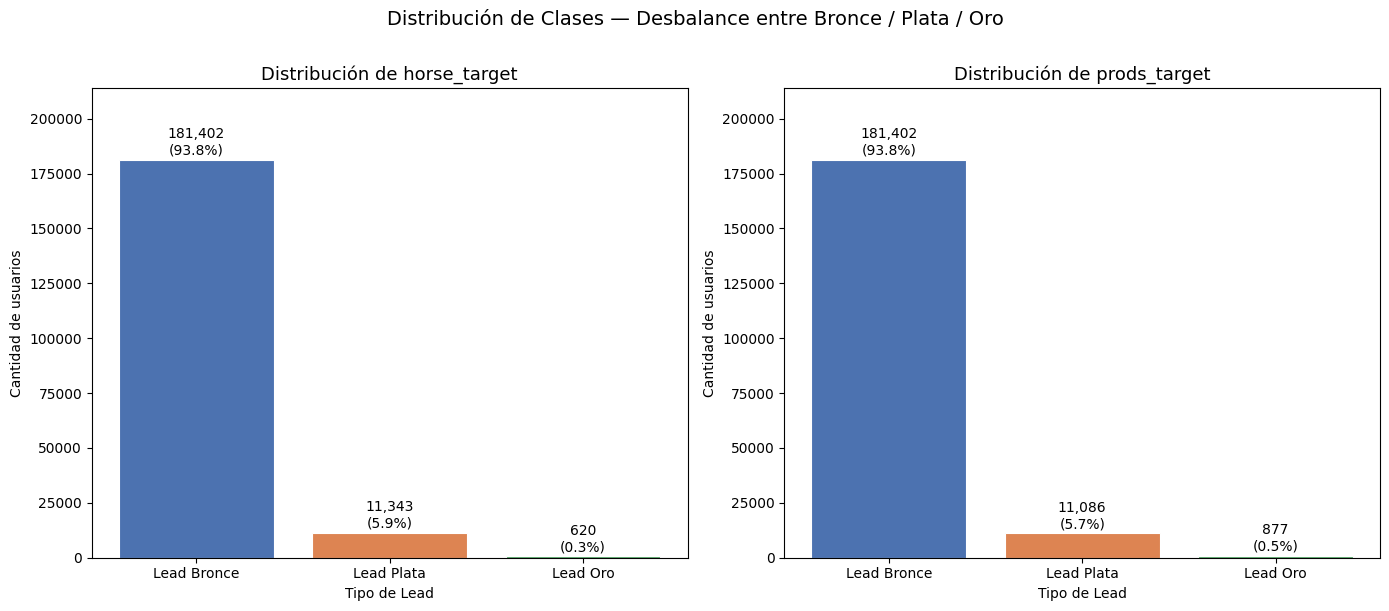

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#4C72B0', '#DD8452', '#55A868']

for target, ax in zip(targets, axes):
    counts = df_final[target].value_counts().reindex(orden_leads)
    bars = ax.bar(orden_leads, counts.values, color=colors, edgecolor='white', linewidth=0.8)
    ax.set_title(f'Distribución de {target}', fontsize=13)
    ax.set_xlabel('Tipo de Lead')
    ax.set_ylabel('Cantidad de usuarios')

    # Agregar etiquetas con % encima de cada barra
    total = counts.sum()
    for bar, val in zip(bars, counts.values):
        pct = val / total * 100
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.005,
                f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

    ax.set_ylim(0, counts.max() * 1.18)

plt.suptitle('Distribución de Clases — Desbalance entre Bronce / Plata / Oro', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

In [13]:
for target in targets: 
    values = df_final[target].value_counts()
    print(values)
    print("-"*50)

horse_target
Lead Bronce    181402
Lead Plata      11343
Lead Oro          620
Name: count, dtype: int64
--------------------------------------------------
prods_target
Lead Bronce    181402
Lead Plata      11086
Lead Oro          877
Name: count, dtype: int64
--------------------------------------------------


Podemos ver un gran desbalanceo de clases: hay muchos más Leads de Bronce y muy pocos Leads de Oro. Para manejar este desbalance en el modelado vamos a usar `class_weight='balanced'` en el RandomForest, que ajusta automáticamente el peso de cada clase inversamente proporcional a su frecuencia. También exploraremos SMOTE como alternativa.

#### Distribución de las variables relacionadas al precio

In [14]:
# Resumen estadístico de las variables de precio
price_cols = [
    'avg_horse_price_viewed', 'max_horse_price_viewed', 'min_horse_price_viewed',
    'avg_product_price_viewed', 'max_product_price_viewed'
]
df_final[price_cols].describe().round(2)

,avg_horse_price_viewed,max_horse_price_viewed,min_horse_price_viewed,avg_product_price_viewed,max_product_price_viewed
count,193365.00,193365.00,193365.00,193365.00,193365.00
mean,28029.87,42624.14,21315.52,867.23,1446.68
std,37909.40,95362.83,29592.10,440.11,1045.56
min,15000.00,15000.00,15000.00,500.95,500.95
25%,19250.00,21000.00,15000.00,629.95,675.00
50%,22500.00,25000.00,17250.00,747.95,1075.50
75%,28300.00,45000.00,22000.00,928.23,1885.50
max,1000000.00,1000000.00,1000000.00,4765.50,4765.50


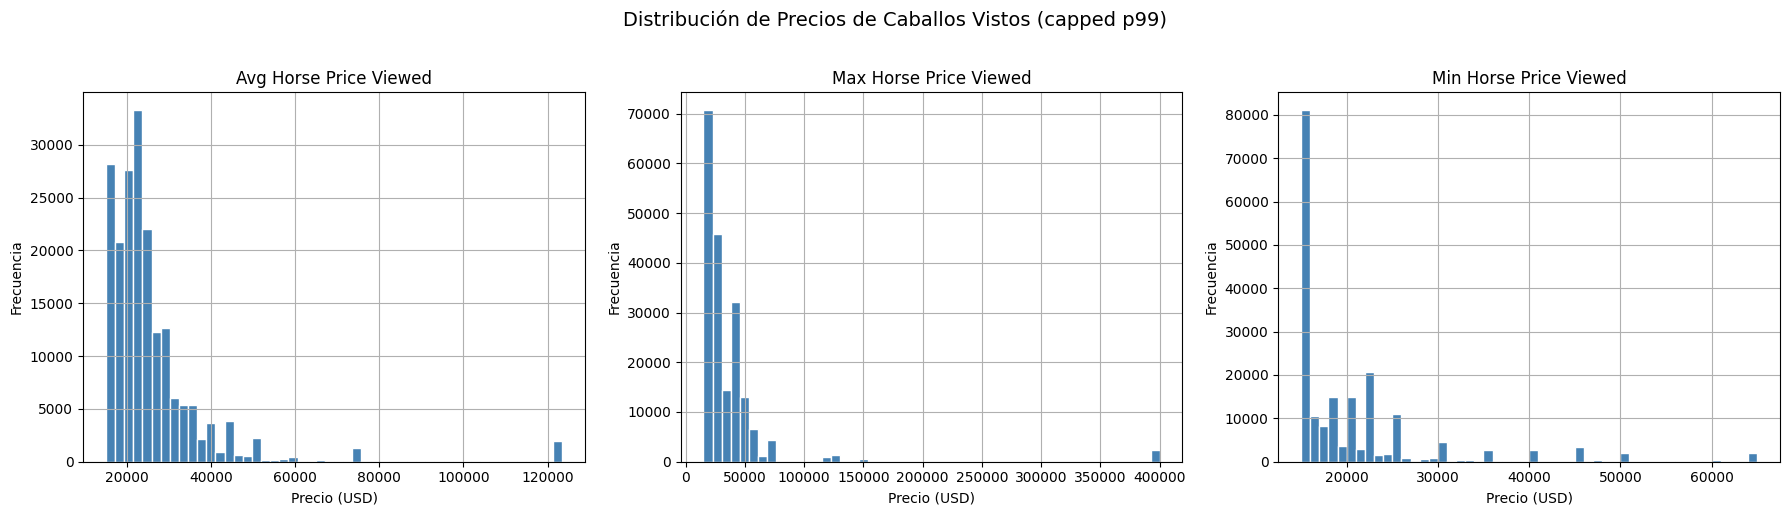

In [15]:
# Distribución de precios de caballos vistos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, ['avg_horse_price_viewed', 'max_horse_price_viewed', 'min_horse_price_viewed']):
    df_final[col].clip(upper=df_final[col].quantile(0.99)).hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Precio (USD)')
    ax.set_ylabel('Frecuencia')

plt.suptitle('Distribución de Precios de Caballos Vistos (capped p99)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

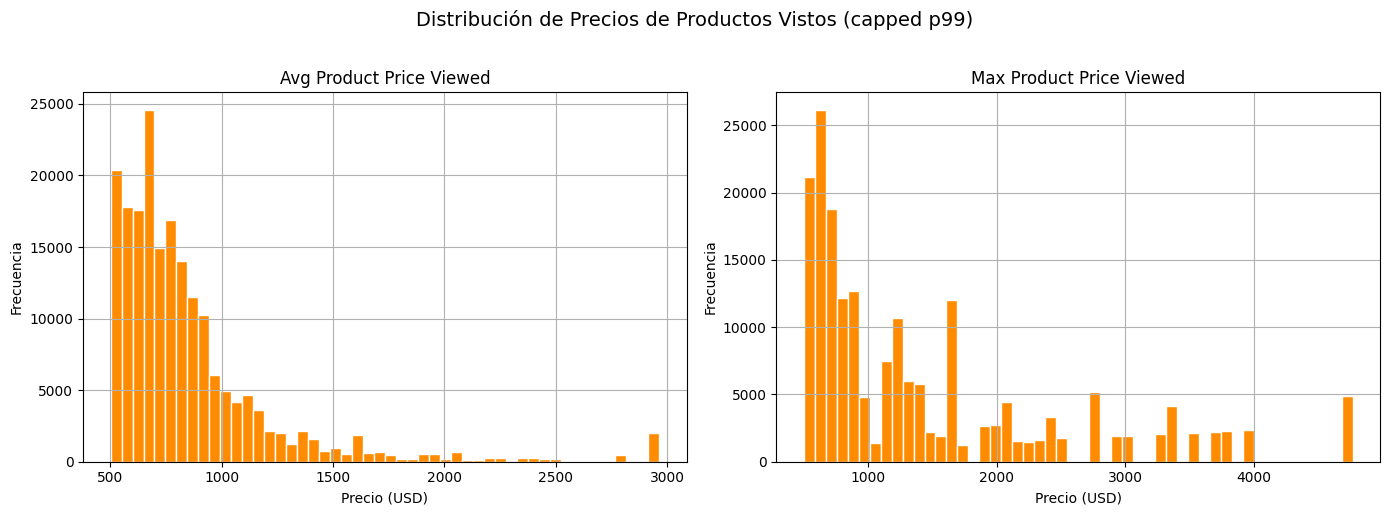

In [16]:
# Distribución de precios de productos vistos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, ['avg_product_price_viewed', 'max_product_price_viewed']):
    df_final[col].clip(upper=df_final[col].quantile(0.99)).hist(bins=50, ax=ax, color='darkorange', edgecolor='white')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('Precio (USD)')
    ax.set_ylabel('Frecuencia')

plt.suptitle('Distribución de Precios de Productos Vistos (capped p99)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Se observa que las distribuciones de precio tienen una cola larga hacia la derecha (skew positivo), lo cual es esperado en un marketplace de caballos donde los precios pueden variar desde cientos hasta cientos de miles de dólares. El capping al percentil 99 se aplicará en el preprocesamiento para reducir el efecto de outliers extremos.

In [17]:
# (Celda reservada — ver resumen estadístico y gráficos de arriba)

In [18]:
# (Celda reservada — ver gráficos de distribución de precios arriba)

#### Distribución de las variables relacionadas al engagement

Las variables de engagement miden cuánto interactuó el usuario con caballos y productos (cantidad de vistas, agregados al carrito, etc.). Son las features más importantes para el lead scoring.

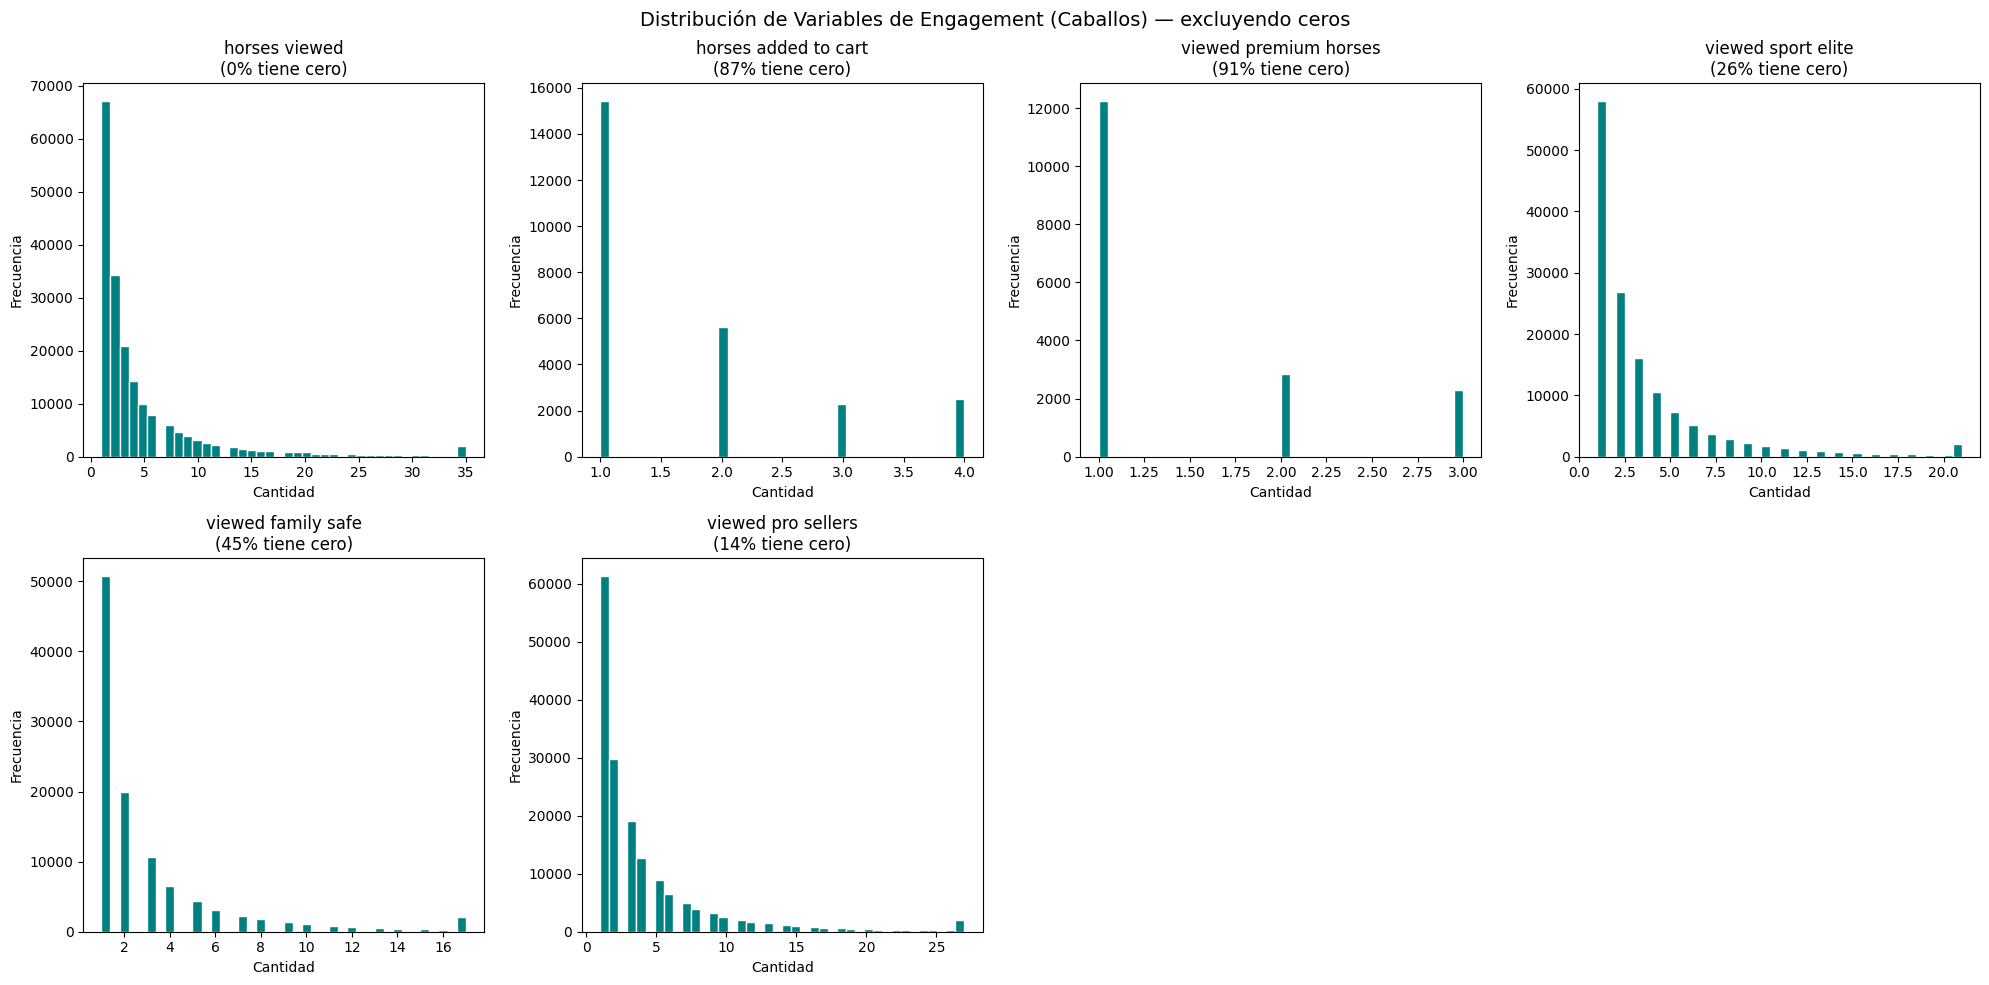

In [19]:
# Distribución de las variables de engagement de caballos
engagement_horse = [
    'horses_viewed', 'horses_added_to_cart', 'horses_purchased',
    'viewed_premium_horses', 'viewed_sport_elite', 'viewed_family_safe', 'viewed_pro_sellers'
]

# Filtramos solo columnas que existen
engagement_horse = [c for c in engagement_horse if c in df_final.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(engagement_horse):
    data = df_final[col].clip(upper=df_final[col].quantile(0.99))
    axes[idx].hist(data[data > 0], bins=40, color='teal', edgecolor='white')
    axes[idx].set_title(col.replace('_', ' '))
    axes[idx].set_xlabel('Cantidad')
    axes[idx].set_ylabel('Frecuencia')
    pct_zero = (df_final[col] == 0).mean() * 100
    axes[idx].set_title(f'{col.replace("_", " ")}\n({pct_zero:.0f}% tiene cero)')

# Ocultar ejes vacíos
for idx in range(len(engagement_horse), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribución de Variables de Engagement (Caballos) — excluyendo ceros', fontsize=14)
plt.tight_layout()
plt.show()

La mayoría de los usuarios tienen 0 interacciones con muchas de estas variables, lo que genera distribuciones muy sesgadas. El porcentaje con cero en cada feature nos indica cuán 'escasas' son. Las variables de engagement son las que más van a diferenciar los niveles de lead.

#### Distribución de las variables relacionadas al engagement de productos

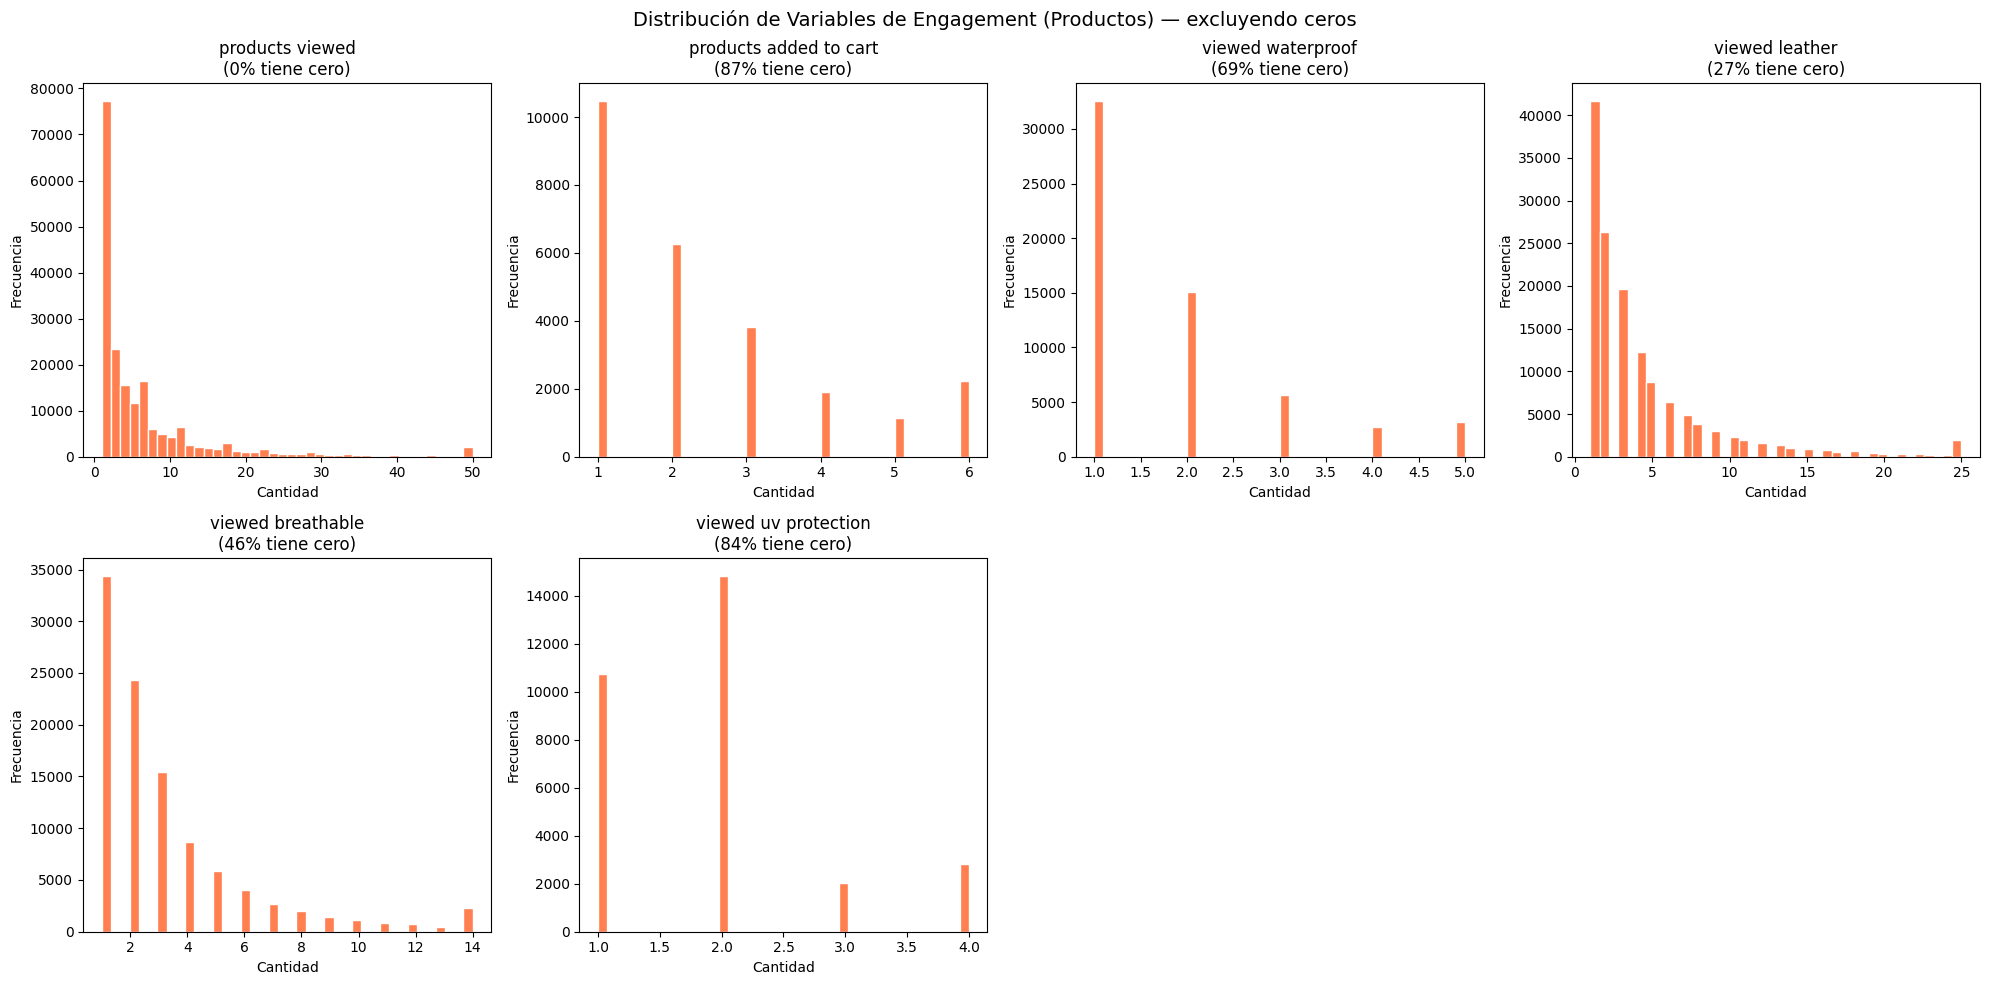

In [20]:
# Distribución de las variables de engagement de productos
engagement_prod = [
    'products_viewed', 'products_added_to_cart', 'products_purchased',
    'viewed_waterproof', 'viewed_leather', 'viewed_breathable', 'viewed_uv_protection'
]

engagement_prod = [c for c in engagement_prod if c in df_final.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(engagement_prod):
    data = df_final[col].clip(upper=df_final[col].quantile(0.99))
    axes[idx].hist(data[data > 0], bins=40, color='coral', edgecolor='white')
    pct_zero = (df_final[col] == 0).mean() * 100
    axes[idx].set_title(f'{col.replace("_", " ")}\n({pct_zero:.0f}% tiene cero)')
    axes[idx].set_xlabel('Cantidad')
    axes[idx].set_ylabel('Frecuencia')

for idx in range(len(engagement_prod), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribución de Variables de Engagement (Productos) — excluyendo ceros', fontsize=14)
plt.tight_layout()
plt.show()

#### Distribución de otras variables numéricas (caballo)

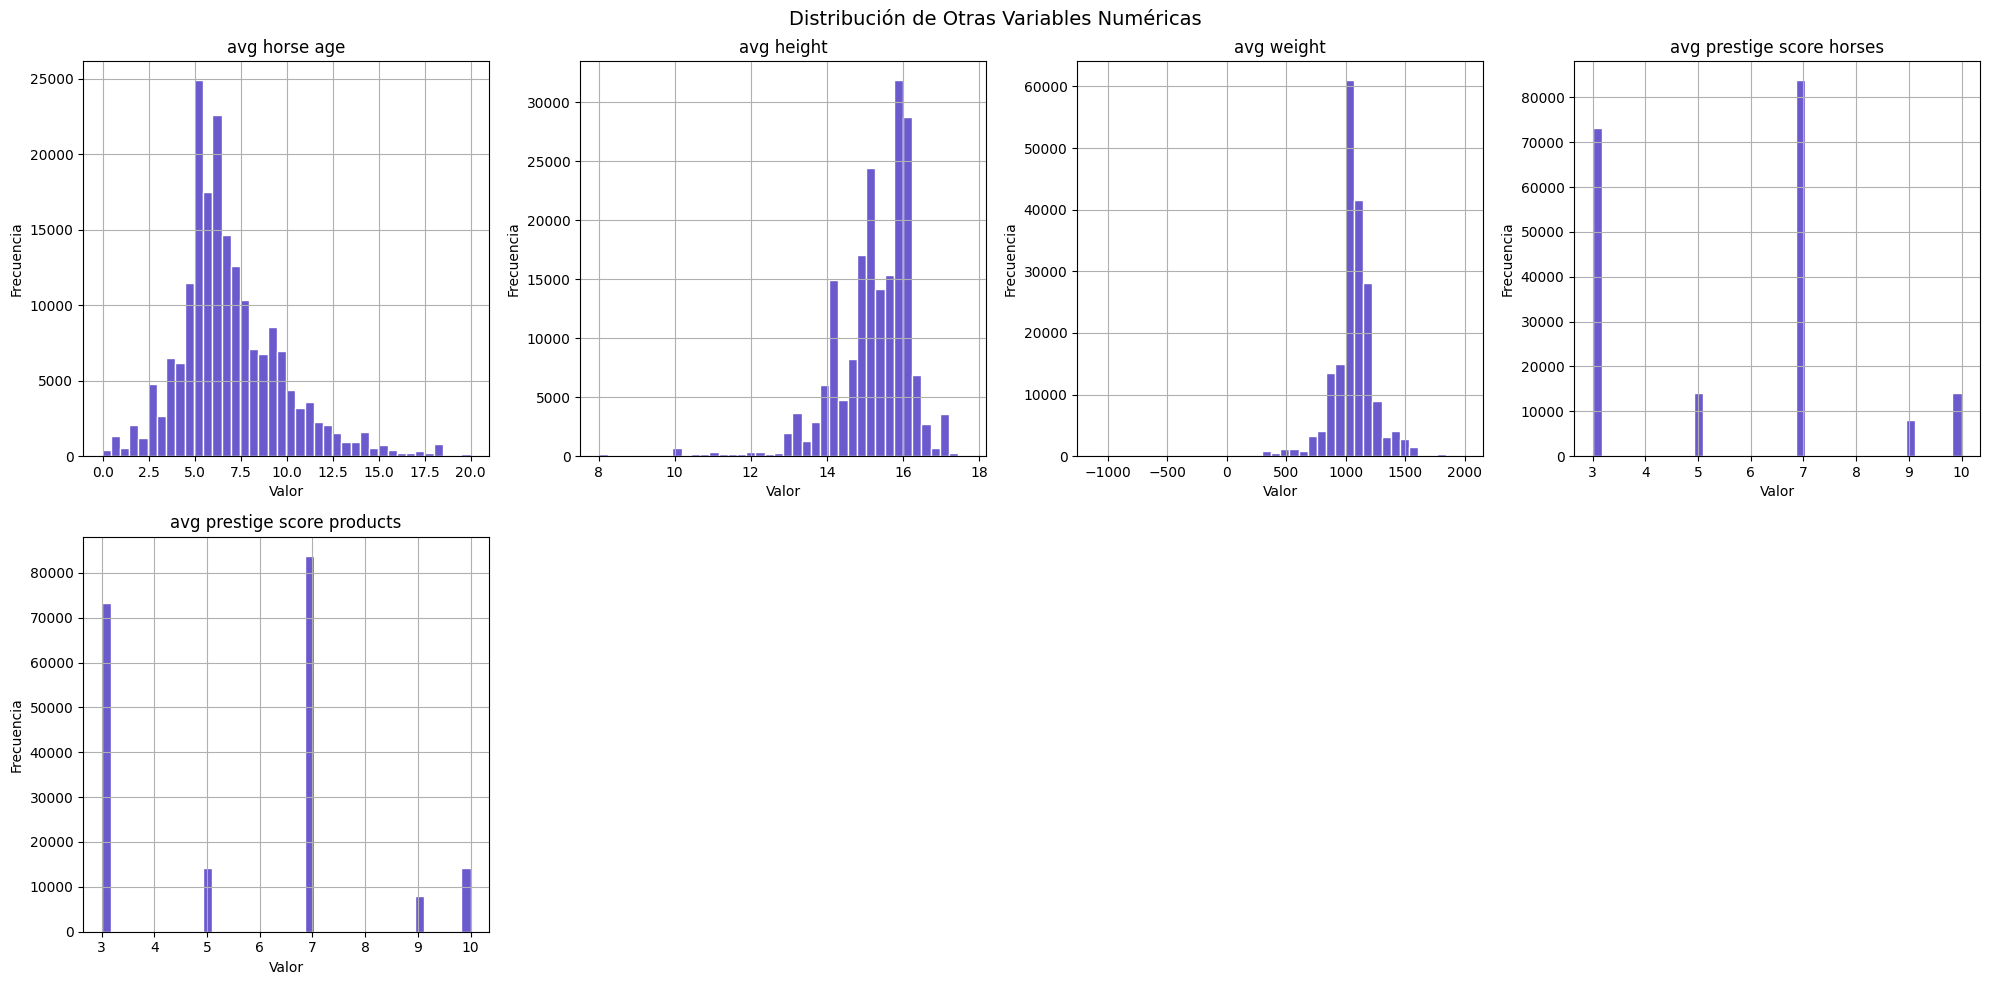

In [21]:
# Prestige score, altura, peso, temperatura, etc.
other_numeric = [
    'prestige_score', 'avg_horse_age', 'avg_height', 'avg_weight',
    'avg_temperament', 'avg_prestige_score_horses', 'avg_prestige_score_products'
]
other_numeric = [c for c in other_numeric if c in df_final.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(other_numeric):
    df_final[col].hist(bins=40, ax=axes[idx], color='slateblue', edgecolor='white')
    axes[idx].set_title(col.replace('_', ' '))
    axes[idx].set_xlabel('Valor')
    axes[idx].set_ylabel('Frecuencia')

for idx in range(len(other_numeric), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribución de Otras Variables Numéricas', fontsize=14)
plt.tight_layout()
plt.show()

Análisis pendiente

### Análisis Bivariado

#### Variables Numéricas vs Horse Target

Text(0.5, 1.0, 'Máximo precio de caballo visto por tipo de lead')

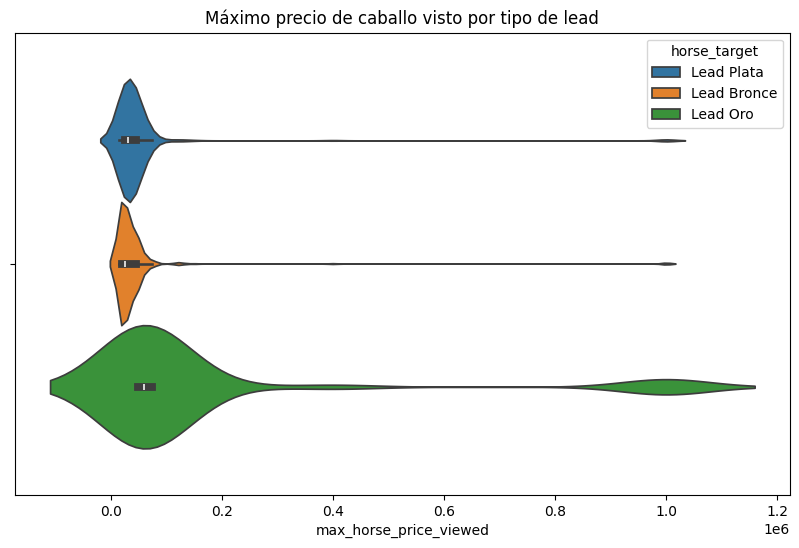

In [22]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='max_horse_price_viewed', hue="horse_target")
plt.title("Máximo precio de caballo visto por tipo de lead") 

Text(0.5, 1.0, 'Total de caballos agregados al carrito por tipo de lead')

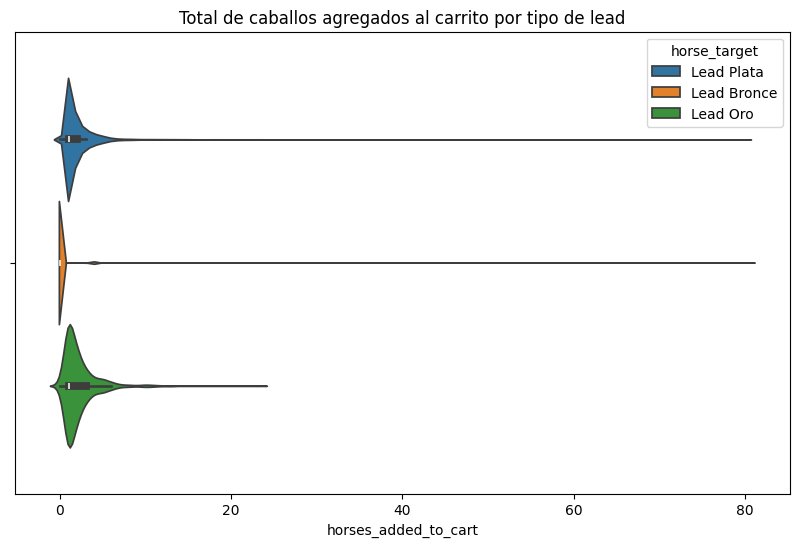

In [23]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='horses_added_to_cart', hue="horse_target")
plt.title("Total de caballos agregados al carrito por tipo de lead") 

Text(0.5, 1.0, 'Vio caballo de elite para deportes?')

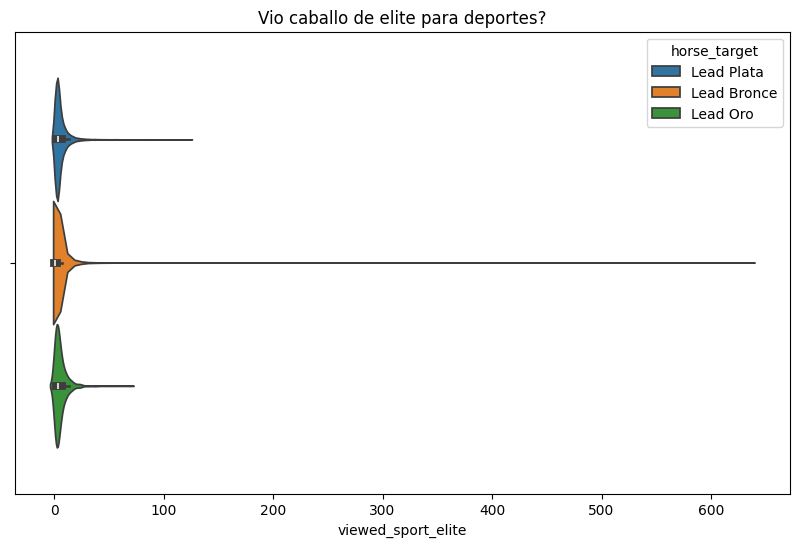

In [24]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='viewed_sport_elite', hue="horse_target")
plt.title("Vio caballo de elite para deportes?") 

Text(0.5, 1.0, 'Puntaje promedio de caballos vistos por tipo de lead')

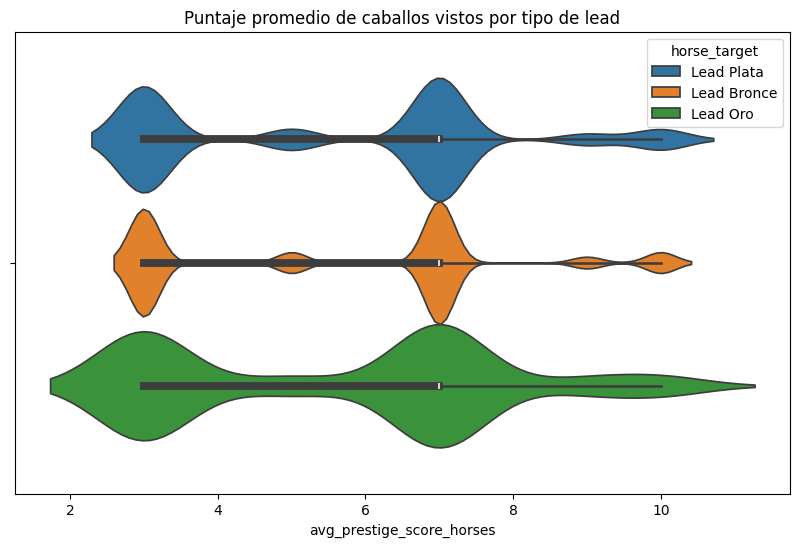

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='avg_prestige_score_horses', hue="horse_target")
plt.title("Puntaje promedio de caballos vistos por tipo de lead") 

OBSERVACIONES GRÁFICOS ANTERIORES

(-1.0, 30.0)

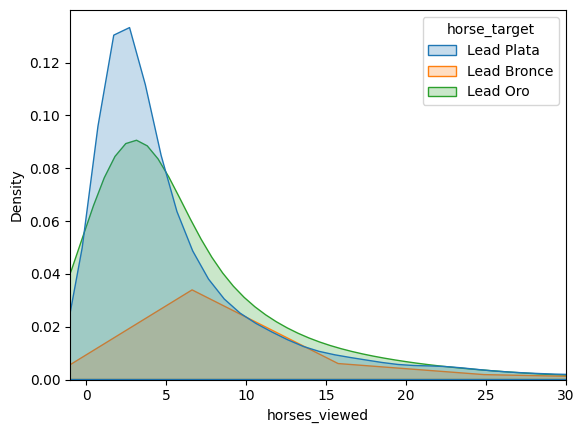

In [26]:
sns.kdeplot(data=df_final, x='horses_viewed', hue='horse_target', common_norm=False, fill=True)
plt.xlim(-1, 30)

El KDE muestra patrones claros:

- **Leads de Oro**: tienden a ver pocos caballos (entre 1 y 10). Saben lo que quieren y van directo a la compra.
- **Leads de Plata**: distribución más dispersa, muestran más exploración antes de agregar al carrito.
- **Leads de Bronce**: la gran mayoría ve muy pocos caballos (0-5), aunque hay una cola larga de usuarios que ven muchísimos — probablemente curiosos o bots que generan ese outlier.

Text(0.5, 1.0, 'Cantidad de caballos vistos')

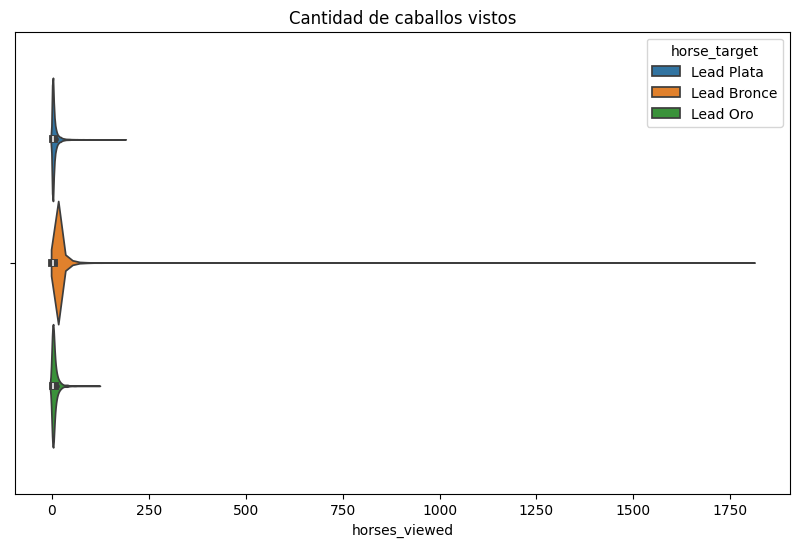

In [27]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='horses_viewed', hue="horse_target")
plt.title("Cantidad de caballos vistos") 

In [28]:
Q1 = df_final['horses_viewed'].quantile(0.25)
Q3 = df_final['horses_viewed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_final[(df_final['horses_viewed'] < lower_bound) | (df_final['horses_viewed'] > upper_bound)]
print(f"Cantidad de outliers en 'horses_viewed': {len(outliers)}")
percentage_outliers_iqr = (len(outliers) / len(df_final)) * 100
print(f"Porcentaje de outliers detectados por IQR: {percentage_outliers_iqr:.2f}%")

Cantidad de outliers en 'horses_viewed': 18471
Porcentaje de outliers detectados por IQR: 9.55%


In [29]:
distribucion = outliers["horse_target"].value_counts()
porcentaje = outliers["horse_target"].value_counts(normalize=True) * 100

resumen_outliers = pd.DataFrame({
    'Cantidad de Usuarios': distribucion,
    '% Dentro del grupo Outlier': porcentaje
})

print(resumen_outliers)

              Cantidad de Usuarios  % Dentro del grupo Outlier
horse_target                                                  
Lead Bronce                  16719                   90.514861
Lead Plata                    1650                    8.932922
Lead Oro                       102                    0.552217


Podemos ver que los leads bronce vieron demasiados caballos, este outlier puede tener que ver con aquellos usuarios que compartían comportamiento de bots.
  
Vamos a tener que tratar estos outliers luego para no sesgar al modelo.

Veamos los valores de las demás features relacionadas con la vista de un usuario a caballos

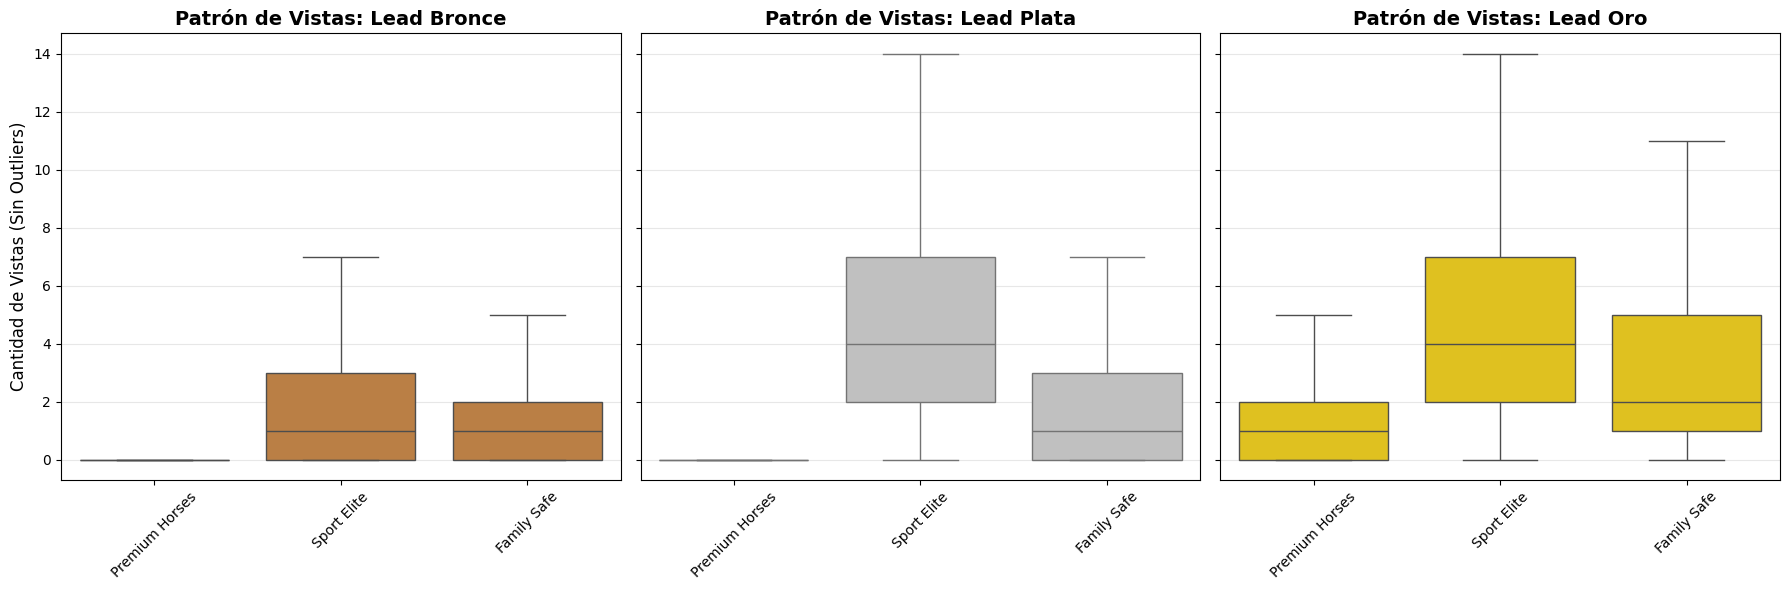

In [30]:
cols_vistas = [
    'viewed_premium_horses', 
    'viewed_sport_elite', 
    'viewed_family_safe'
]

df_vistas = df_final[['horse_target'] + cols_vistas]
df_melted = pd.melt(
    df_vistas, 
    id_vars=['horse_target'], 
    value_vars=cols_vistas,
    var_name='Tipo_de_Caballo', 
    value_name='Vistas'
)

df_melted['Tipo_de_Caballo'] = df_melted['Tipo_de_Caballo'].str.replace('viewed_', '').str.replace('_', ' ').str.title()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # sharey=True iguala el eje Y para que sean comparables

# Definimos el orden y los colores para cada panel
leads = ['Lead Bronce', 'Lead Plata', 'Lead Oro']
colores = ['#cd7f32', '#C0C0C0', '#FFD700'] 

# Bucle para dibujar cada gráfico
for i, lead in enumerate(leads):
    # Filtramos solo los datos del lead actual
    datos_lead = df_melted[df_melted['horse_target'] == lead]
    
    # Usamos boxplot ocultando outliers extremos para ver la "masa normal"
    sns.boxplot(
        data=datos_lead, 
        x='Tipo_de_Caballo', 
        y='Vistas', 
        ax=axes[i],
        color=colores[i],
        showfliers=False 
    )
    
    # Diseño de cada panel
    axes[i].set_title(f"Patrón de Vistas: {lead}", fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45) 
    axes[i].set_xlabel("")
    axes[i].grid(axis='y', alpha=0.3)
    
    if i == 0:
        axes[i].set_ylabel("Cantidad de Vistas (Sin Outliers)", fontsize=12)
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

Los Leads de Oro y Plata muestran mayor interacción con caballos premium, de elite deportiva y familiares que los Bronce. Esto valida que estas features son señales útiles para distinguir los niveles de lead.

#### Variables Numéricas vs Product Target

Text(0.5, 1.0, 'Máximo precio de producto visto por tipo de lead')

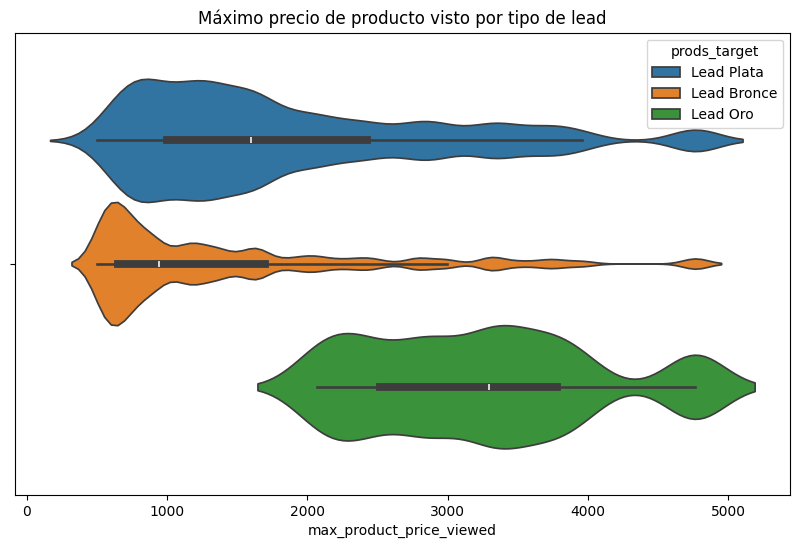

In [31]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='max_product_price_viewed', hue="prods_target")
plt.title("Máximo precio de producto visto por tipo de lead") 

Text(0.5, 1.0, 'Total de productos agregados al carrito por tipo de lead')

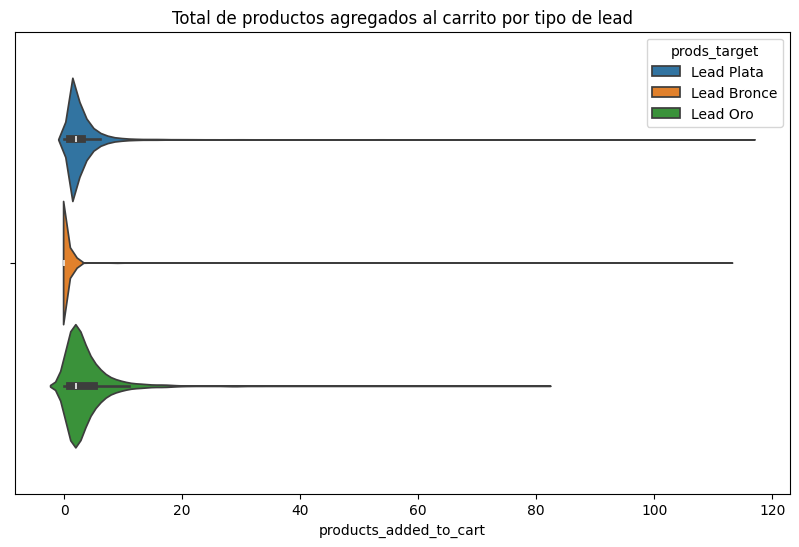

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='products_added_to_cart', hue="prods_target")
plt.title("Total de productos agregados al carrito por tipo de lead") 

Text(0.5, 1.0, 'Vio caballo de elite para deportes?')

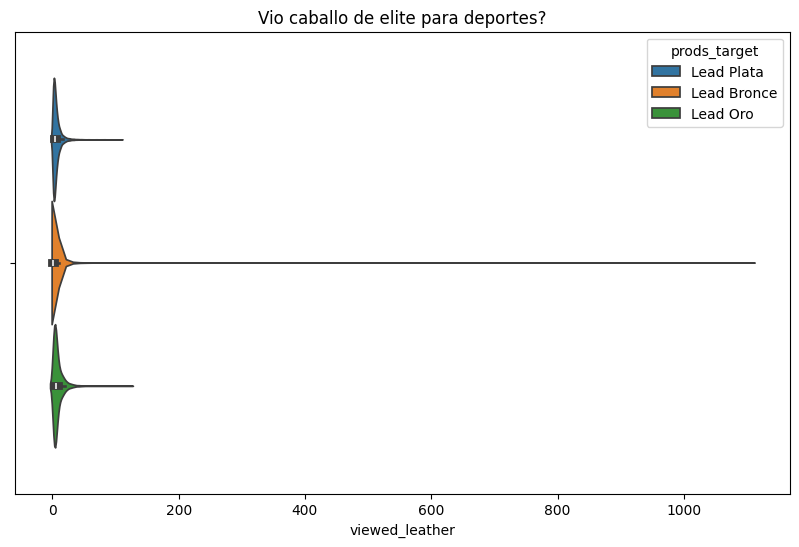

In [33]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='viewed_leather', hue="prods_target")
plt.title("Vio caballo de elite para deportes?") 

Text(0.5, 1.0, 'Puntaje promedio de productos vistos por tipo de lead')

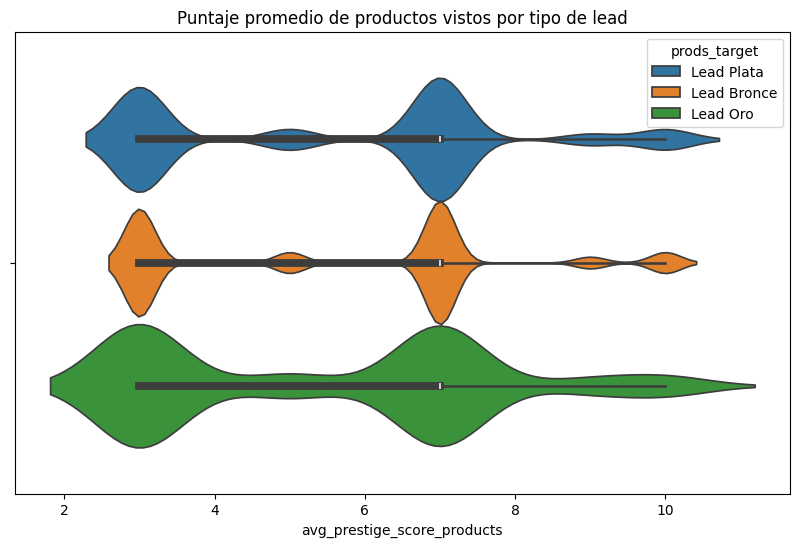

In [34]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_final, x='avg_prestige_score_products', hue="prods_target")
plt.title("Puntaje promedio de productos vistos por tipo de lead") 

Observaciones de los 4 gráficos anteriores

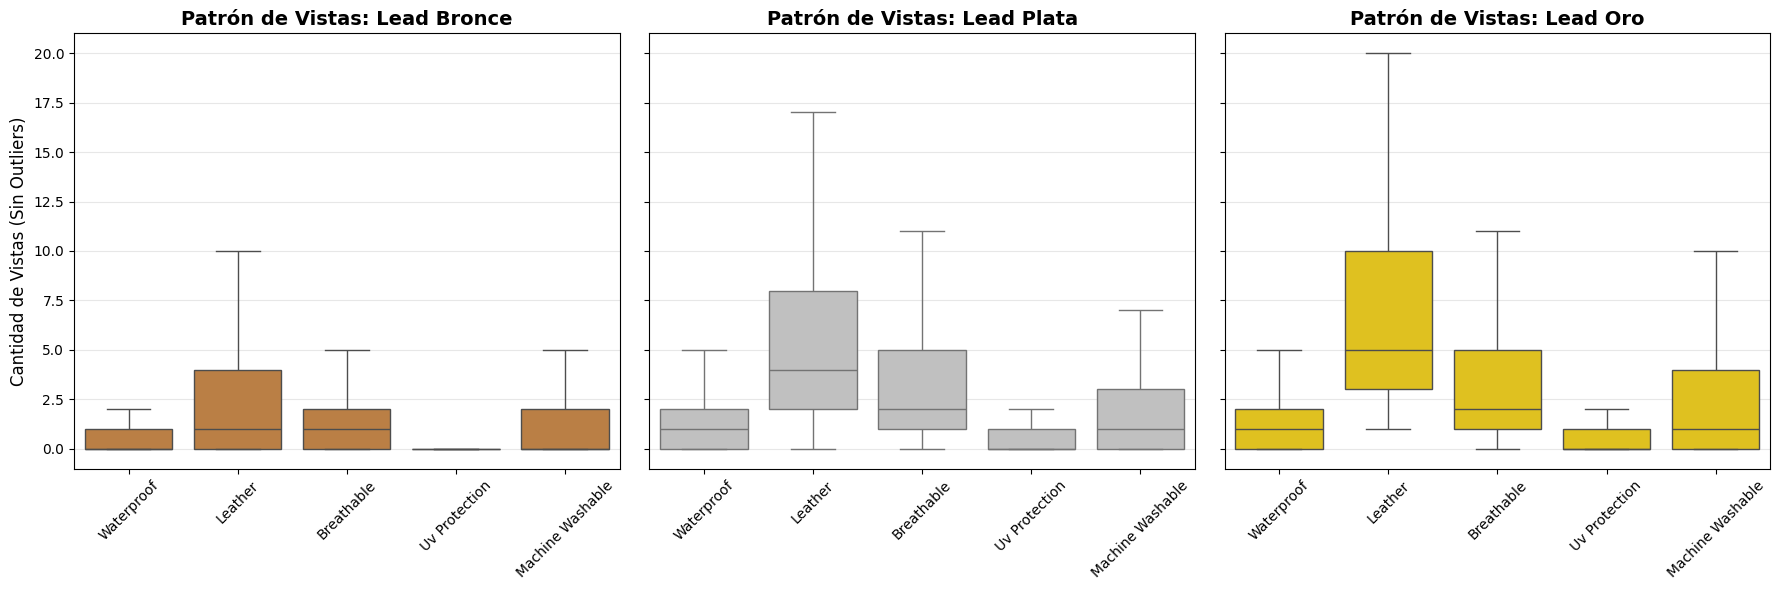

In [35]:
cols_vistas = [
    'viewed_waterproof', 
    'viewed_leather', 
    'viewed_breathable',
    "viewed_uv_protection",
    "viewed_machine_washable"
]

df_vistas = df_final[['prods_target'] + cols_vistas]
df_melted = pd.melt(
    df_vistas, 
    id_vars=['prods_target'], 
    value_vars=cols_vistas,
    var_name='Tipo_de_Producto', 
    value_name='Vistas'
)

df_melted['Tipo_de_Producto'] = df_melted['Tipo_de_Producto'].str.replace('viewed_', '').str.replace('_', ' ').str.title()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # sharey=True iguala el eje Y para que sean comparables

# Definimos el orden y los colores para cada panel
leads = ['Lead Bronce', 'Lead Plata', 'Lead Oro']
colores = ['#cd7f32', '#C0C0C0', '#FFD700'] 

# Bucle para dibujar cada gráfico
for i, lead in enumerate(leads):
    # Filtramos solo los datos del lead actual
    datos_lead = df_melted[df_melted['prods_target'] == lead]
    
    # Usamos boxplot ocultando outliers extremos para ver la "masa normal"
    sns.boxplot(
        data=datos_lead, 
        x='Tipo_de_Producto', 
        y='Vistas', 
        ax=axes[i],
        color=colores[i],
        showfliers=False 
    )
    
    # Diseño de cada panel
    axes[i].set_title(f"Patrón de Vistas: {lead}", fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45) 
    axes[i].set_xlabel("")
    axes[i].grid(axis='y', alpha=0.3)
    
    if i == 0:
        axes[i].set_ylabel("Cantidad de Vistas (Sin Outliers)", fontsize=12)
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

Los Leads de Oro y Plata también tienden a ver más productos de cuero (*leather*), impermeables (*waterproof*) y transpirables (*breathable*), lo que sugiere un perfil de comprador más sofisticado e informado sobre equipamiento ecuestre.

#### Variables Binarias vs Targets

En este caso, cómo las variables binarias salen del dataset de caballos, vamos a comparar ambas únicamente con **horse_target**.

Las variables binarias `has_shipping_viewed` y `has_registry_viewed` indican si el usuario interactuó con caballos que ofrecen transporte o tienen registro de pedigree, respectivamente. Veremos si estos atributos discriminan entre los niveles de lead.

<Axes: xlabel='has_shipping_viewed'>

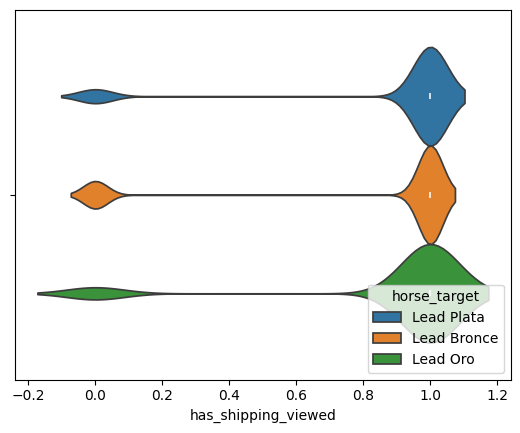

In [36]:
sns.violinplot(data=df_final, x = "has_shipping_viewed", hue="horse_target")

<Axes: xlabel='has_registry_viewed'>

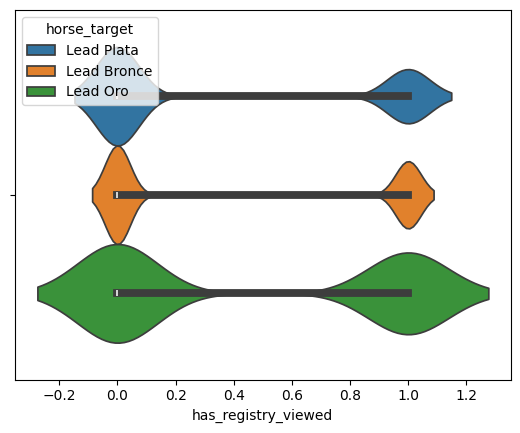

In [37]:
sns.violinplot(data=df_final, x = "has_registry_viewed", hue="horse_target")

Los caballos con registro (*has_registry*) tienden a atraer más a Leads de Oro y Plata, lo que tiene sentido: un comprador serio prefiere caballos con pedigree verificado. El shipping también muestra una leve diferencia entre niveles.

#### Variable vs Variable

Analizamos relaciones entre variables para detectar comportamientos cruzados interesantes que pueden no ser capturados por el análisis univariado.

<Axes: xlabel='horses_viewed', ylabel='products_viewed'>

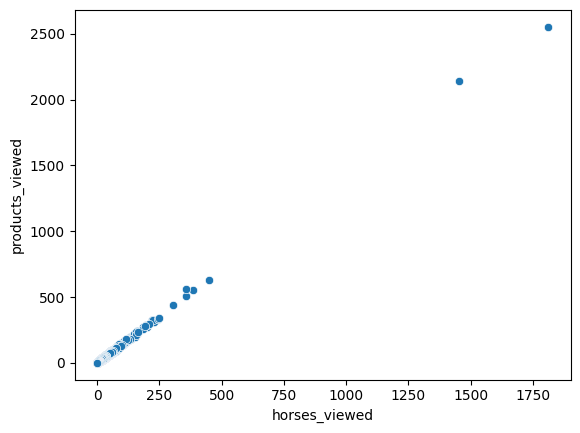

In [39]:
sns.scatterplot(data=df_final, x="horses_viewed", y="products_viewed")

La mayoría de los usuarios se concentra en el origen (0,0): solo vieron caballos O solo productos, no ambos. Hay una pequeña fracción con actividad en ambas dimensiones, que probablemente corresponde a los Leads de mayor calidad.

<Axes: xlabel='avg_horse_price_viewed', ylabel='avg_prestige_score_horses'>

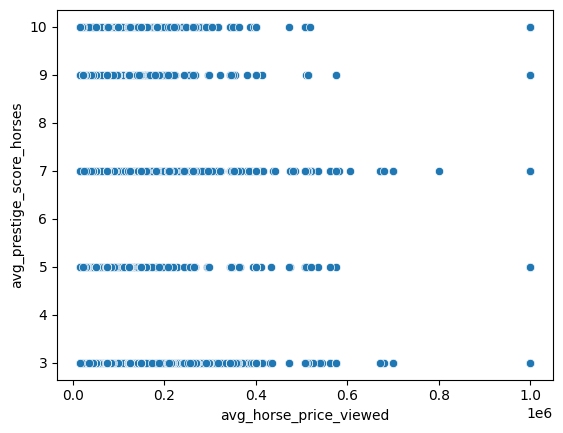

In [40]:
sns.scatterplot(data=df_final, x="avg_horse_price_viewed", y="avg_prestige_score_horses")

No se observa una correlación clara entre el precio promedio de los caballos vistos y el prestige score del usuario. Esto sugiere que el poder adquisitivo del lead (inferido por su cargo) no predice directamente el rango de precios que explora.

<Axes: xlabel='avg_height', ylabel='avg_weight'>

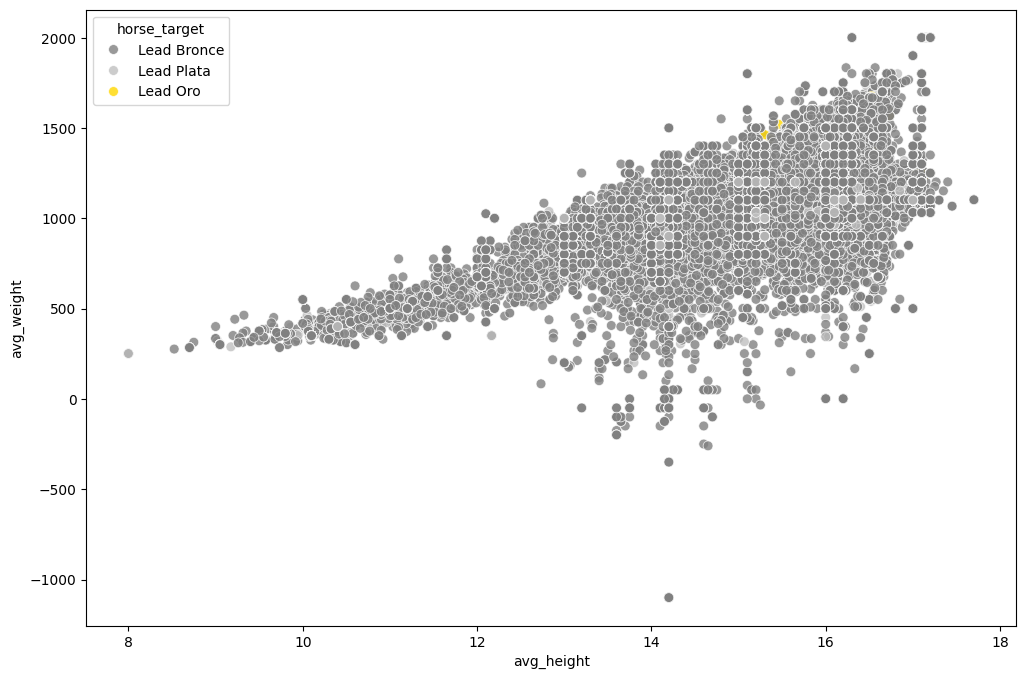

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_final, x='avg_height', y='avg_weight', hue='horse_target', hue_order=["Lead Bronce", "Lead Plata", "Lead Oro"], alpha=0.8, s=50, palette=['#808080', '#C0C0C0', '#FFD700'])

La relación altura/peso de los caballos vistos muestra la distribución física típica del mercado ecuestre. Los tres tipos de lead están distribuidos de forma similar, lo que indica que estas variables físicas probablemente no sean predictores fuertes del nivel de lead por sí solas.

In [42]:
# Resumen del análisis bivariado
print('Variables con mayor poder discriminativo (observado en los gráficos):')
print('  Caballos  → horses_added_to_cart, max_horse_price_viewed, viewed_sport_elite')
print('  Productos → products_added_to_cart, max_product_price_viewed, viewed_leather')
print()
print('Variables con bajo poder discriminativo:')
print('  avg_height, avg_weight, avg_prestige_score (poca separación entre clases)')

Variables con mayor poder discriminativo (observado en los gráficos):
  Caballos  → horses_added_to_cart, max_horse_price_viewed, viewed_sport_elite
  Productos → products_added_to_cart, max_product_price_viewed, viewed_leather

Variables con bajo poder discriminativo:
  avg_height, avg_weight, avg_prestige_score (poca separación entre clases)


### Correlación

In [43]:
correlation_matrix = df_final.corr(numeric_only=True)

In [44]:
correlation_matrix

,horses_viewed,horses_added_to_cart,avg_horse_price_viewed,max_horse_price_viewed,min_horse_price_viewed,viewed_premium_horses,viewed_sport_elite,viewed_family_safe,avg_horse_age,viewed_pro_sellers,...,max_product_price_viewed,unique_categories,viewed_waterproof,viewed_leather,viewed_breathable,viewed_uv_protection,viewed_machine_washable,avg_prestige_score_products,total_views,total_cart_adds
horses_viewed,1.000000,0.114839,-0.000147,0.109406,-0.066865,0.266719,0.839497,0.845309,0.000689,0.936355,...,0.391260,0.529593,0.785140,0.946539,0.895062,0.605446,0.822736,-0.001436,0.998033,0.113030
horses_added_to_cart,0.114839,1.000000,-0.003243,0.042522,-0.037274,0.063869,0.263597,0.134683,-0.006624,0.254997,...,0.180821,0.272164,0.185336,0.226676,0.212250,0.155717,0.198609,0.004258,0.114341,0.989838
avg_horse_price_viewed,-0.000147,-0.003243,1.000000,0.736776,0.764422,0.255537,0.000048,0.017347,0.085671,-0.012176,...,0.000724,0.002088,-0.001020,-0.001010,-0.002739,-0.001564,-0.002105,0.000190,-0.000294,-0.003233
max_horse_price_viewed,0.109406,0.042522,0.736776,1.000000,0.281662,0.379802,0.119944,0.098014,0.093658,0.081917,...,0.091505,0.144773,0.089836,0.105496,0.098659,0.070024,0.089025,-0.001011,0.108408,0.041941
min_horse_price_viewed,-0.066865,-0.037274,0.764422,0.281662,1.000000,0.073405,-0.064076,-0.050596,0.049939,-0.069072,...,-0.076738,-0.132590,-0.054881,-0.066653,-0.063991,-0.045507,-0.057804,0.000001,-0.066481,-0.036707
viewed_premium_horses,0.266719,0.063869,0.255537,0.379802,0.073405,1.000000,0.203726,0.223495,0.028602,0.247584,...,0.153106,0.209426,0.213159,0.255091,0.241405,0.168064,0.218362,-0.003056,0.264700,0.063030
viewed_sport_elite,0.839497,0.263597,0.000048,0.119944,-0.064076,0.203726,1.000000,0.582335,0.002224,0.859686,...,0.381235,0.528502,0.681737,0.816387,0.772541,0.522228,0.705524,0.000169,0.837481,0.259599
viewed_family_safe,0.845309,0.134683,0.017347,0.098014,-0.050596,0.223495,0.582335,1.000000,0.012708,0.773661,...,0.309115,0.413460,0.666793,0.804489,0.761337,0.517047,0.703331,-0.002099,0.844072,0.133816
avg_horse_age,0.000689,-0.006624,0.085671,0.093658,0.049939,0.028602,0.002224,0.012708,1.000000,-0.011407,...,0.003227,-0.000927,-0.002561,0.000223,-0.000882,-0.000373,0.001178,0.000463,0.000687,-0.006201
viewed_pro_sellers,0.936355,0.254997,-0.012176,0.081917,-0.069072,0.247584,0.859686,0.773661,-0.011407,1.000000,...,0.395452,0.542728,0.752034,0.904399,0.856817,0.580605,0.786288,-0.000271,0.934240,0.251343


<Axes: >

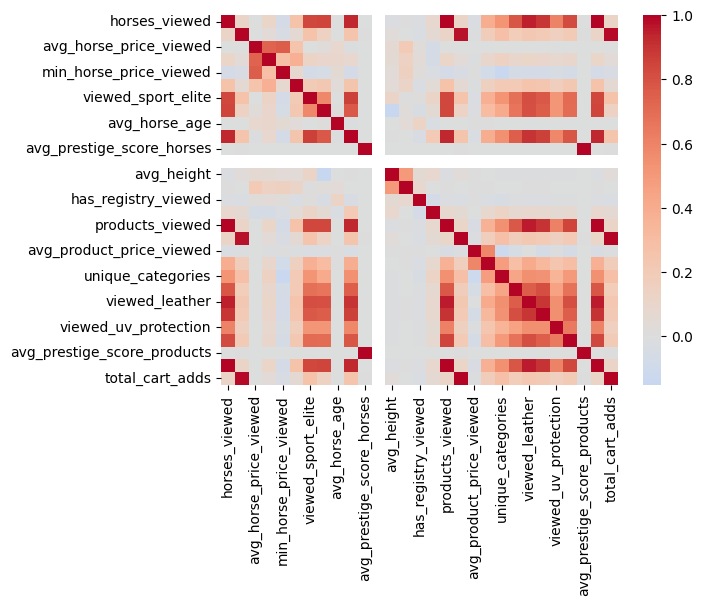

In [45]:
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0)

Viendo que es difícil extraer correlaciones de tantas columnas, vamos a observar las correlaciones solo con los targets y también vemos correlaciones mayores a 0.50 (o menores a -0.50) para detectar columnas que pueden llegar a ser eliminadas.

Si detectamos 2 columnas con correlación alta (>0.80) entre ellas, luego vemos cuál de las dos tiene mayor correlación con los targets para ver cuál eliminamos.

Generamos la matriz de correlación sobre el dataset final (todas las features numéricas, incluyendo los targets mapeados a 0/1/2)

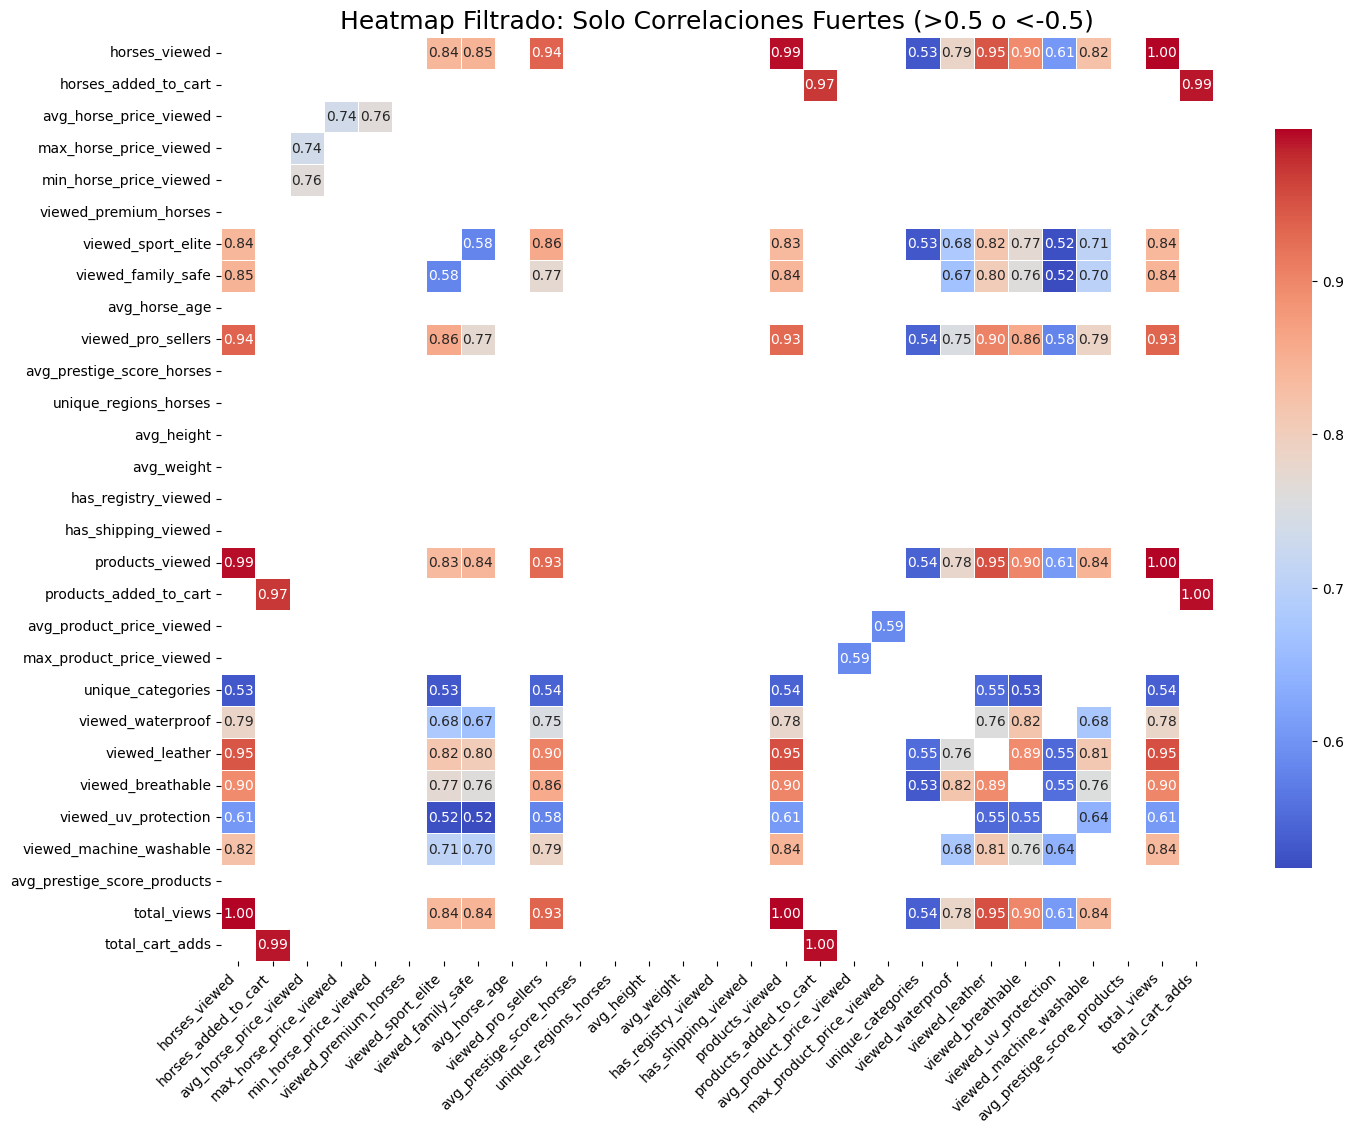

In [47]:
plt.figure(figsize=(16, 12))

corr = df_final.corr(numeric_only=True)

corr_fuerte = corr[((corr >= 0.5) | (corr <= -0.5)) & (corr != 1.000)]

sns.heatmap(
    corr_fuerte, 
    annot=True,       
    fmt=".2f",        
    cmap="coolwarm",  
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title("Heatmap Filtrado: Solo Correlaciones Fuertes (>0.5 o <-0.5)", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.show()

Del heatmap filtrado (correlaciones > 0.5) se pueden ver varios grupos de variables altamente correlacionadas:

- **Vistas totales vs vistas individuales**: `total_views`, `horses_viewed`, `products_viewed`, `viewed_pro_sellers`, `viewed_family_safe` (~0.86–1.00)
- **Carritos**: `total_cart_adds`, `horses_added_to_cart`, `products_added_to_cart` (~0.99–1.00)
- **Materiales de productos**: `viewed_leather`, `viewed_breathable`, `viewed_machine_washable` (~0.84–0.91)
- **Precios de caballos**: `avg_horse_price_viewed`, `min_horse_price_viewed` (~0.80)

En la sección de Modelado, nos vamos a quedar con una sola variable por grupo: la que tenga mayor correlación con los targets.

Veamos de eliminar las columnas que menos correlación tengan con ambos targets luego.

Ahora veamos la correlación entre las variables categóricas y los targets

In [48]:
from scipy.stats.contingency import association

In [49]:
for var in categorical_cols[2:]:
    
    serie_var = df_final[var]
    if isinstance(serie_var, pd.DataFrame):
        serie_var = serie_var.iloc[:, 0]
        
    # Bucle para evaluar la misma variable contra ambos targets
    for target in targets:
        serie_target = df_final[target]
        if isinstance(serie_target, pd.DataFrame):
            serie_target = serie_target.iloc[:, 0]
            
        df_temp = pd.DataFrame({'Variable': serie_var, 'Target': serie_target}).dropna()
        
        # Hacemos el crosstab
        tabla_contingencia = pd.crosstab(df_temp['Variable'], df_temp['Target'])
        
        # Calculamos la V de Cramér
        cramer_v = association(tabla_contingencia, method="cramer")
        
        print(f" {var} vs {target}: {cramer_v:.4f}")
        
    print("-" * 60)

 gender_with_most_appearances vs horse_target: 0.0499
 gender_with_most_appearances vs prods_target: 0.0479
------------------------------------------------------------
 breedFamily_with_most_appearances vs horse_target: 0.0517
 breedFamily_with_most_appearances vs prods_target: 0.0323
------------------------------------------------------------
 color_grouped_with_most_appearances vs horse_target: 0.0454
 color_grouped_with_most_appearances vs prods_target: 0.0401
------------------------------------------------------------
 most_viewed_category vs horse_target: 0.0627
 most_viewed_category vs prods_target: 0.0672
------------------------------------------------------------
 most_viewed_brand vs horse_target: 0.0416
 most_viewed_brand vs prods_target: 0.0421
------------------------------------------------------------
 most_viewed_target_user vs horse_target: 0.0352
 most_viewed_target_user vs prods_target: 0.0361
------------------------------------------------------------


Podemos ver que la variables categóricas tienen bajísima correlación con los targets, es decir, son más ruido que información relevante, por lo que, vamos a eliminarlas.  
Además haber hecho One Hot Encoding a todas estas variables iba a suponer un aumento considerable de columnas.

In [50]:
df_final = df_final.drop(columns=categorical_cols[2:])

In [51]:
grupos_colineales = {
    "Vistas Globales y Filtros de Caballos (Corr 0.86 - 1.00)": [
        'total_views', 
        'horses_viewed', 
        'products_viewed', 
        'viewed_pro_sellers', 
        'viewed_family_safe'
    ],
    "Carritos (Corr 0.99 - 1.00)": [
        'total_cart_adds', 
        'horses_added_to_cart', 
        'products_added_to_cart'
    ],
    "Materiales de Productos (Corr 0.84 - 0.91)": [
        'viewed_leather', 
        'viewed_breathable', 
        'viewed_machine_washable'
    ],
    "Precios (Corr 0.80)": [
        'avg_horse_price_viewed', 
        'min_horse_price_viewed'
    ]
}

Identificamos grupos de variables con alta correlación entre sí. Esta información es **solo exploratoria** — la documentamos aquí para entender la estructura del dataset. La decisión de qué features conservar la vamos a tomar **después del modelado**, usando **feature importance** del Random Forest en lugar de correlación. Así nos basamos en lo que el modelo realmente usa, no en métricas estadísticas simples.

Luego de analizar las correlaciones entre variables y con los targets, registramos las variables candidatas a ser ruido (correlación < 0.05 con ambos targets). Igual que con la colinealidad, **no las eliminamos acá** — esto es solo documentación exploratoria.

**Nota:** El análisis de ruido a continuación es **exploratorio**. No se van a dropear features en base a este análisis — la selección final se hará con feature importance del modelo entrenado, que es más robusta que la correlación para capturar relaciones no lineales.

In [52]:
umbral_ruido = 0.05
columnas_ruido_pearson = []
columnas_ruido_spearman = []

for var in numeric_cols[:-1]:
    # Calculamos correlación absoluta
    corr_horse_pearson = abs(df_final[var].corr(df_final['horse_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2})))
    corr_prods_pearson = abs(df_final[var].corr(df_final['prods_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2})))

    corr_horse_spearman = abs(df_final[var].corr(df_final['horse_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2}), method="spearman"))
    corr_prods_spearman = abs(df_final[var].corr(df_final['prods_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2}), method="spearman"))
    
    if corr_horse_pearson < umbral_ruido and corr_prods_pearson < umbral_ruido:
        if var not in columnas_ruido_pearson:
            columnas_ruido_pearson.append(var)
    if corr_horse_spearman < umbral_ruido and corr_prods_spearman < umbral_ruido:
        if var not in columnas_ruido_spearman:
            columnas_ruido_spearman.append(var)

print(f'Features candidatas a ruido (Pearson):  {len(columnas_ruido_pearson)}')
print(f'Features candidatas a ruido (Spearman): {len(columnas_ruido_spearman)}')
print('Nota: estas columnas se documentan pero NO se eliminan acá.')

/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/alumni/Programació

Features candidatas a ruido (Pearson):  13
Features candidatas a ruido (Spearman): 8
Nota: estas columnas se documentan pero NO se eliminan acá.


In [53]:
# Lista de features candidatas a ruido (documentación exploratoria)
print('Pearson:', columnas_ruido_pearson)
print('Spearman:', columnas_ruido_spearman)

Pearson: ['horses_viewed', 'avg_horse_price_viewed', 'max_horse_price_viewed', 'min_horse_price_viewed', 'avg_horse_age', 'avg_prestige_score_horses', 'avg_height', 'avg_weight', 'has_registry_viewed', 'products_viewed', 'avg_product_price_viewed', 'avg_prestige_score_products', 'total_views']
Spearman: ['avg_horse_price_viewed', 'viewed_premium_horses', 'avg_horse_age', 'avg_prestige_score_horses', 'avg_height', 'avg_weight', 'has_registry_viewed', 'avg_prestige_score_products']


## Modelado

### Preprocesamiento

Empecemos el preprocesamiento: primero el train/test split, luego el capping de outliers y el balanceo de clases. **No vamos a dropear features por correlación** — esa decisión la tomamos después del primer entrenamiento usando feature importance.

In [54]:
from sklearn.model_selection import train_test_split

Antes de hacer el split, eliminamos los casos inconsistentes del dataset: usuarios clasificados como Lead Oro en caballos pero Lead Bronce en productos. Son solo 1-2 filas que representan anomalías en la definición del target (un usuario que compró un caballo pero nunca interactuó con productos).

In [55]:
X = df_final.drop(columns=["horse_target", "prods_target"])
y = df_final[["horse_target", "prods_target"]]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [57]:
target_horse_num = y_train['horse_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2})
target_prods_num = y_train['prods_target'].map({"Lead Bronce": 0, "Lead Plata": 1, "Lead Oro": 2})

Registramos las columnas colineales identificadas en el EDA como referencia, pero no las eliminamos antes del primer entrenamiento.  
La selección de features la hacemos con feature importance después del modelado.

In [58]:
columnas_colineales_doc = {}
for nombre_grupo, variables in grupos_colineales.items():
    columnas_colineales_doc[nombre_grupo] = variables
    print(f'{nombre_grupo}: {variables}')

Vistas Globales y Filtros de Caballos (Corr 0.86 - 1.00): ['total_views', 'horses_viewed', 'products_viewed', 'viewed_pro_sellers', 'viewed_family_safe']
Carritos (Corr 0.99 - 1.00): ['total_cart_adds', 'horses_added_to_cart', 'products_added_to_cart']
Materiales de Productos (Corr 0.84 - 0.91): ['viewed_leather', 'viewed_breathable', 'viewed_machine_washable']
Precios (Corr 0.80): ['avg_horse_price_viewed', 'min_horse_price_viewed']


In [59]:
# Correlación de cada grupo con los targets (solo documentación)
target_horse_num = y_train['horse_target'].map({'Lead Bronce': 0, 'Lead Plata': 1, 'Lead Oro': 2})
target_prods_num = y_train['prods_target'].map({'Lead Bronce': 0, 'Lead Plata': 1, 'Lead Oro': 2})

print('Correlaciones de features colineales con targets (X_train):')
for nombre_grupo, variables in grupos_colineales.items():
    print(f'\n--- {nombre_grupo} ---')
    for var in variables:
        if var in X_train.columns:
            c_h = abs(X_train[var].corr(target_horse_num))
            c_p = abs(X_train[var].corr(target_prods_num))
            print(f'  {var:<35} | horse: {c_h:.4f} | prods: {c_p:.4f}')

Correlaciones de features colineales con targets (X_train):

--- Vistas Globales y Filtros de Caballos (Corr 0.86 - 1.00) ---
  total_views                         | horse: 0.0530 | prods: 0.0540


  horses_viewed                       | horse: 0.0535 | prods: 0.0544
  products_viewed                     | horse: 0.0526 | prods: 0.0535
  viewed_pro_sellers                  | horse: 0.1481 | prods: 0.1492
  viewed_family_safe                  | horse: 0.0782 | prods: 0.0766

--- Carritos (Corr 0.99 - 1.00) ---
  total_cart_adds                     | horse: 0.4639 | prods: 0.4663
  horses_added_to_cart                | horse: 0.4701 | prods: 0.4722
  products_added_to_cart              | horse: 0.4537 | prods: 0.4564

--- Materiales de Productos (Corr 0.84 - 0.91) ---
  viewed_leather                      | horse: 0.1266 | prods: 0.1283
  viewed_breathable                   | horse: 0.1187 | prods: 0.1187
  viewed_machine_washable             | horse: 0.1116 | prods: 0.1115

--- Precios (Corr 0.80) ---
  avg_horse_price_viewed              | horse: 0.0117 | prods: 0.0002
  min_horse_price_viewed              | horse: 0.0338 | prods: 0.0353


Esta información queda registrada para comparar después con el feature importance del modelo.

Registramos también las features con baja correlación con los targets, calculada sobre X_train. Servirá de referencia para comparar con el feature importance del modelo.

In [60]:
# Detección de features de bajo aporte (correlación < 0.05 con ambos targets) — solo documentación
umbral_ruido = 0.05
columnas_ruido_doc = []

for var in X_train.columns:
    corr_horse_p = abs(X_train[var].corr(target_horse_num))
    corr_prods_p = abs(X_train[var].corr(target_prods_num))

    if corr_horse_p < umbral_ruido and corr_prods_p < umbral_ruido:
        columnas_ruido_doc.append(var)

print(f'Features con correlación < {umbral_ruido} con ambos targets: {len(columnas_ruido_doc)}')
print(columnas_ruido_doc)
print('\nNota: NO se eliminan — el modelo verá si realmente son ruido a través del feature importance.')

Features con correlación < 0.05 con ambos targets: 9
['avg_horse_price_viewed', 'min_horse_price_viewed', 'avg_horse_age', 'avg_prestige_score_horses', 'avg_height', 'avg_weight', 'has_registry_viewed', 'avg_product_price_viewed', 'avg_prestige_score_products']

Nota: NO se eliminan — el modelo verá si realmente son ruido a través del feature importance.


/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alumni/Programación/Proyectos/Data_Science/EquineLead/S02-26-E45-Data_Science_EquineLead/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [61]:
# Resumen de features candidatas a eliminación según su correlación:
# Estas se compararán contra el feature importance para decidir si se eliminan o no.
print(f'Total features en X_train: {X_train.shape[1]}')
print(f'Features candidatas a ruido (correlación): {len(columnas_ruido_doc)}')
print('\nEl modelo se entrena con TODAS las features.')

Total features en X_train: 29
Features candidatas a ruido (correlación): 9

El modelo se entrena con TODAS las features.


In [62]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_test:  {X_test.shape}')
print(f'Features que entran al modelo: {list(X_train.columns)}')

Shape X_train: (154692, 29)
Shape X_test:  (38673, 29)
Features que entran al modelo: ['horses_viewed', 'horses_added_to_cart', 'avg_horse_price_viewed', 'max_horse_price_viewed', 'min_horse_price_viewed', 'viewed_premium_horses', 'viewed_sport_elite', 'viewed_family_safe', 'avg_horse_age', 'viewed_pro_sellers', 'avg_prestige_score_horses', 'unique_regions_horses', 'avg_height', 'avg_weight', 'has_registry_viewed', 'has_shipping_viewed', 'products_viewed', 'products_added_to_cart', 'avg_product_price_viewed', 'max_product_price_viewed', 'unique_categories', 'viewed_waterproof', 'viewed_leather', 'viewed_breathable', 'viewed_uv_protection', 'viewed_machine_washable', 'avg_prestige_score_products', 'total_views', 'total_cart_adds']


Aplicamos **capping** (truncamiento de outliers) a las dos columnas que identificamos con colas extremas en el EDA. El límite superior es el percentil 99, calculado **únicamente sobre X_train** para evitar data leakage. El mismo límite se aplica luego a X_test.

In [63]:
columnas_outliers =['max_horse_price_viewed',
                    'viewed_sport_elite']

In [64]:
# Calculamos límites de capping usando soo X_train para evitar data leakage
limites_capping = {}
for col in columnas_outliers:
    limites_capping[col] = X_train[col].quantile(0.99)

# Aplicamos los mismos límites a train y test
for col, limite in limites_capping.items():
    X_train[col] = X_train[col].clip(upper=limite)
    X_test[col]  = X_test[col].clip(upper=limite)

print('Capping aplicado:', limites_capping)

Capping aplicado: {'max_horse_price_viewed': np.float64(400000.0), 'viewed_sport_elite': np.float64(21.0)}


In [65]:
# Los casos de Lead Oro en caballos con Lead Bronce en productos son extremadamente raros
# Verificamos que no queden en train:
inconsistentes = ((y_train['horse_target'] == 'Lead Oro') & (y_train['prods_target'] == 'Lead Bronce')).sum()
print(f'Casos inconsistentes en train: {inconsistentes}')

Casos inconsistentes en train: 0


Con el preprocesamiento completo (split, correlaciones documentadas, capping aplicado), pasemos al modelado.

Dado el desbalance extremo de Lead Oro (<0.5% del total), no usamos un clasificador multiclase directo. En cambio, reformulamos el problema como **dos clasificadores binarios en cascada** por cada target:

- **Paso 1** — ¿Tiene intención de compra? `0 = Bronce`, `1 = Plata/Oro`
- **Paso 2** — ¿Es comprador de alto valor? `0 = Plata`, `1 = Oro` (solo aplicado a los que pasaron el paso 1)

Esto permite que SMOTE funcione correctamente en ambos pasos sin el problema de clases con muy pocas muestras, y que cada modelo se enfoque en una decisión bien definida.

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             fbeta_score, precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
import numpy as np

### Setup — DagsHub & MLflow

Conectamos con DagsHub para trackear todos los experimentos. Cada modelo (RF Baseline, RF Tuneado, XGB Baseline, XGB Tuneado) va a tener su propio run en el experimento `EquineLead_LeadScoring`, con sus params, métricas y artefactos logueados individualmente.

In [67]:
import mlflow
import os
import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = 'ITRoselloSignoris'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass.getpass('DagsHub token: ')

mlflow.set_tracking_uri('https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow')
mlflow.set_experiment('EquineLead_LeadScoring')

<Experiment: artifact_location='mlflow-artifacts:/e88ffd9efc89402ebb66efe471c662df', creation_time=1772038874062, experiment_id='4', last_update_time=1772038874062, lifecycle_stage='active', name='EquineLead_LeadScoring', tags={}, workspace='default'>

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             fbeta_score, precision_recall_curve,
                             auc, make_scorer)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tempfile, os

EXPERIMENT_NAME = 'EquineLead_LeadScoring'
mlflow.set_experiment(EXPERIMENT_NAME)

f2_scorer = make_scorer(fbeta_score, beta=2)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
orden_leads = ['Lead Bronce', 'Lead Plata', 'Lead Oro']

### Preparación de targets y balanceo

Targets binarios para cada paso. RF usa SMOTE. XGBoost usa datos originales con `scale_pos_weight`.

In [69]:
# Paso 1: Bronce (0) vs Plata/Oro (1)
y_train_p1_horse = (y_train['horse_target'] != 'Lead Bronce').astype(int)
y_train_p1_prods = (y_train['prods_target'] != 'Lead Bronce').astype(int)
y_test_p1_horse  = (y_test['horse_target']  != 'Lead Bronce').astype(int)
y_test_p1_prods  = (y_test['prods_target']  != 'Lead Bronce').astype(int)

smote_p1 = SMOTE(random_state=42)
X_p1h_bal, y_p1h_bal = smote_p1.fit_resample(X_train, y_train_p1_horse)
X_p1p_bal, y_p1p_bal = smote_p1.fit_resample(X_train, y_train_p1_prods)

# Paso 2: Plata (0) vs Oro (1) — solo no-Bronce
mask_p2_horse = y_train['horse_target'] != 'Lead Bronce'
mask_p2_prods = y_train['prods_target'] != 'Lead Bronce'
X_p2h_raw = X_train[mask_p2_horse]
X_p2p_raw = X_train[mask_p2_prods]
y_p2h_raw = (y_train['horse_target'][mask_p2_horse] == 'Lead Oro').astype(int)
y_p2p_raw = (y_train['prods_target'][mask_p2_prods] == 'Lead Oro').astype(int)

smote_p2 = SMOTE(random_state=42)
X_p2h_bal, y_p2h_bal = smote_p2.fit_resample(X_p2h_raw, y_p2h_raw)
X_p2p_bal, y_p2p_bal = smote_p2.fit_resample(X_p2p_raw, y_p2p_raw)

# Masks de evaluación en test
mask_test_p2_horse = y_test['horse_target'] != 'Lead Bronce'
mask_test_p2_prods = y_test['prods_target'] != 'Lead Bronce'
y_test_p2_horse = (y_test['horse_target'][mask_test_p2_horse] == 'Lead Oro').astype(int)
y_test_p2_prods = (y_test['prods_target'][mask_test_p2_prods] == 'Lead Oro').astype(int)

# scale_pos_weight para XGBoost
spw_p1h = (y_train_p1_horse == 0).sum() / (y_train_p1_horse == 1).sum()
spw_p1p = (y_train_p1_prods == 0).sum() / (y_train_p1_prods == 1).sum()
spw_p2h = (y_p2h_raw == 0).sum() / (y_p2h_raw == 1).sum()
spw_p2p = (y_p2p_raw == 0).sum() / (y_p2p_raw == 1).sum()

print('Targets y balanceo listos.')
print(f'P1: {y_p1h_bal.value_counts().to_dict()}  |  P2 horse: {y_p2h_bal.value_counts().to_dict()}')

Targets y balanceo listos.
P1: {0: 145122, 1: 145122}  |  P2 horse: {0: 9074, 1: 9074}


### Funciones de evaluación y logging

In [70]:
import pickle, tempfile

In [71]:
def predecir_cascada(X, m1, m2):
    """Pipeline en cascada: Paso1 → Paso2 solo si Paso1 = Plata/Oro."""
    pred = np.array(['Lead Bronce'] * len(X), dtype=object)
    mask = m1.predict(X) == 1
    if mask.sum() > 0:
        pred[mask] = np.where(m2.predict(X[mask]) == 1, 'Lead Oro', 'Lead Plata')
    return pred

def calcular_metricas_cascada(p1h, p1p, p2h, p2p):
    """Calcula métricas del pipeline completo para ambos targets."""
    metricas = {}
    for target, m1, m2, y_true, X_te_p2, y_te_p2 in [
        ('horse', p1h, p2h, y_test['horse_target'],
         X_test[mask_test_p2_horse], y_test_p2_horse),
        ('prods', p1p, p2p, y_test['prods_target'],
         X_test[mask_test_p2_prods], y_test_p2_prods),
    ]:
        y_pred = predecir_cascada(X_test, m1, m2)
        f2_macro = fbeta_score(y_true, y_pred, beta=2,
                               average='macro', labels=orden_leads)
        f2_oro   = fbeta_score(y_true, y_pred, beta=2,
                               labels=['Lead Oro'], average='macro')
        f2_plata = fbeta_score(y_true, y_pred, beta=2,
                               labels=['Lead Plata'], average='macro')
        # F2 de los pasos individuales
        y_pred_p1 = m1.predict(X_test)
        y_true_p1 = (y_true != 'Lead Bronce').astype(int)
        f2_p1 = fbeta_score(y_true_p1, y_pred_p1, beta=2)
        f2_p2 = fbeta_score(y_te_p2, m2.predict(X_te_p2), beta=2)
        # Overfitting gap P2
        f2_p2_train = fbeta_score(
            y_p2h_raw if target == 'horse' else y_p2p_raw,
            m2.predict(X_p2h_raw if target == 'horse' else X_p2p_raw),
            beta=2
        )
        metricas[target] = {
            'f2_macro':      f2_macro,
            'f2_lead_oro':   f2_oro,
            'f2_lead_plata': f2_plata,
            'f2_paso1':      f2_p1,
            'f2_paso2_test': f2_p2,
            'f2_paso2_train': f2_p2_train,
            'overfit_gap_p2': f2_p2_train - f2_p2,
            'y_pred':        y_pred,
        }
    return metricas

def loguear_run_mlflow(run_name, model_type, params_p1, params_p2,
                        p1h, p1p, p2h, p2p, metricas,
                        X_train_p1, X_train_p2h, X_train_p2p):
    """Loga un run completo en MLflow: params, métricas, modelos y gráficos."""
    with mlflow.start_run(run_name=run_name):
        # ── Tags ──────────────────────────────────────────────────────
        mlflow.set_tag('model_type', model_type)
        mlflow.set_tag('pipeline', 'cascada_2pasos')
        mlflow.set_tag('balanceo_rf', 'SMOTE')
        mlflow.set_tag('balanceo_xgb', 'scale_pos_weight')

        # ── Params — Paso 1 ───────────────────────────────────────────
        for k, v in params_p1.items():
            mlflow.log_param(f'p1_{k}', v)

        # ── Params — Paso 2 ───────────────────────────────────────────
        for k, v in params_p2.items():
            mlflow.log_param(f'p2_{k}', v)

        # ── Métricas por target ───────────────────────────────────────
        for target, m in metricas.items():
            for metric_name, value in m.items():
                if metric_name != 'y_pred':
                    mlflow.log_metric(f'{metric_name}_{target}', value)

        # ── Modelos ───────────────────────────────────────────────────

        for nombre_modelo, modelo in [
            ('modelo_p1_horse', p1h),
            ('modelo_p1_prods', p1p),
            ('modelo_p2_horse', p2h),
            ('modelo_p2_prods', p2p),
        ]:
            with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as tmp:
                pickle.dump(modelo, tmp)
                mlflow.log_artifact(tmp.name, nombre_modelo)
                os.unlink(tmp.name)

        # ── Feature importance como artefacto ─────────────────────────
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        configs_fi = [
            (p1h, X_train_p1,  f'Paso 1 — horse'),
            (p1p, X_train_p1,  f'Paso 1 — prods'),
            (p2h, X_train_p2h, f'Paso 2 — horse'),
            (p2p, X_train_p2p, f'Paso 2 — prods'),
        ]
        color = '#4C72B0' if model_type == 'RandomForest' else '#DD8452'
        for ax, (model, X_ref, label) in zip(axes.flatten(), configs_fi):
            imp = model.feature_importances_
            n   = min(15, len(X_ref.columns))
            idx = np.argsort(imp)[::-1][:n]
            ax.barh(range(n), imp[idx][::-1], color=color)
            ax.set_yticks(range(n))
            ax.set_yticklabels([X_ref.columns[j] for j in idx[::-1]])
            ax.set_title(label)
            ax.set_xlabel('Importancia')
        plt.suptitle(f'Feature Importance — {run_name}', fontsize=13, y=1.01)
        plt.tight_layout()
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            plt.savefig(tmp.name, bbox_inches='tight', dpi=100)
            mlflow.log_artifact(tmp.name, 'plots')
            os.unlink(tmp.name)
        plt.show()

        # ── Matrices de confusión como artefacto ──────────────────────
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        for ax, target, m1, m2, y_true in [
            (axes[0], 'horse_target', p1h, p2h, y_test['horse_target']),
            (axes[1], 'prods_target', p1p, p2p, y_test['prods_target']),
        ]:
            y_pred = predecir_cascada(X_test, m1, m2)
            ConfusionMatrixDisplay.from_predictions(
                y_true, y_pred, labels=orden_leads,
                display_labels=['Bronce', 'Plata', 'Oro'],
                normalize='true', cmap='Blues', ax=ax
            )
            ax.set_title(f'Confusion Matrix — {target}')
        plt.suptitle(run_name, fontsize=12)
        plt.tight_layout()
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            plt.savefig(tmp.name, bbox_inches='tight', dpi=100)
            mlflow.log_artifact(tmp.name, 'plots')
            os.unlink(tmp.name)
        plt.show()

        # ── Curvas PR como artefacto ──────────────────────────────────
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        configs_pr = [
            (p1h, X_test, y_test_p1_horse, 'P1 horse: Plata/Oro'),
            (p1p, X_test, y_test_p1_prods, 'P1 prods: Plata/Oro'),
            (p2h, X_test[mask_test_p2_horse], y_test_p2_horse, 'P2 horse: Oro'),
            (p2p, X_test[mask_test_p2_prods], y_test_p2_prods, 'P2 prods: Oro'),
        ]
        for ax, (model, X_eval, y_true_pr, label) in zip(axes.flatten(), configs_pr):
            proba = model.predict_proba(X_eval)[:, 1]
            prec, rec, _ = precision_recall_curve(y_true_pr, proba)
            pr_auc = auc(rec, prec)
            ax.plot(rec, prec, color=color, lw=2)
            ax.fill_between(rec, prec, alpha=0.1, color=color)
            ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
            ax.set_title(f'{label}  |  AUC-PR = {pr_auc:.3f}')
            ax.grid(alpha=0.3)
        plt.suptitle(f'Curvas PR — {run_name}', fontsize=13)
        plt.tight_layout()
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            plt.savefig(tmp.name, bbox_inches='tight', dpi=100)
            mlflow.log_artifact(tmp.name, 'plots')
            os.unlink(tmp.name)
        plt.show()

        run_id = mlflow.active_run().info.run_id
        print(f'\Run logueado: {run_name}  |  run_id: {run_id}')
    return run_id

def check_overfitting(configs, nombre):
    print(f'\n  Chequeo Overfitting — {nombre}')
    print(f'{"─"*65}')
    print(f'{"Paso":<18} {"F2 Train":>10} {"F2 Test":>10} {"Gap":>8}  Status')
    print('─' * 65)
    for label, model, X_tr, y_tr, X_te, y_te in configs:
        f2_tr = fbeta_score(y_tr, model.predict(X_tr), beta=2)
        f2_te = fbeta_score(y_te, model.predict(X_te), beta=2)
        gap   = f2_tr - f2_te
        status = 'overfit' if gap > 0.10 else 'OK'
        print(f'{label:<18} {f2_tr:>10.4f} {f2_te:>10.4f} {gap:>8.4f}  {status}')

<>:159: SyntaxWarning: invalid escape sequence '\R'
<>:159: SyntaxWarning: invalid escape sequence '\R'
/tmp/ipykernel_47538/4158310349.py:159: SyntaxWarning: invalid escape sequence '\R'
  print(f'\Run logueado: {run_name}  |  run_id: {run_id}')


### 1 · Random Forest — Baseline

RF con regularización básica para controlar el overfitting que ocurre sin restricciones (`max_depth=None` → F2 train = 1.0).

In [72]:
rf_base_params = dict(
    n_estimators=300, max_depth=8, min_samples_leaf=50,
    max_features='sqrt', class_weight='balanced',
    random_state=42, n_jobs=-1
)

rf_base_p1h = RandomForestClassifier(**rf_base_params).fit(X_p1h_bal, y_p1h_bal)
rf_base_p1p = RandomForestClassifier(**rf_base_params).fit(X_p1p_bal, y_p1p_bal)
rf_base_p2h = RandomForestClassifier(**rf_base_params).fit(X_p2h_bal, y_p2h_bal)
rf_base_p2p = RandomForestClassifier(**rf_base_params).fit(X_p2p_bal, y_p2p_bal)

metricas_rf_base = calcular_metricas_cascada(rf_base_p1h, rf_base_p1p,
                                              rf_base_p2h, rf_base_p2p)

for t, m in metricas_rf_base.items():
    print(f'{t}: F2 macro={m["f2_macro"]:.4f} | F2 Oro={m["f2_lead_oro"]:.4f} '
          f'| Gap P2={m["overfit_gap_p2"]:.4f}')

horse: F2 macro=0.6943 | F2 Oro=0.4122 | Gap P2=0.0028
prods: F2 macro=0.6603 | F2 Oro=0.3631 | Gap P2=0.0309


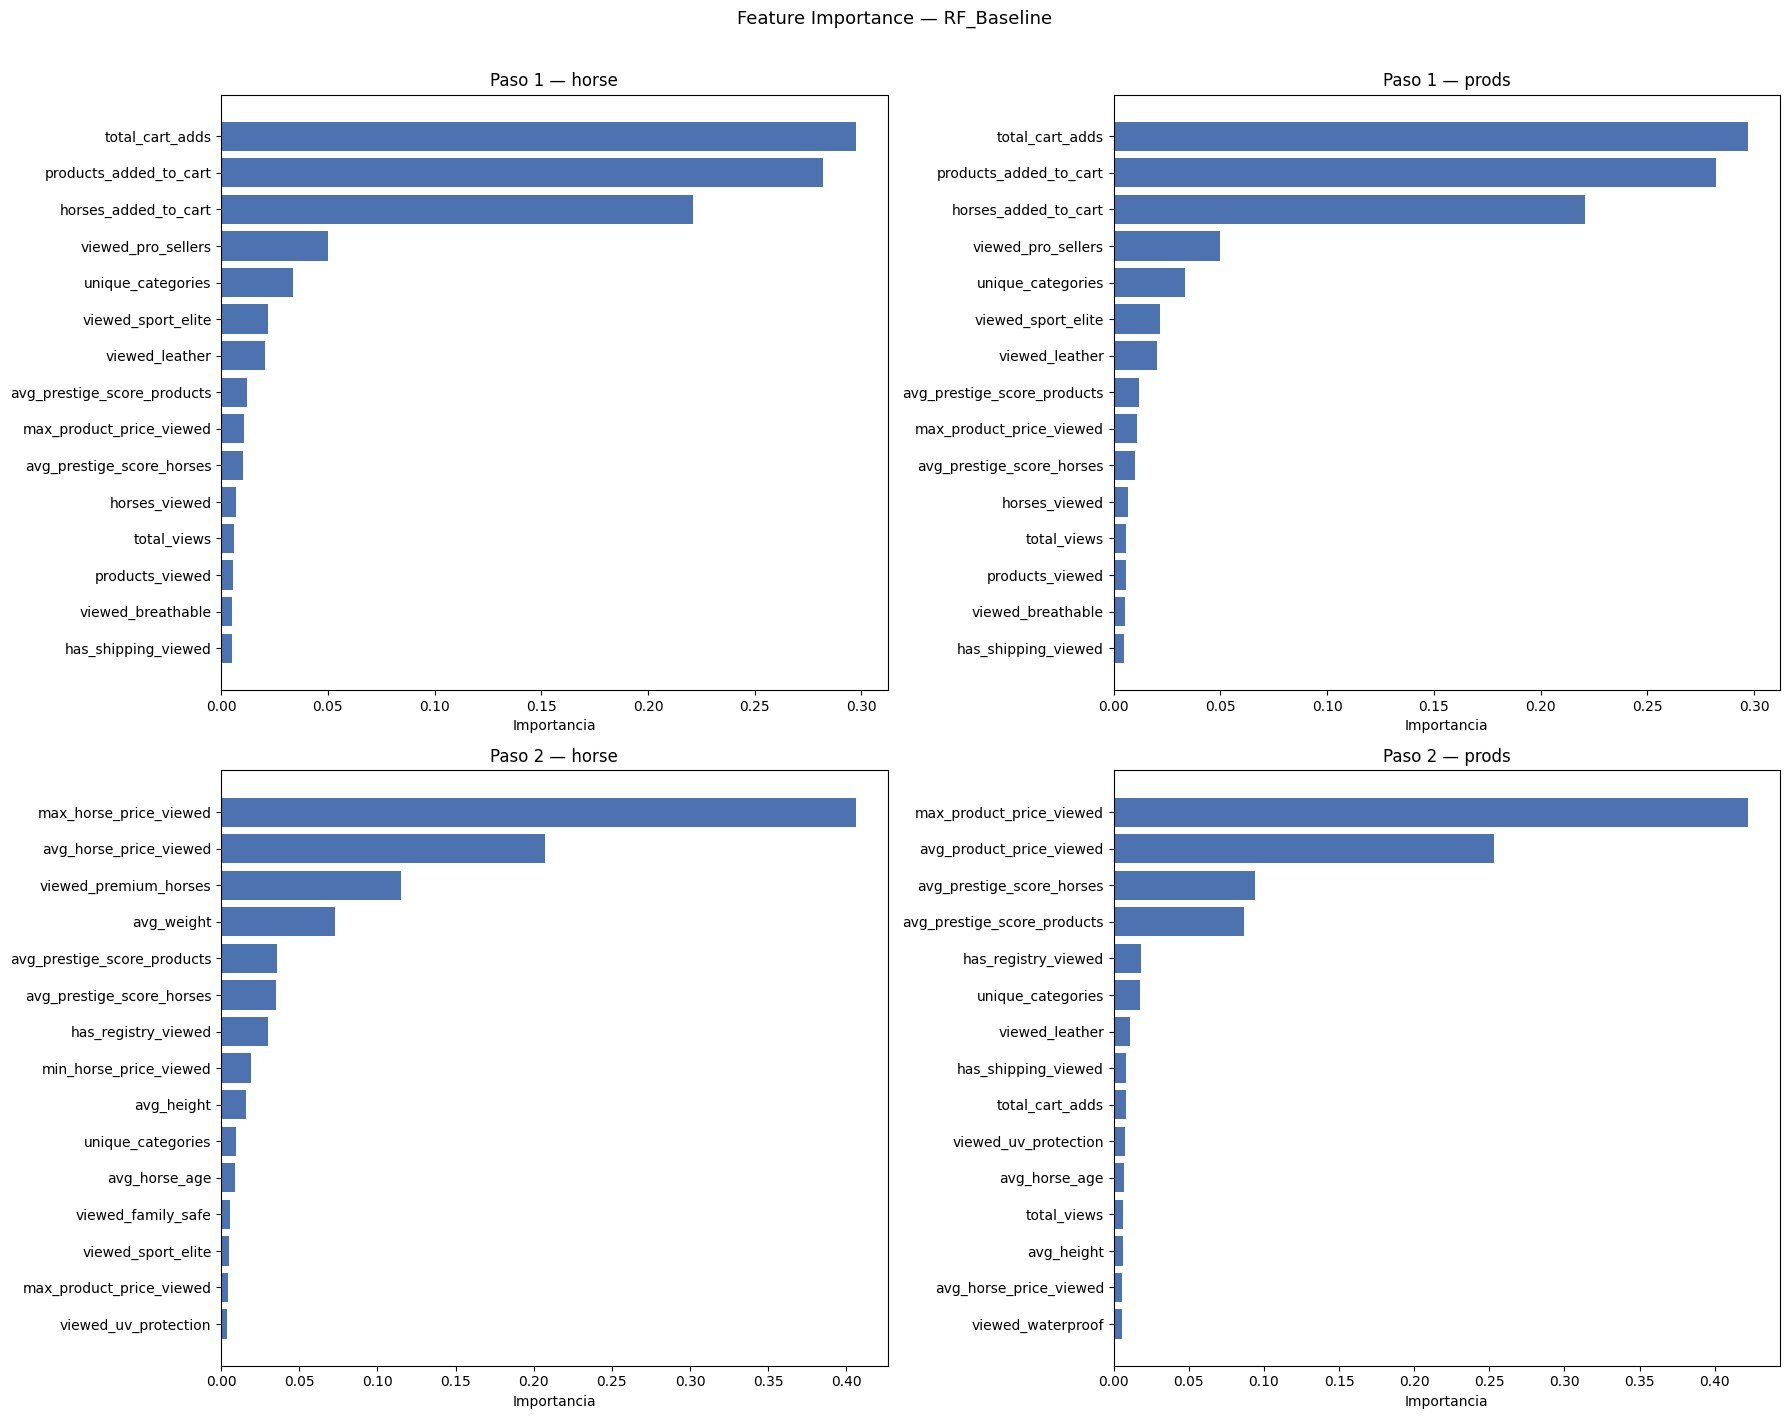

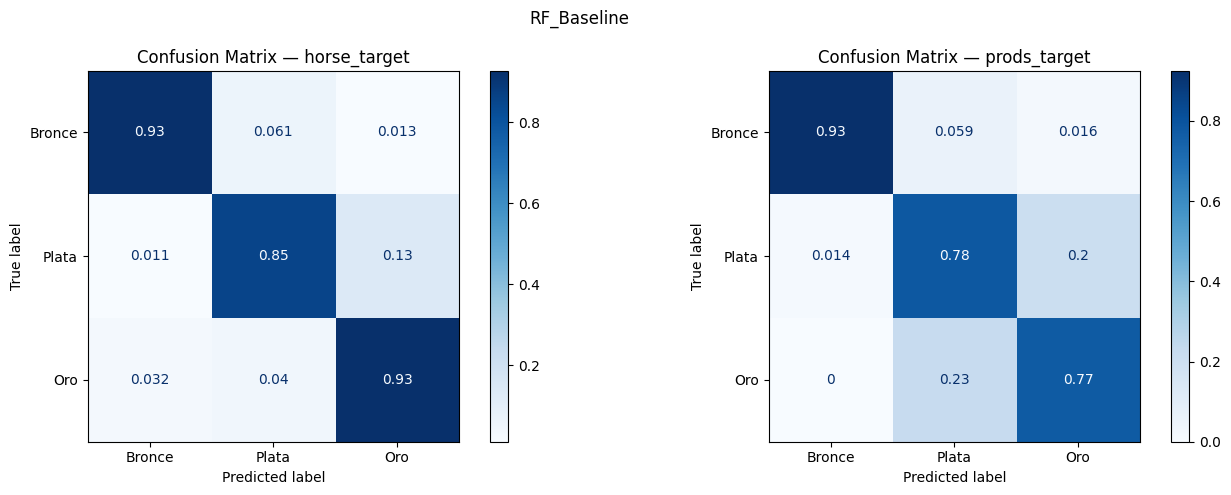

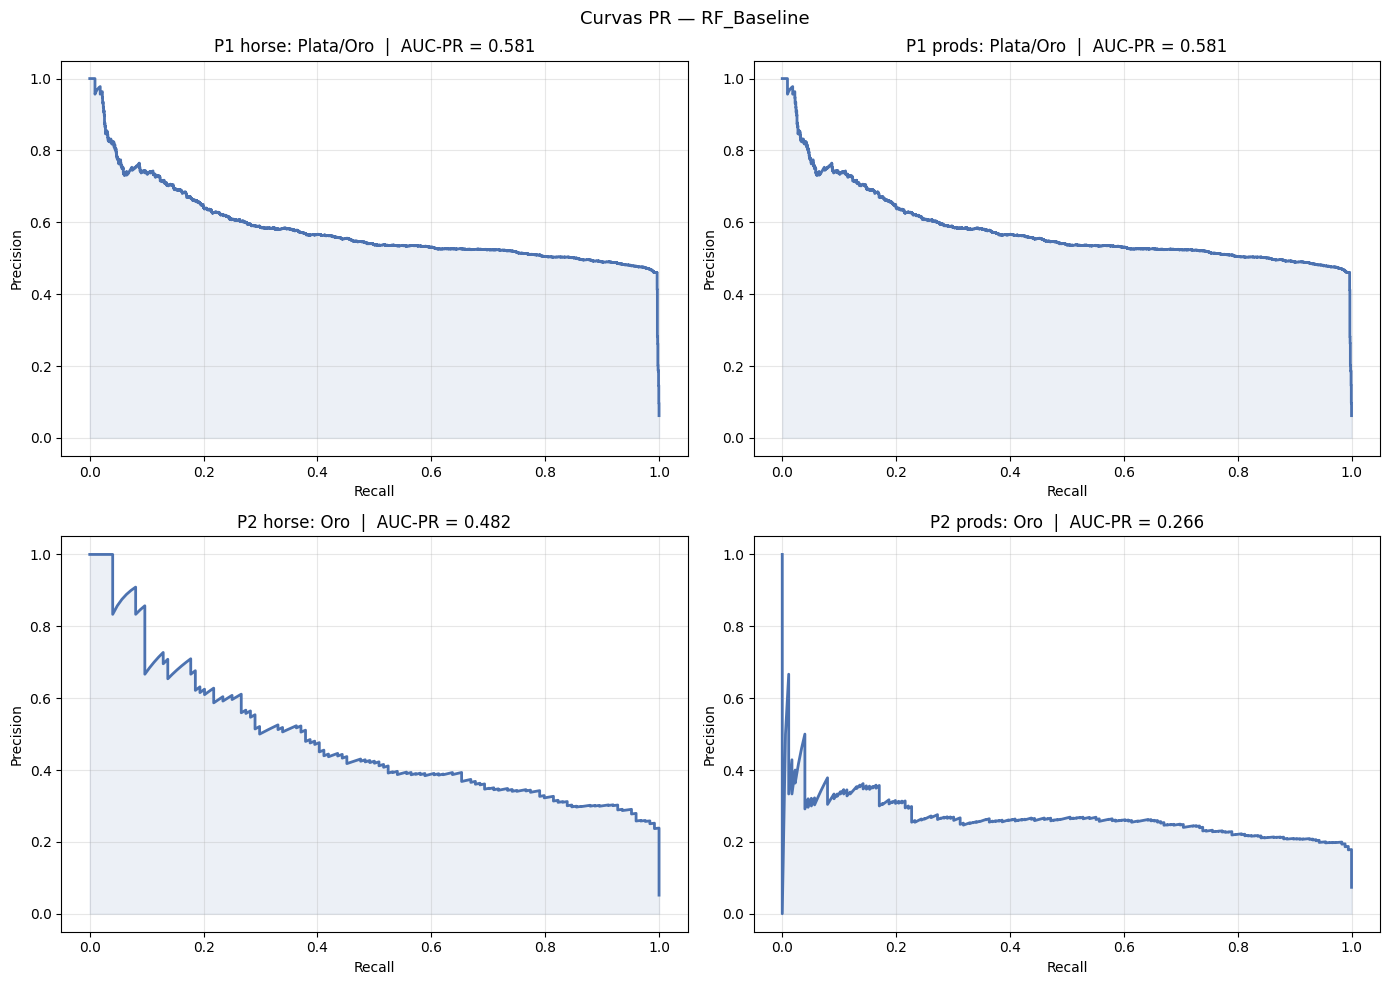

\Run logueado: RF_Baseline  |  run_id: 6e9ea69717a048d4a7dad5aa2096add9
🏃 View run RF_Baseline at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4/runs/6e9ea69717a048d4a7dad5aa2096add9
🧪 View experiment at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4

  Chequeo Overfitting — RF Baseline
─────────────────────────────────────────────────────────────────
Paso                 F2 Train    F2 Test      Gap  Status
─────────────────────────────────────────────────────────────────
P1 — horse             0.9800     0.8069   0.1731  overfit
P1 — prods             0.9800     0.8069   0.1731  overfit
P2 — horse             0.9700     0.6439   0.3261  overfit
P2 — prods             0.9421     0.5239   0.4182  overfit


In [73]:
run_id_rf_base = loguear_run_mlflow(
    run_name    = 'RF_Baseline',
    model_type  = 'RandomForest',
    params_p1   = rf_base_params,
    params_p2   = rf_base_params,
    p1h=rf_base_p1h, p1p=rf_base_p1p,
    p2h=rf_base_p2h, p2p=rf_base_p2p,
    metricas    = metricas_rf_base,
    X_train_p1  = X_p1h_bal,
    X_train_p2h = X_p2h_bal,
    X_train_p2p = X_p2p_bal,
)

check_overfitting([
    ('P1 — horse', rf_base_p1h, X_p1h_bal, y_p1h_bal, X_test, y_test_p1_horse),
    ('P1 — prods', rf_base_p1p, X_p1p_bal, y_p1p_bal, X_test, y_test_p1_prods),
    ('P2 — horse', rf_base_p2h, X_p2h_bal, y_p2h_bal,
     X_test[mask_test_p2_horse], y_test_p2_horse),
    ('P2 — prods', rf_base_p2p, X_p2p_bal, y_p2p_bal,
     X_test[mask_test_p2_prods], y_test_p2_prods),
], 'RF Baseline')

### 2 · Random Forest — Tuning

RandomizedCV optimizando F2-score con CV estratificado.


In [74]:
# RandomizedSearchCV en lugar de GridSearchCV para agilizar tiempo de tuneo
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist_rf = {
    'max_depth':        [4, 6, 8],
    'min_samples_leaf': [30, 75],
    'n_estimators':     [150, 300],
    'max_features':     ['sqrt', 0.5],
}

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def tune_rf(X_tr, y_tr, label, n_iter=12, sample_frac=0.4):
    # Submuestreamos para acelerar — suficiente para encontrar la región óptima
    idx = np.random.default_rng(42).choice(
        len(X_tr), size=int(len(X_tr) * sample_frac), replace=False
    )
    X_sub = X_tr.iloc[idx] if hasattr(X_tr, 'iloc') else X_tr[idx]
    y_sub = y_tr.iloc[idx] if hasattr(y_tr, 'iloc') else y_tr[idx]

    rs = RandomizedSearchCV(
        RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        param_dist_rf, n_iter=n_iter, scoring=f2_scorer,
        cv=cv3, n_jobs=-1, verbose=1, random_state=42
    )
    rs.fit(X_sub, y_sub)
    best = rs.best_params_
    print(f'{label:<12} → {best}  CV F2: {rs.best_score_:.4f}')

    # Reentrenamos con los best params sobre el dataset completo
    final_model = RandomForestClassifier(
        **best, class_weight='balanced', random_state=42, n_jobs=-1
    )
    final_model.fit(X_tr, y_tr)
    return final_model, best

print('── Paso 1 ──')
rf_tune_p1h, params_rf_p1h = tune_rf(X_p1h_bal, y_p1h_bal, 'P1 horse')
rf_tune_p1p, params_rf_p1p = tune_rf(X_p1p_bal, y_p1p_bal, 'P1 prods')
print('\n── Paso 2 ──')
rf_tune_p2h, params_rf_p2h = tune_rf(X_p2h_bal, y_p2h_bal, 'P2 horse')
rf_tune_p2p, params_rf_p2p = tune_rf(X_p2p_bal, y_p2p_bal, 'P2 prods')
print('\nTuning RF completo.')

── Paso 1 ──
Fitting 3 folds for each of 12 candidates, totalling 36 fits
P1 horse     → {'n_estimators': 300, 'min_samples_leaf': 30, 'max_features': 0.5, 'max_depth': 8}  CV F2: 0.9795
Fitting 3 folds for each of 12 candidates, totalling 36 fits
P1 prods     → {'n_estimators': 300, 'min_samples_leaf': 30, 'max_features': 0.5, 'max_depth': 8}  CV F2: 0.9795

── Paso 2 ──
Fitting 3 folds for each of 12 candidates, totalling 36 fits
P2 horse     → {'n_estimators': 300, 'min_samples_leaf': 30, 'max_features': 0.5, 'max_depth': 4}  CV F2: 0.9658
Fitting 3 folds for each of 12 candidates, totalling 36 fits
P2 prods     → {'n_estimators': 300, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 6}  CV F2: 0.9305

Tuning RF completo.


In [75]:
metricas_rf_tune = calcular_metricas_cascada(rf_tune_p1h, rf_tune_p1p,
                                              rf_tune_p2h, rf_tune_p2p)

for t, m in metricas_rf_tune.items():
    print(f'{t}: F2 macro={m["f2_macro"]:.4f} | F2 Oro={m["f2_lead_oro"]:.4f} '
          f'| Gap P2={m["overfit_gap_p2"]:.4f}')

horse: F2 macro=0.6814 | F2 Oro=0.3831 | Gap P2=-0.0009
prods: F2 macro=0.6538 | F2 Oro=0.3557 | Gap P2=0.0288


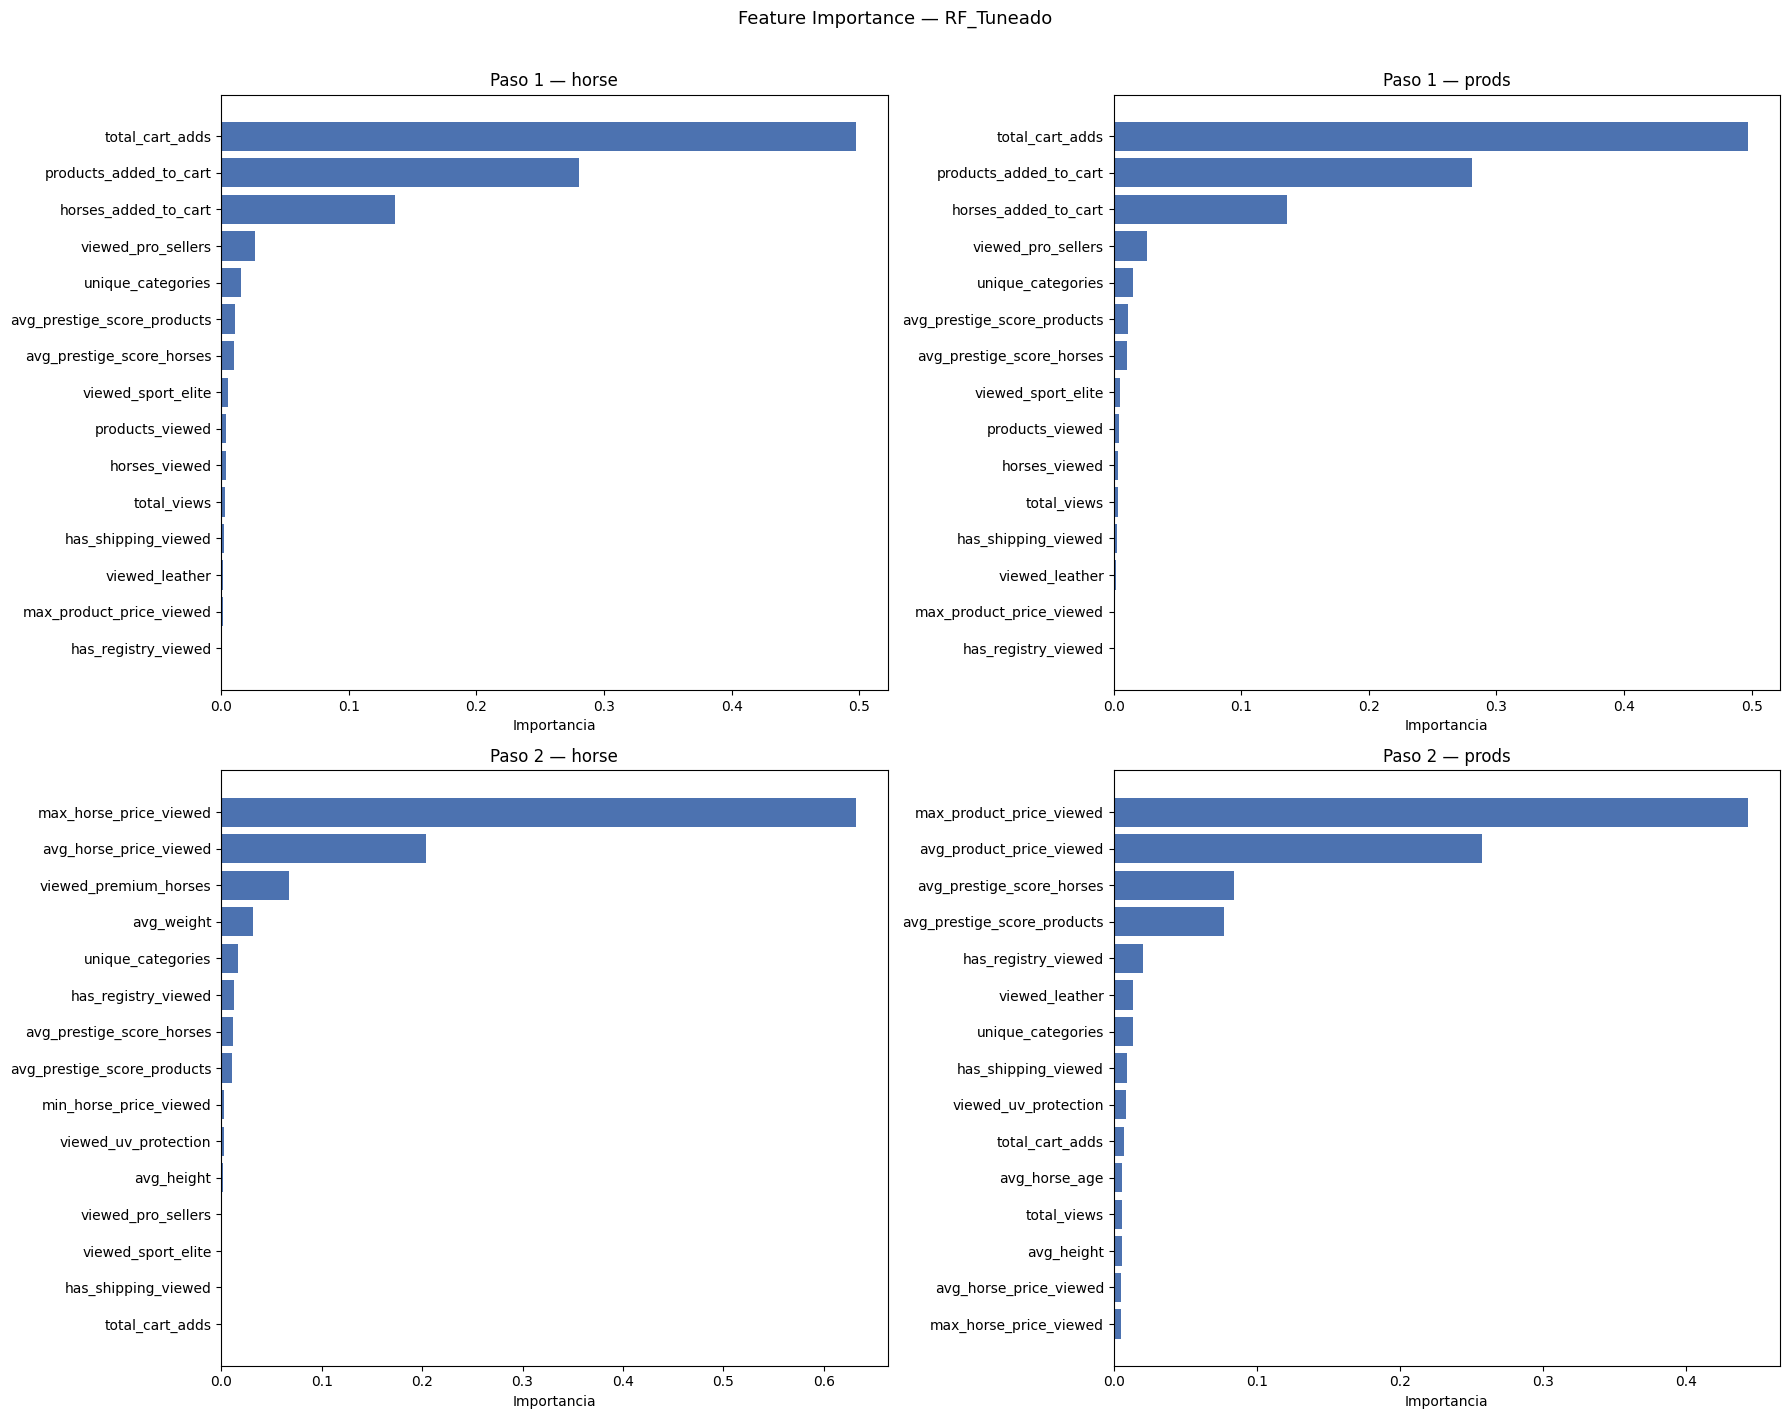

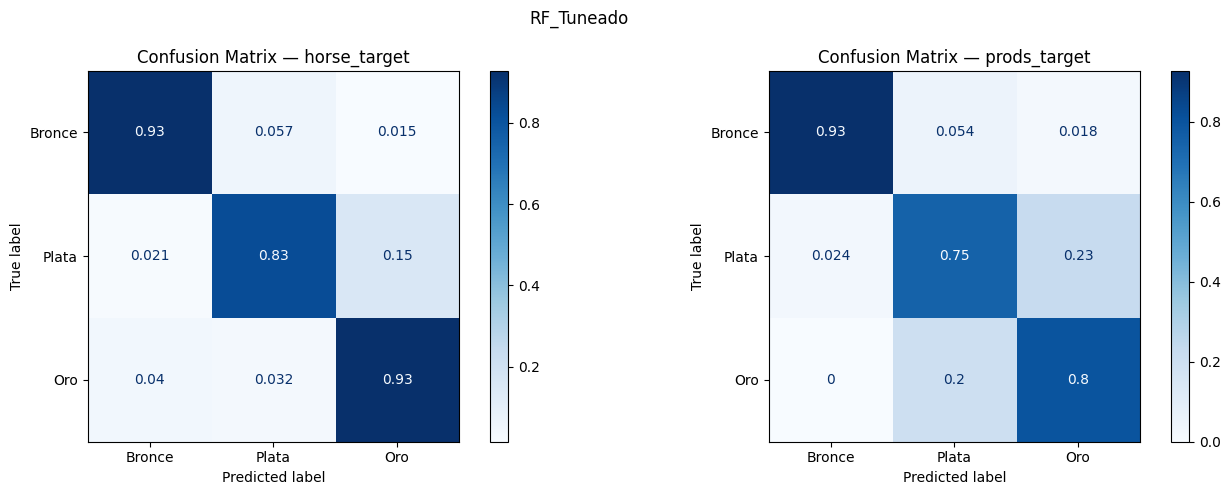

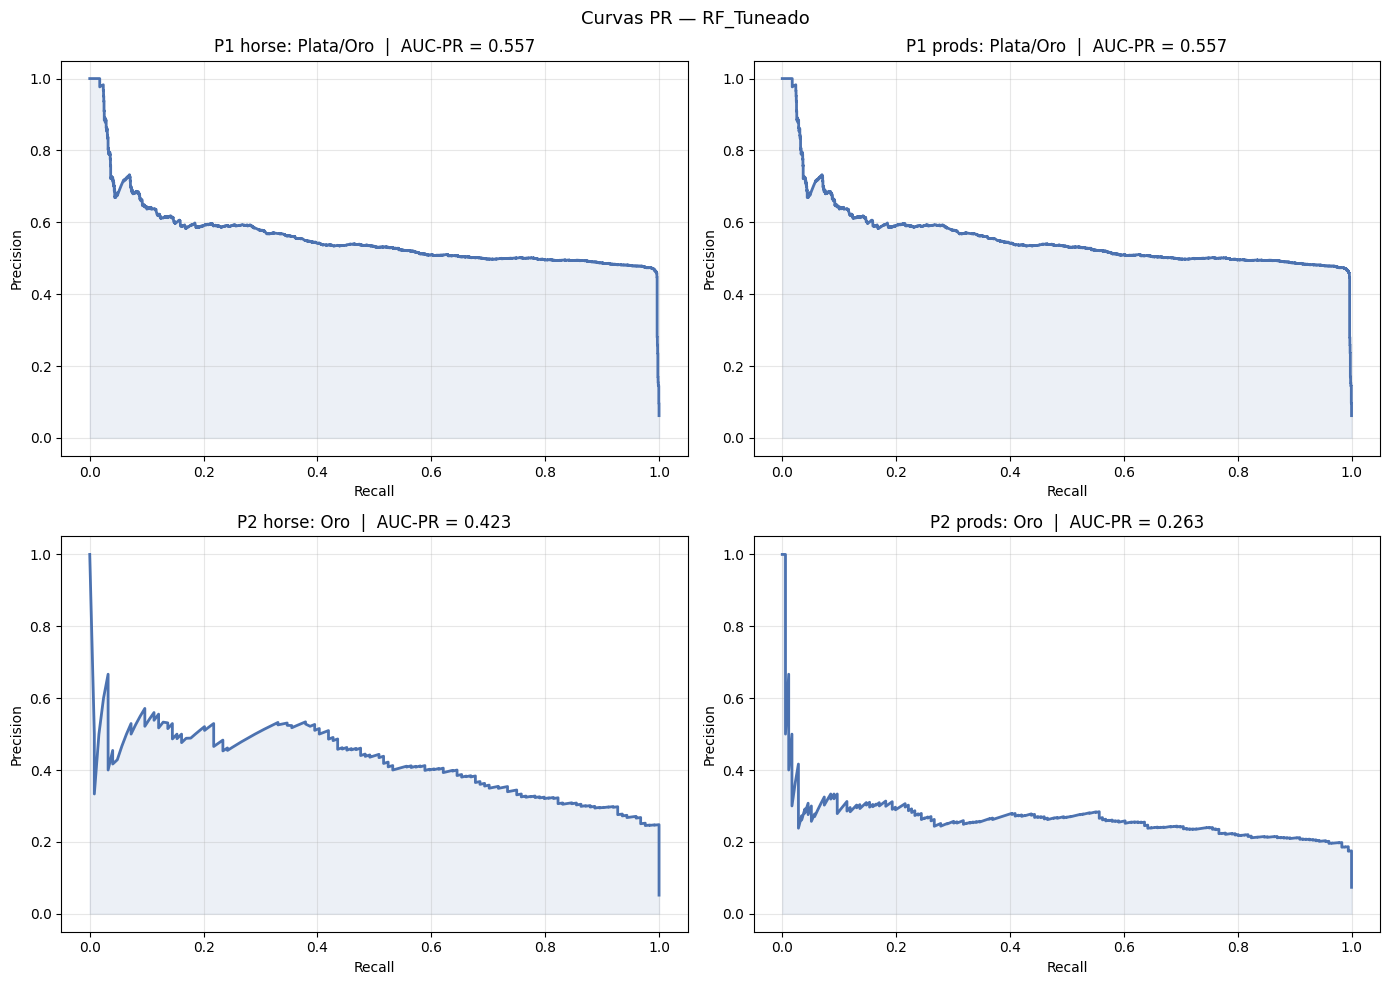

\Run logueado: RF_Tuneado  |  run_id: 96d1746dffcc4e7fa051f780062bb2b4
🏃 View run RF_Tuneado at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4/runs/96d1746dffcc4e7fa051f780062bb2b4
🧪 View experiment at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4

  Chequeo Overfitting — RF Tuneado
─────────────────────────────────────────────────────────────────
Paso                 F2 Train    F2 Test      Gap  Status
─────────────────────────────────────────────────────────────────
P1 — horse             0.9822     0.8063   0.1759  overfit
P1 — prods             0.9822     0.8063   0.1759  overfit
P2 — horse             0.9674     0.6173   0.3501  overfit
P2 — prods             0.9419     0.5214   0.4204  overfit


In [76]:
# Logueamos los best params del GridSearch 
run_id_rf_tune = loguear_run_mlflow(
    run_name    = 'RF_Tuneado',
    model_type  = 'RandomForest',
    params_p1   = params_rf_p1h,   # best params paso 1
    params_p2   = params_rf_p2h,   # best params paso 2
    p1h=rf_tune_p1h, p1p=rf_tune_p1p,
    p2h=rf_tune_p2h, p2p=rf_tune_p2p,
    metricas    = metricas_rf_tune,
    X_train_p1  = X_p1h_bal,
    X_train_p2h = X_p2h_bal,
    X_train_p2p = X_p2p_bal,
)

check_overfitting([
    ('P1 — horse', rf_tune_p1h, X_p1h_bal, y_p1h_bal, X_test, y_test_p1_horse),
    ('P1 — prods', rf_tune_p1p, X_p1p_bal, y_p1p_bal, X_test, y_test_p1_prods),
    ('P2 — horse', rf_tune_p2h, X_p2h_bal, y_p2h_bal,
     X_test[mask_test_p2_horse], y_test_p2_horse),
    ('P2 — prods', rf_tune_p2p, X_p2p_bal, y_p2p_bal,
     X_test[mask_test_p2_prods], y_test_p2_prods),
], 'RF Tuneado')

### 3 · XGBoost

XGBoost usa boosting iterativo, regularización L1/L2 nativa y `scale_pos_weight` para manejar el desbalance sin SMOTE.

In [77]:
xgb_base_params = dict(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='aucpr',
    tree_method='hist',   
    random_state=42,
    n_jobs=-1
)

xgb_base_p1h = XGBClassifier(**xgb_base_params, scale_pos_weight=spw_p1h).fit(X_train, y_train_p1_horse)
xgb_base_p1p = XGBClassifier(**xgb_base_params, scale_pos_weight=spw_p1p).fit(X_train, y_train_p1_prods)
xgb_base_p2h = XGBClassifier(**xgb_base_params, scale_pos_weight=spw_p2h).fit(X_p2h_raw, y_p2h_raw)
xgb_base_p2p = XGBClassifier(**xgb_base_params, scale_pos_weight=spw_p2p).fit(X_p2p_raw, y_p2p_raw)

metricas_xgb_base = calcular_metricas_cascada(xgb_base_p1h, xgb_base_p1p,
                                               xgb_base_p2h, xgb_base_p2p)

for t, m in metricas_xgb_base.items():
    print(f'{t}: F2 macro={m["f2_macro"]:.4f} | F2 Oro={m["f2_lead_oro"]:.4f} '
          f'| Gap P2={m["overfit_gap_p2"]:.4f}')

horse: F2 macro=0.7171 | F2 Oro=0.4538 | Gap P2=0.1175
prods: F2 macro=0.6694 | F2 Oro=0.3784 | Gap P2=0.1630


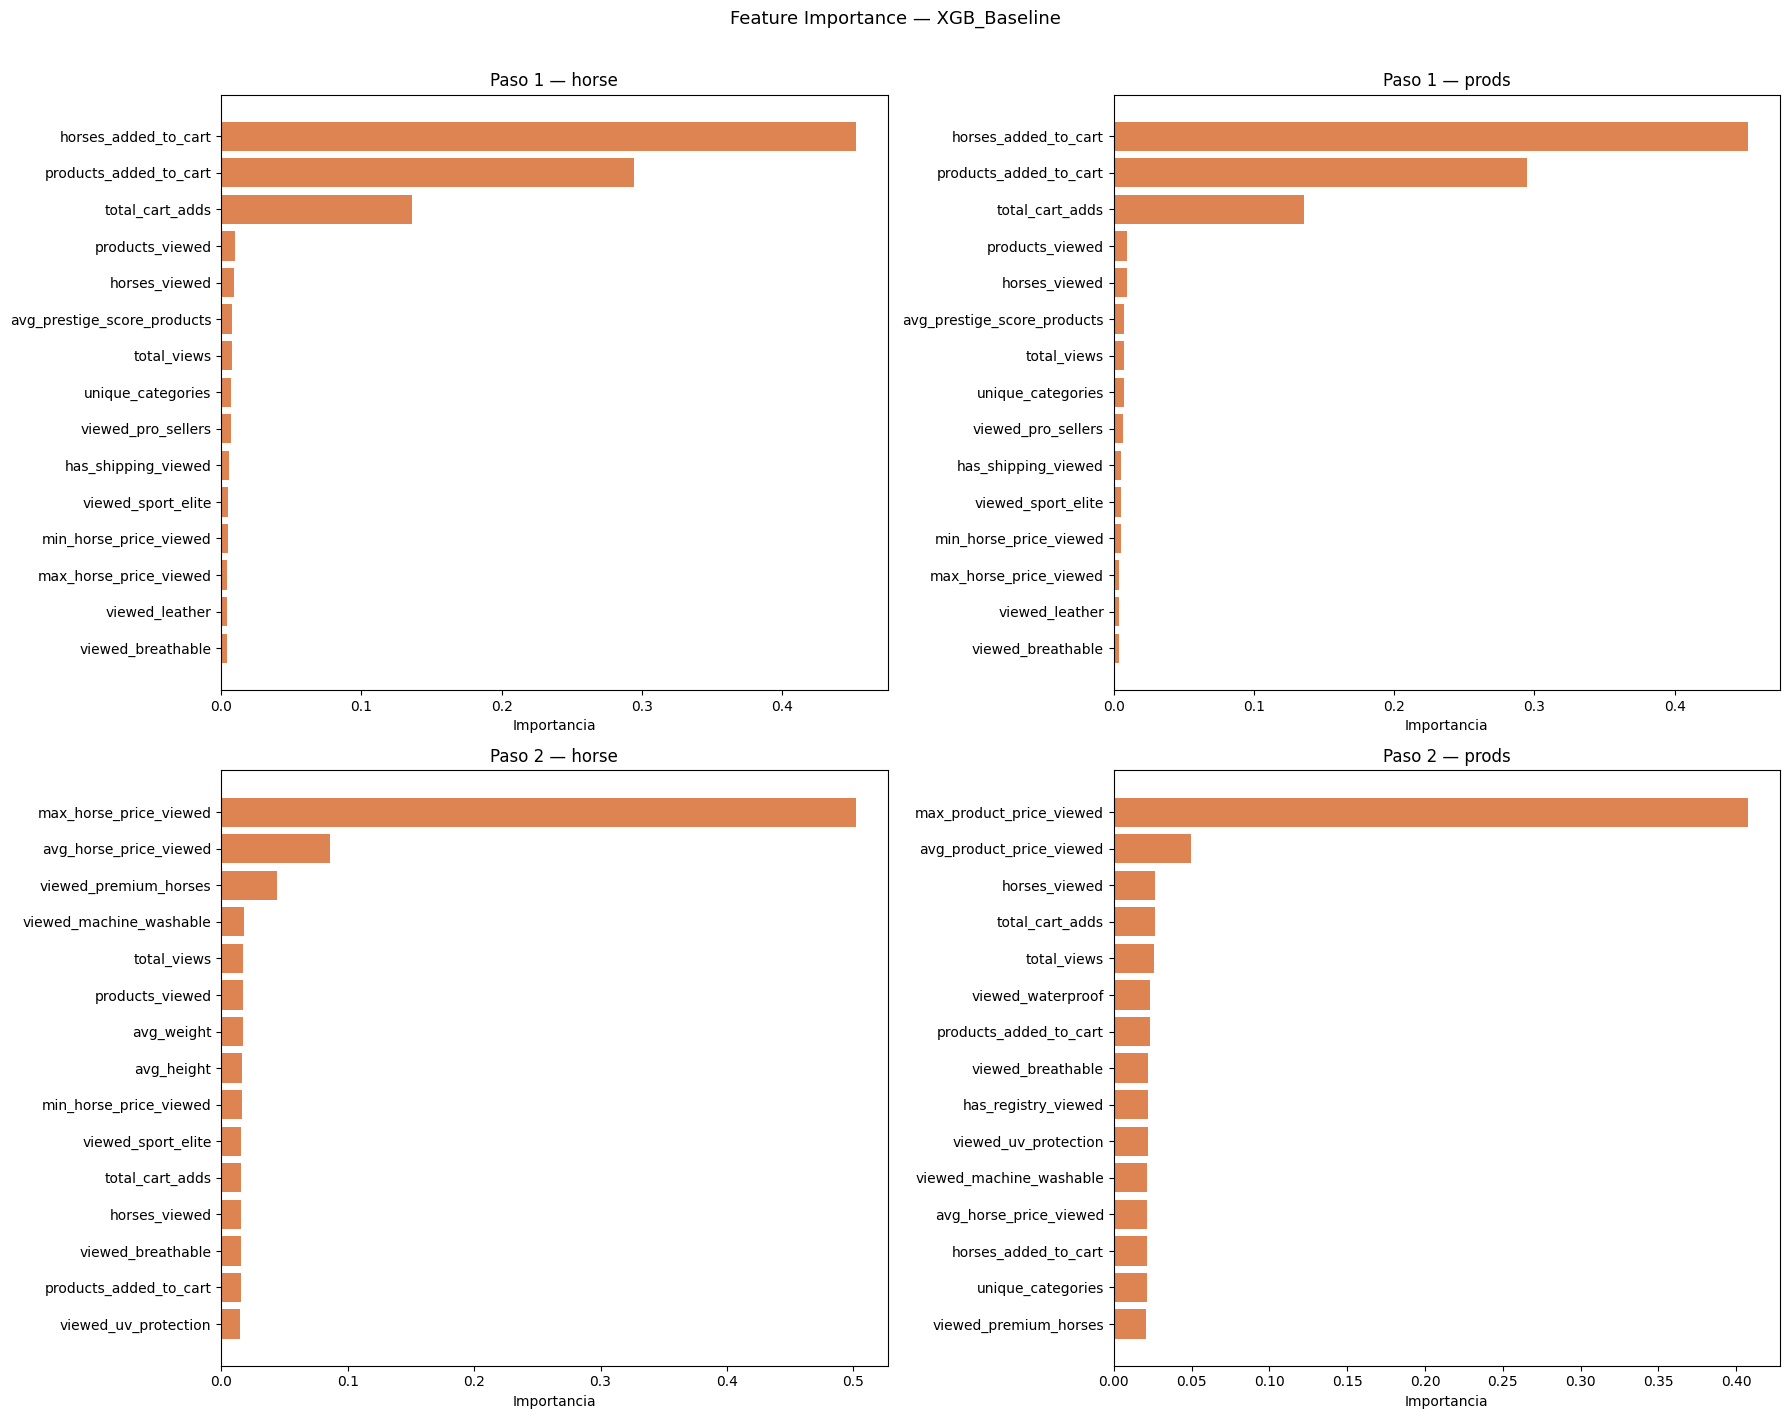

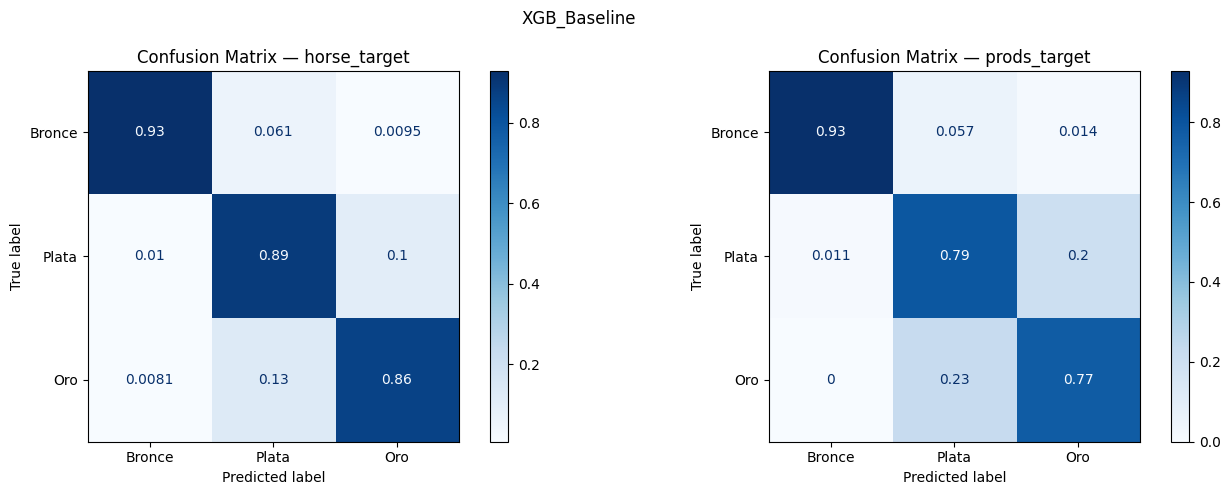

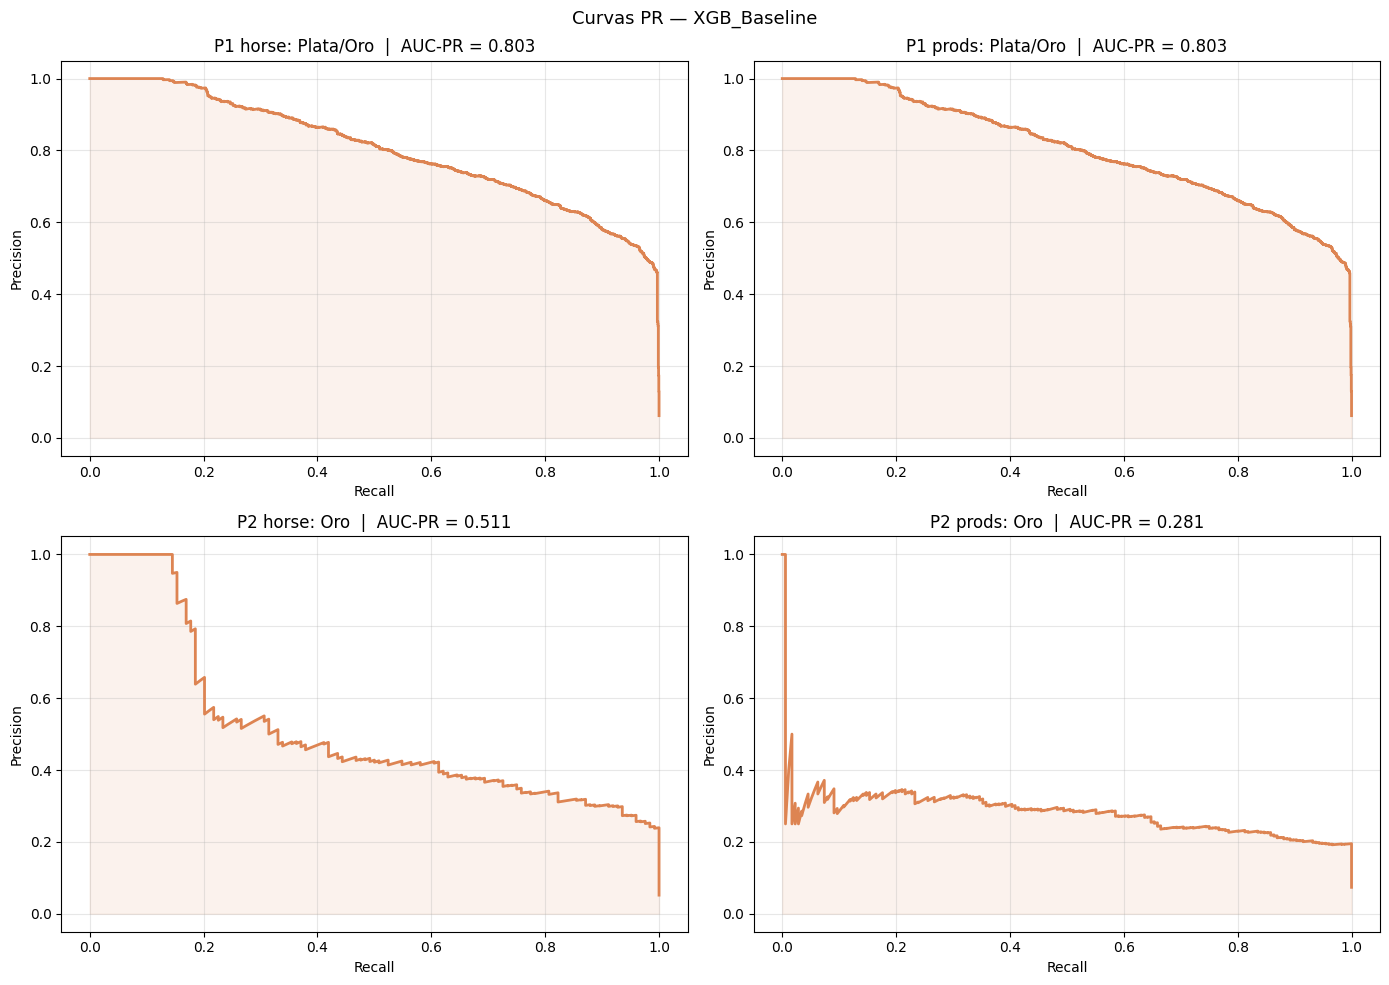

\Run logueado: XGB_Baseline  |  run_id: 74f1707c89964d69866d337f07624075
🏃 View run XGB_Baseline at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4/runs/74f1707c89964d69866d337f07624075
🧪 View experiment at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4

  Chequeo Overfitting — XGB Baseline
─────────────────────────────────────────────────────────────────
Paso                 F2 Train    F2 Test      Gap  Status
─────────────────────────────────────────────────────────────────
P1 — horse             0.8175     0.8159   0.0015  OK
P1 — prods             0.8175     0.8159   0.0015  OK
P2 — horse             0.7619     0.6444   0.1175  overfit
P2 — prods             0.6917     0.5288   0.1630  overfit


In [78]:
run_id_xgb_base = loguear_run_mlflow(
    run_name    = 'XGB_Baseline',
    model_type  = 'XGBoost',
    params_p1   = {**xgb_base_params, 'scale_pos_weight': spw_p1h},
    params_p2   = {**xgb_base_params, 'scale_pos_weight': spw_p2h},
    p1h=xgb_base_p1h, p1p=xgb_base_p1p,
    p2h=xgb_base_p2h, p2p=xgb_base_p2p,
    metricas    = metricas_xgb_base,
    X_train_p1  = X_train,
    X_train_p2h = X_p2h_raw,
    X_train_p2p = X_p2p_raw,
)

check_overfitting([
    ('P1 — horse', xgb_base_p1h, X_train, y_train_p1_horse, X_test, y_test_p1_horse),
    ('P1 — prods', xgb_base_p1p, X_train, y_train_p1_prods, X_test, y_test_p1_prods),
    ('P2 — horse', xgb_base_p2h, X_p2h_raw, y_p2h_raw,
     X_test[mask_test_p2_horse], y_test_p2_horse),
    ('P2 — prods', xgb_base_p2p, X_p2p_raw, y_p2p_raw,
     X_test[mask_test_p2_prods], y_test_p2_prods),
], 'XGB Baseline')

### 4 · XGBoost — Tuning

In [79]:
# 1. Sin device='cuda' — CPU pura con tree_method='hist' (el más rápido en CPU)
# 2. Pipeline(SMOTE → XGB) para Paso 2: evita leakage de SMOTE en los folds de CV

from imblearn.pipeline import Pipeline as ImbPipeline

param_dist_xgb = {
    'max_depth':        [3, 4, 5],
    'learning_rate':    [0.01, 0.05, 0.1],
    'n_estimators':     [200, 400],
    'subsample':        [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha':        [0, 0.1, 1.0],
    'reg_lambda':       [1.0, 5.0],
}

# Para el tuning de Paso 2 usamos Pipeline SMOTE+XGB
# Los params del XGB dentro del pipeline llevan prefijo 'xgb__'
param_dist_xgb_p2 = {f'xgb__{k}': v for k, v in param_dist_xgb.items()}

def tune_xgb_p1(X_tr, y_tr, spw, label, n_iter=15):
    """Paso 1: datos ya balanceados con scale_pos_weight, sin SMOTE."""
    rs = RandomizedSearchCV(
        XGBClassifier(
            scale_pos_weight=spw,
            eval_metric='aucpr',
            tree_method='hist',
            random_state=42,
            n_jobs=-1
        ),
        param_dist_xgb, n_iter=n_iter, scoring=f2_scorer,
        cv=cv3, n_jobs=-1, verbose=0, random_state=42
    )
    rs.fit(X_tr, y_tr)
    best = rs.best_params_
    print(f'{label:<12} → {best}  CV F2: {rs.best_score_:.4f}')
    final = XGBClassifier(
        **best, scale_pos_weight=spw,
        eval_metric='aucpr', tree_method='hist',
        random_state=42, n_jobs=-1
    )
    final.fit(X_tr, y_tr)
    return final, best

def tune_xgb_p2(X_tr, y_tr, spw, label, n_iter=15):
    """Paso 2: Pipeline SMOTE+XGB para evitar leakage en CV."""
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(
            scale_pos_weight=spw,
            eval_metric='aucpr',
            tree_method='hist',
            random_state=42,
            n_jobs=-1
        ))
    ])
    rs = RandomizedSearchCV(
        pipe, param_dist_xgb_p2, n_iter=n_iter, scoring=f2_scorer,
        cv=cv3, n_jobs=-1, verbose=0, random_state=42
    )
    rs.fit(X_tr, y_tr)
    best_pipe_params = rs.best_params_
    best = {k.replace('xgb__', ''): v for k, v in best_pipe_params.items()}
    print(f'{label:<12} → {best}  CV F2: {rs.best_score_:.4f}')
    # Reentrenamos el modelo final sobre dataset completo 
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    final = XGBClassifier(
        **best, scale_pos_weight=spw,
        eval_metric='aucpr', tree_method='hist',
        random_state=42, n_jobs=-1
    )
    final.fit(X_bal, y_bal)
    return final, best

print('── Paso 1 ──')
xgb_tune_p1h, params_xgb_p1h = tune_xgb_p1(X_train, y_train_p1_horse, spw_p1h, 'P1 horse')
xgb_tune_p1p, params_xgb_p1p = tune_xgb_p1(X_train, y_train_p1_prods, spw_p1p, 'P1 prods')
print('\n── Paso 2 ──')
xgb_tune_p2h, params_xgb_p2h = tune_xgb_p2(X_p2h_raw, y_p2h_raw, spw_p2h, 'P2 horse')
xgb_tune_p2p, params_xgb_p2p = tune_xgb_p2(X_p2p_raw, y_p2p_raw, spw_p2p, 'P2 prods')
print('\nTuning XGBoost completo.')

── Paso 1 ──
P1 horse     → {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}  CV F2: 0.8234
P1 prods     → {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}  CV F2: 0.8234

── Paso 2 ──
P2 horse     → {'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}  CV F2: 0.6091
P2 prods     → {'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alpha': 1.0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}  CV F2: 0.5416

Tuning XGBoost completo.


In [80]:
metricas_xgb_tune = calcular_metricas_cascada(xgb_tune_p1h, xgb_tune_p1p,
                                               xgb_tune_p2h, xgb_tune_p2p)

for t, m in metricas_xgb_tune.items():
    print(f'{t}: F2 macro={m["f2_macro"]:.4f} | F2 Oro={m["f2_lead_oro"]:.4f} '
          f'| Gap P2={m["overfit_gap_p2"]:.4f}')

horse: F2 macro=0.6934 | F2 Oro=0.3914 | Gap P2=0.0031
prods: F2 macro=0.6510 | F2 Oro=0.3612 | Gap P2=0.0071


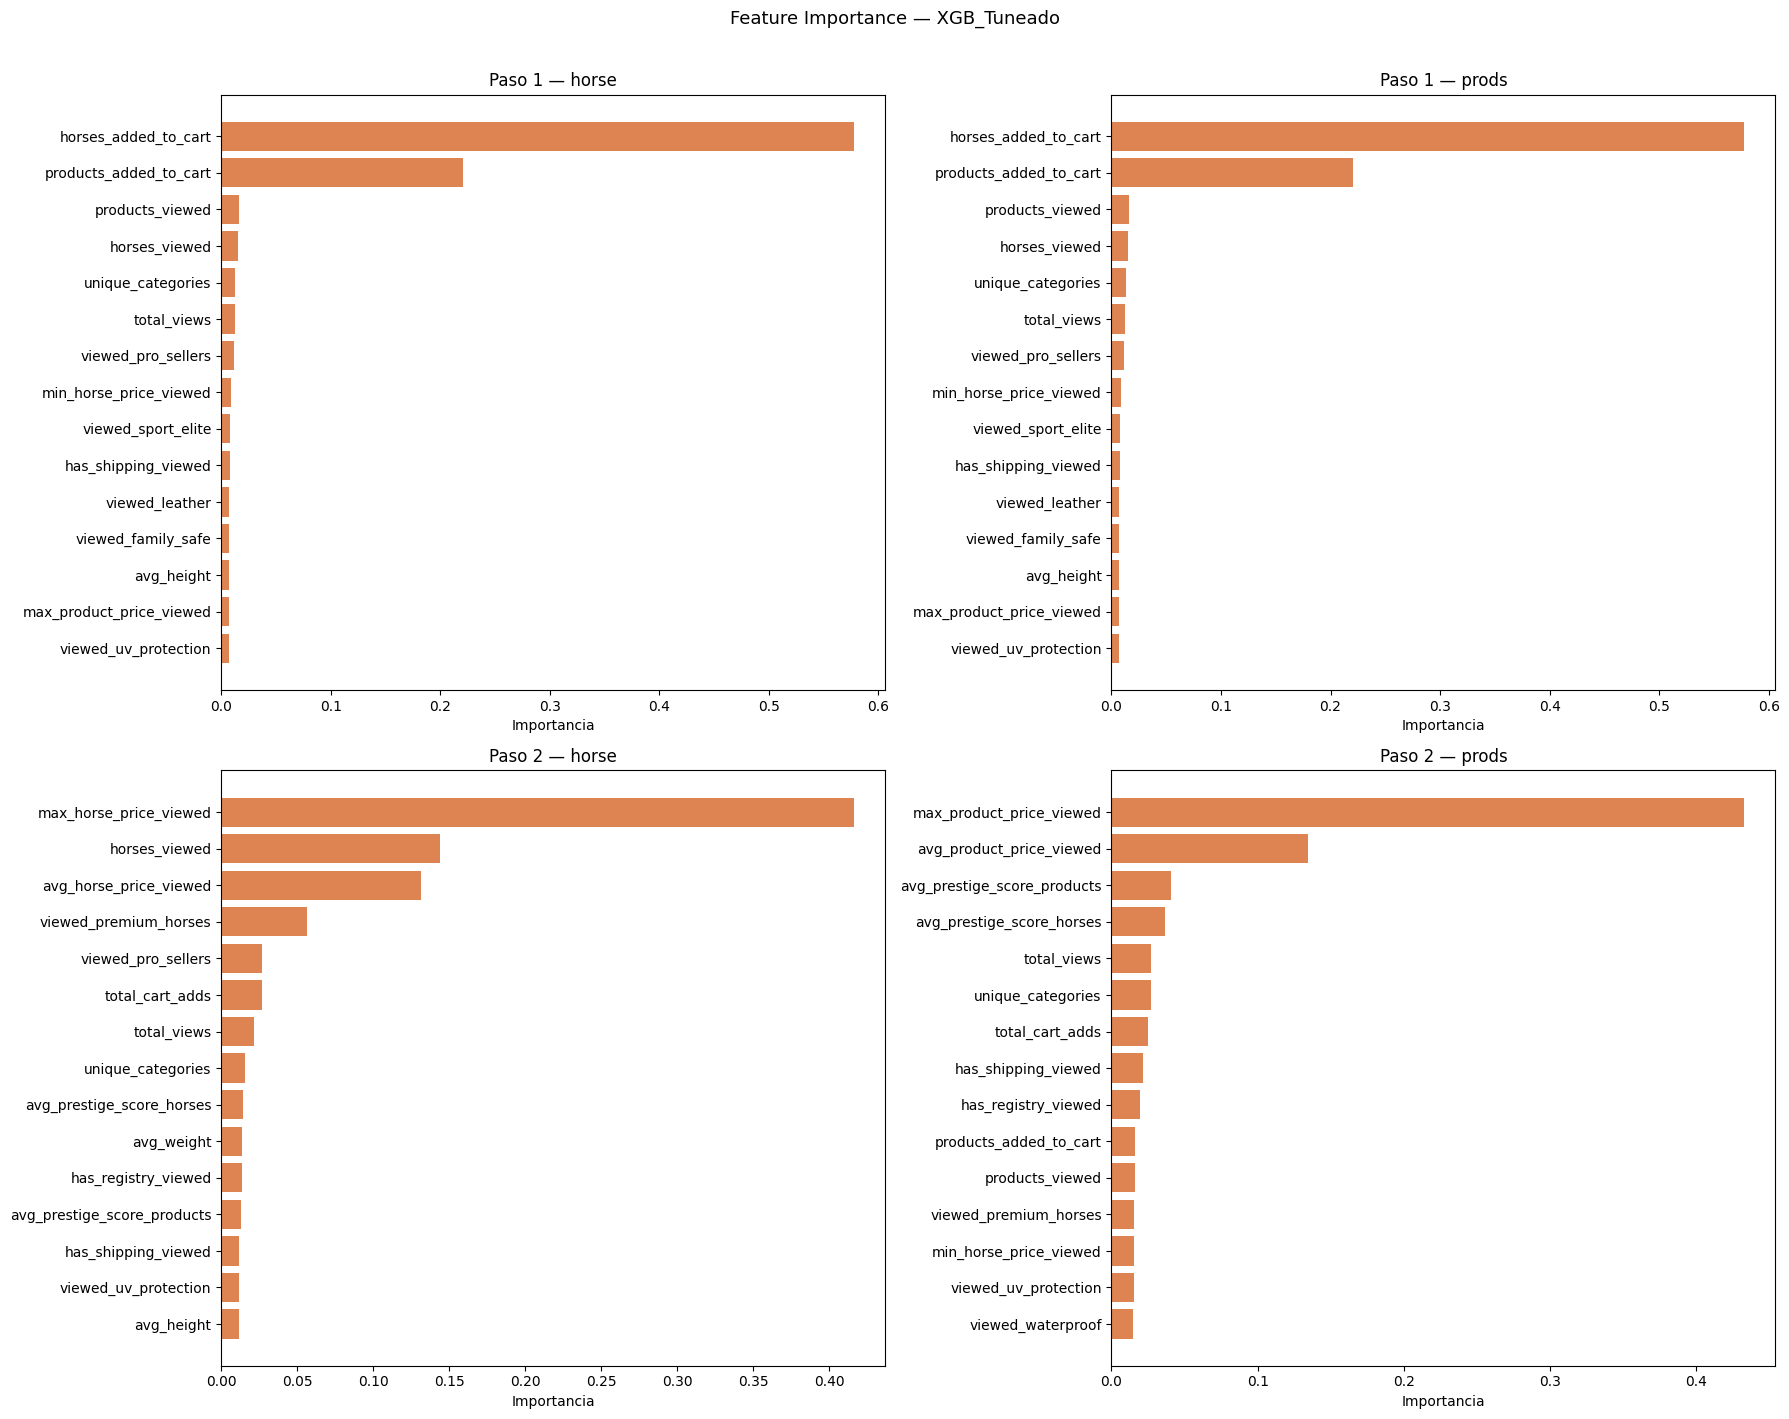

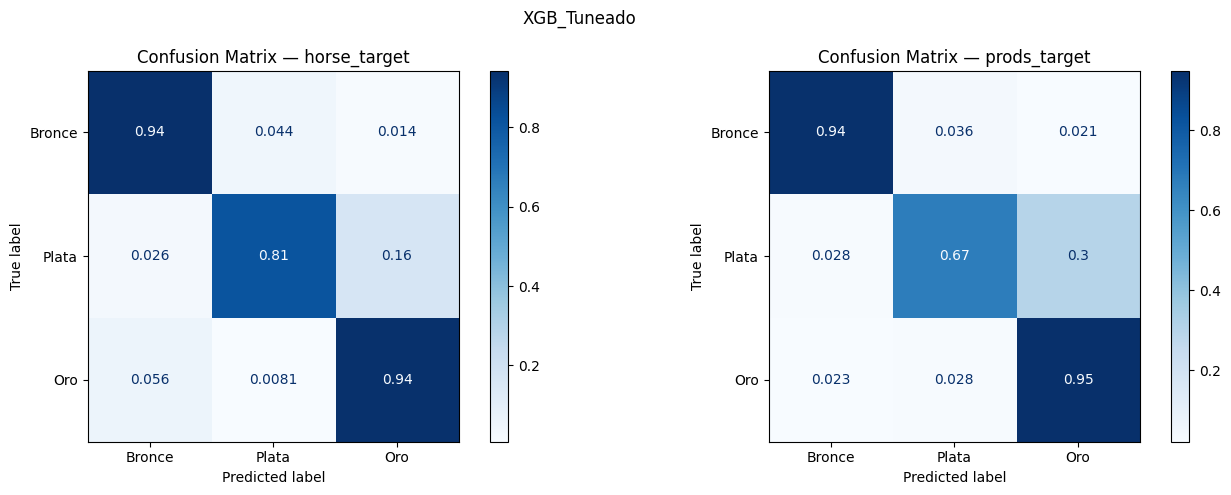

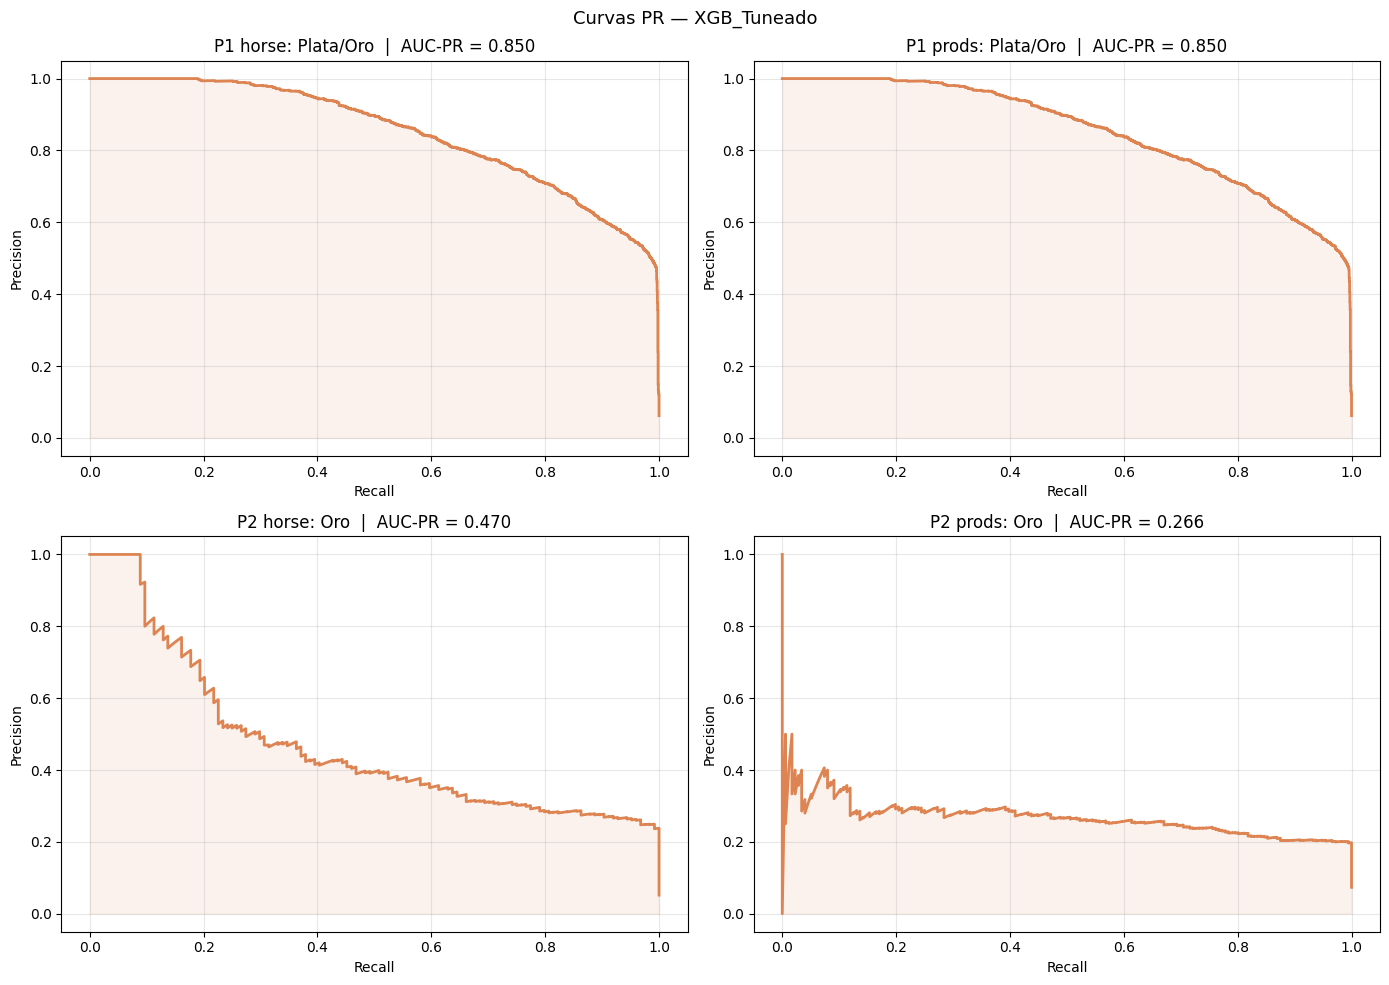

\Run logueado: XGB_Tuneado  |  run_id: 1255814bbf5442a1a02022ffeeab7a91
🏃 View run XGB_Tuneado at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4/runs/1255814bbf5442a1a02022ffeeab7a91
🧪 View experiment at: https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow/#/experiments/4

  Chequeo Overfitting — XGB Tuneado
─────────────────────────────────────────────────────────────────
Paso                 F2 Train    F2 Test      Gap  Status
─────────────────────────────────────────────────────────────────
P1 — horse             0.8616     0.8312   0.0303  OK
P1 — prods             0.8616     0.8312   0.0303  OK
P2 — horse             0.6175     0.6144   0.0031  OK
P2 — prods             0.5569     0.5498   0.0071  OK


In [81]:
run_id_xgb_tune = loguear_run_mlflow(
    run_name    = 'XGB_Tuneado',
    model_type  = 'XGBoost',
    params_p1   = {**params_xgb_p1h, 'scale_pos_weight': spw_p1h},
    params_p2   = {**params_xgb_p2h, 'scale_pos_weight': spw_p2h},
    p1h=xgb_tune_p1h, p1p=xgb_tune_p1p,
    p2h=xgb_tune_p2h, p2p=xgb_tune_p2p,
    metricas    = metricas_xgb_tune,
    X_train_p1  = X_train,
    X_train_p2h = X_p2h_raw,
    X_train_p2p = X_p2p_raw,
)

check_overfitting([
    ('P1 — horse', xgb_tune_p1h, X_train, y_train_p1_horse, X_test, y_test_p1_horse),
    ('P1 — prods', xgb_tune_p1p, X_train, y_train_p1_prods, X_test, y_test_p1_prods),
    ('P2 — horse', xgb_tune_p2h, X_p2h_raw, y_p2h_raw,
     X_test[mask_test_p2_horse], y_test_p2_horse),
    ('P2 — prods', xgb_tune_p2p, X_p2p_raw, y_p2p_raw,
     X_test[mask_test_p2_prods], y_test_p2_prods),
], 'XGB Tuneado')

### 5 · Comparativa final

Todos los runs ya están en DagsHub. Acá los comparamos también localmente con la misma tabla y gráfico.

In [82]:
todos = [
    ('RF  Baseline', metricas_rf_base,   run_id_rf_base),
    ('RF  Tuneado',  metricas_rf_tune,   run_id_rf_tune),
    ('XGB Baseline', metricas_xgb_base,  run_id_xgb_base),
    ('XGB Tuneado',  metricas_xgb_tune,  run_id_xgb_tune),
]

print(f'{"Modelo":<16} {"Target":<15} {"F2 macro":>10} {"F2 Lead Oro":>13} {"Gap P2":>10}')
print('═' * 68)
for nombre, res, run_id in todos:
    for target in ['horse', 'prods']:
        m = res[target]
        print(f'{nombre:<16} {target:<15} '
              f'{m["f2_macro"]:>10.4f} '
              f'{m["f2_lead_oro"]:>13.4f} '
              f'{m["overfit_gap_p2"]:>10.4f}')
    print('─' * 68)

Modelo           Target            F2 macro   F2 Lead Oro     Gap P2
════════════════════════════════════════════════════════════════════
RF  Baseline     horse               0.6943        0.4122     0.0028
RF  Baseline     prods               0.6603        0.3631     0.0309
────────────────────────────────────────────────────────────────────
RF  Tuneado      horse               0.6814        0.3831    -0.0009
RF  Tuneado      prods               0.6538        0.3557     0.0288
────────────────────────────────────────────────────────────────────
XGB Baseline     horse               0.7171        0.4538     0.1175
XGB Baseline     prods               0.6694        0.3784     0.1630
────────────────────────────────────────────────────────────────────
XGB Tuneado      horse               0.6934        0.3914     0.0031
XGB Tuneado      prods               0.6510        0.3612     0.0071
────────────────────────────────────────────────────────────────────


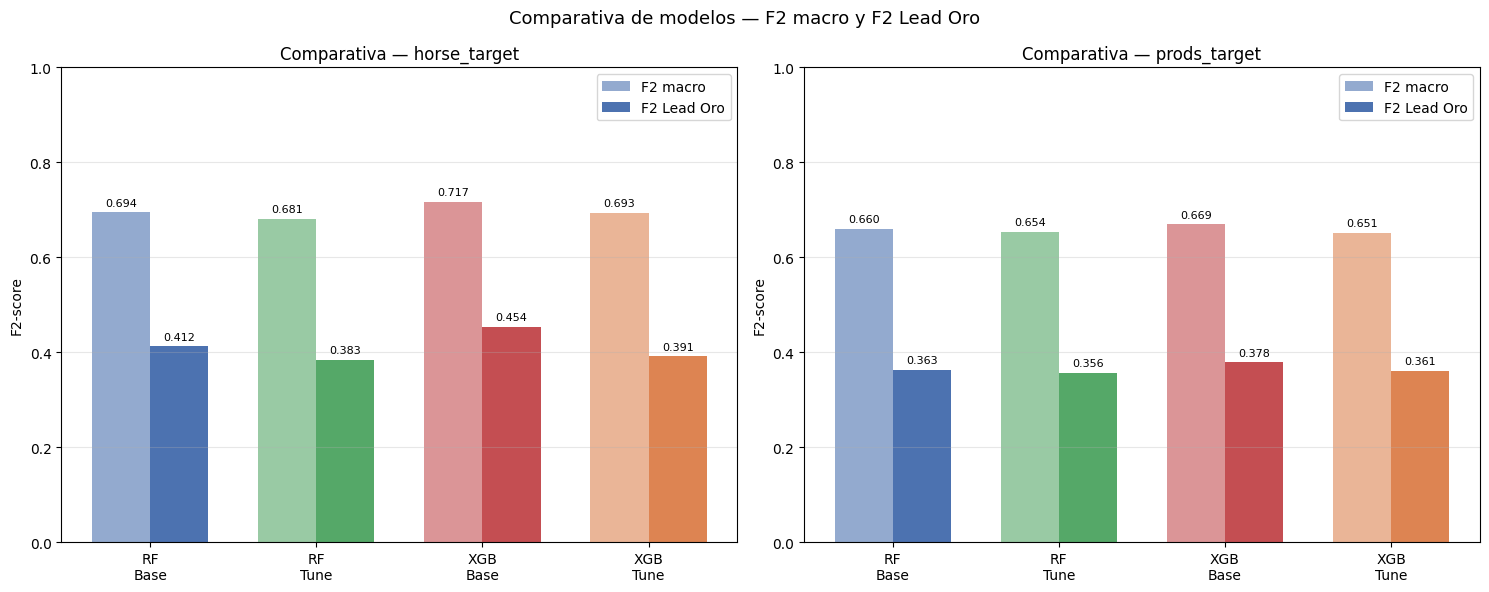

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
nombres_plot = ['RF\nBase', 'RF\nTune', 'XGB\nBase', 'XGB\nTune']
colores = ['#4C72B0', '#55A868', '#C44E52', '#DD8452']

for ax, target in zip(axes, ['horse', 'prods']):
    f2_macro = [r[target]['f2_macro']    for _, r, _ in todos]
    f2_oro   = [r[target]['f2_lead_oro'] for _, r, _ in todos]
    x = np.arange(len(nombres_plot))
    w = 0.35
    b1 = ax.bar(x - w/2, f2_macro, w, label='F2 macro',
                color=[c + '99' for c in colores])
    b2 = ax.bar(x + w/2, f2_oro,   w, label='F2 Lead Oro', color=colores)
    ax.set_xticks(x); ax.set_xticklabels(nombres_plot)
    ax.set_ylim(0, 1); ax.set_ylabel('F2-score')
    ax.set_title(f'Comparativa — {target}_target')
    ax.legend(); ax.grid(axis='y', alpha=0.3)
    for bar in list(b1) + list(b2):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01,
                f'{h:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Comparativa de modelos — F2 macro y F2 Lead Oro', fontsize=13)
plt.tight_layout()
plt.show()

### 6 · Selección del modelo campeón

Buscamos el run con mayor `f2_lead_oro_horse` en DagsHub, lo tageamos como `status=champion` y mostramos un resumen de sus métricas y params.

In [84]:
client = mlflow.tracking.MlflowClient()

# Experimento actual
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
exp_id = exp.experiment_id

# Buscamos todos los runs del experimento
runs = client.search_runs(
    experiment_ids=[exp_id],
    filter_string='attributes.status = "FINISHED"',
    order_by=['metrics.f2_lead_oro_horse DESC'],
    max_results=10
)

if not runs:
    print('No hay runs finalizados en el experimento.')
else:
    mejor = runs[0]
    nombre = mejor.data.tags.get('mlflow.runName', mejor.info.run_id)

    # Quitamos tag champion de cualquier run anterior
    for run in runs:
        if run.data.tags.get('status') == 'champion':
            client.set_tag(run.info.run_id, 'status', 'retired')

    # Tageamos el nuevo campeón
    client.set_tag(mejor.info.run_id, 'status', 'champion')

    # Resumen
    m = mejor.data.metrics
    p = mejor.data.params

    print(f'{'═'*60}')
    print(f' CAMPEÓN: {nombre}')
    print(f'{'═'*60}')
    print(f'  run_id : {mejor.info.run_id}')
    print(f'  F2 Lead Oro  — horse : {m.get("f2_lead_oro_horse", "N/A"):.4f}')
    print(f'  F2 Lead Oro  — prods : {m.get("f2_lead_oro_prods", "N/A"):.4f}')
    print(f'  F2 macro     — horse : {m.get("f2_macro_horse", "N/A"):.4f}')
    print(f'  Gap P2       — horse : {m.get("overfit_gap_p2_horse", "N/A"):.4f}')
    print(f'{'─'*60}')
    print('  Params:')
    for k, v in sorted(p.items()):
        print(f'    {k:<30} {v}')
    print(f'{'─'*60}')
    print(f'  Ver en DagsHub:')
    print(f'  https://dagshub.com/aletbm/S02-26-E45-Data_Science_EquineLead.mlflow'
          f'/#/experiments/{exp_id}/runs/{mejor.info.run_id}')

    # Tabla comparativa de todos los runs
    print(f'\n  Ranking completo (por F2 Lead Oro horse):')
    print(f'  {"Run":<16} {"F2 Oro horse":>13} {"F2 Oro prods":>13} {"Gap P2":>8}  Status')
    print(f'  {"─"*60}')
    for r in runs:
        rname  = r.data.tags.get('mlflow.runName', r.info.run_id[:8])
        f2h    = r.data.metrics.get('f2_lead_oro_horse', float('nan'))
        f2p    = r.data.metrics.get('f2_lead_oro_prods', float('nan'))
        gap    = r.data.metrics.get('overfit_gap_p2_horse', float('nan'))
        status = r.data.tags.get('status', '')
        print(f'  {rname:<14} {f2h:>13.4f} {f2p:>13.4f} {gap:>8.4f}  {status}')

════════════════════════════════════════════════════════════
 CAMPEÓN: XGB_Baseline
════════════════════════════════════════════════════════════
  run_id : 74f1707c89964d69866d337f07624075
  F2 Lead Oro  — horse : 0.4538
  F2 Lead Oro  — prods : 0.3784
  F2 macro     — horse : 0.7171
  Gap P2       — horse : 0.1175
────────────────────────────────────────────────────────────
  Params:
    p1_colsample_bytree            0.8
    p1_eval_metric                 aucpr
    p1_learning_rate               0.05
    p1_max_depth                   4
    p1_n_estimators                300
    p1_n_jobs                      -1
    p1_random_state                42
    p1_scale_pos_weight            15.164263322884013
    p1_subsample                   0.8
    p1_tree_method                 hist
    p2_colsample_bytree            0.8
    p2_eval_metric                 aucpr
    p2_learning_rate               0.05
    p2_max_depth                   4
    p2_n_estimators                300
    p2_n_jo